### Imports

In [1]:
import numpy as np
from numba import njit, types
from numba import  int8, float64, int64, uint64, intp, void, boolean, int32

import os, math, json, shutil, pathlib, tempfile
from dataclasses import dataclass
from concurrent.futures import ProcessPoolExecutor, as_completed

from typing import Literal, Optional
from multiprocessing import get_context

from datetime import datetime
import time
from typing import cast
from scipy.special import erfcinv

import hashlib
import re

from dataclasses import replace

import matplotlib.pyplot as plt
import os
import glob
from matplotlib import cm  # for colormap

In [ ]:
from .jitted_kernel import Simulate_two_replicas
from .init_and_checkpoints import realization_dir, start_fresh, resume, save_checkpoint

# Simulation at fixed ξ

### jitted RNG


In [2]:
# ─────────────────────────────────────────────────────────────────────────────
#  Xorshift128+ core: 2-word state → next uint64
# ─────────────────────────────────────────────────────────────────────────────
@njit(uint64(uint64[::1]),  nogil=True, inline='always', no_cpython_wrapper=True)
def xorshift128p_next_uint(state):
    """
    In-place update of a 2-element uint64[::1] (s[0], s[1]).
    Returns next 64-bit unsigned integer.
    """
    s1 = state[0]
    s0 = state[1]
    state[0] = s0
    s1 ^= (s1 << np.uint64(23))
    s1 ^= (s1 >> np.uint64(17))
    s1 ^= s0
    s1 ^= (s0 >> np.uint64(26))
    state[1] = s1
    return s0 + s1


@njit(float64(uint64[::1]), nogil=True, inline='always', no_cpython_wrapper=True)
def xorshift128p_next_float(state):
    u = xorshift128p_next_uint(state) >> np.uint64(11)   # upper 53 bits
    return u * np.float64(1.1102230246251565e-16) #2^-53                      # scale to [0,1)x


# ─────────────────────────────────────────────────────────────────────────────
#  Bounded integer 0 … bound-1  (round-down modulo, power-of-two fast-path)
# ─────────────────────────────────────────────────────────────────────────────
@njit(uint64(uint64[::1], uint64), inline='always', nogil=True, no_cpython_wrapper=True)
def next_uint_bounded(state, bound):
    # power-of-two fast path
    if bound & (bound - 1) == 0:
        return xorshift128p_next_uint(state) & (bound - 1)
    # otherwise simple modulo – bias ≈ bound / 2⁶⁴  < 1.5e-18  for bound<=250
    return xorshift128p_next_uint(state) % bound

@njit(int8(uint64[::1]), nogil=True, inline='always', no_cpython_wrapper=True)
def rand_pm1(state):
    x = xorshift128p_next_uint(state)
    # take the top bit (better quality than low bits) → 0 or 1
    b = np.uint64(x >> np.uint64(63))
    # map {0,1} → {+1,-1} without overflow
    return np.int8(1 - 2 * np.int64(b))

## MMC dynamics

### Metropolis

In [3]:
@njit(float64(  int64, int64, float64,
                int8[::1], float64[::1],
                float64[:,::1], int8[:,::1], float64[::1],
                float64, 
                uint64[::1]),
nogil=True, no_cpython_wrapper=True , fastmath = True
)
def do_one_Metropolis_sweep_return_ΔE(N,P,invN, σ,m, A,ξ,d, β, seed):

    ΔE = 0.0

    for _ in range (N):

        j = int64(next_uint_bounded(seed, np.uint64(N)))

        σ_j = σ[j]
        Aj  = A[j]
        ξj  = ξ[j]

        h_j  = 0.0                                #internal field
        J_jj = d[j]                               #self interaction

        for μ in range(P):  h_j  += Aj[μ] * m[μ]

        ΔH = 2 * (h_j * σ_j - J_jj)  

        if ΔH <= 0.0  or xorshift128p_next_float(seed) < math.exp(-β * ΔH): 

            m -= (2.0 * σ_j * invN) * ξj
            
            σ[j] = -σ_j

            ΔE += ΔH

    return ΔE


### Gaussian auxiliary-field

In [4]:
@njit(void(int64, int64, float64, int8[::1], int8[:,::1], float64[::1]), 
      nogil=True, inline='always', fastmath=True,no_cpython_wrapper=False)
def _recompute_m(N, P, invN, sigma, xi, m_out):
    """
    Recomputes m_out in-place from sigma and xi.
    Complexity: O(N*P)
    """
    for mu in range(P):
        dot = 0.0
        for i in range(N):
            dot += sigma[i] * xi[i, mu]
        m_out[mu] = dot * invN


@njit(float64(int64, int64, int8[::1], float64[::1], float64[:,::1]), 
      nogil=True, inline='always', fastmath=True ,no_cpython_wrapper=False)
def _recompute_E(N, P, sigma, m, A):
    """
    Recomputes Total Energy from sigma, m, and A.
    Uses H = -0.5 * sum(sigma_i * h_i) where h_i = sum(A_imu * m_mu)
    Complexity: O(N*P)
    """
    total_h_sigma = 0.0
    
    # We loop over N and P to calculate the local field h_i on the fly
    for i in range(N):
        h_i = 0.0
        for mu in range(P):
            h_i += A[i, mu] * m[mu]
        total_h_sigma += h_i * sigma[i]
        
    return -0.5 * total_h_sigma

In [5]:
@njit(float64(uint64[::1]), nogil=True, no_cpython_wrapper=True, fastmath=True)
def randn_std(seed):
    # Box–Muller: one N(0,1)
    u1 = xorshift128p_next_float(seed)
    if u1 < 1e-12:
        u1 = 1e-12
    u2 = xorshift128p_next_float(seed)
    r = math.sqrt(-2.0 * math.log(u1))
    theta = 2.0 * math.pi * u2
    return r * math.cos(theta)


In [6]:
@njit(float64(
        int64, int64, float64,          # N, P, invN
        int8[::1], float64[::1],        # σ (N), m (P)  [in place]
        int8[:, ::1], float64[:, ::1],  # ξ (N,P), L (P,P) with G = L L^T
        float64,                        # β
        uint64[::1],                    # seed
        float64[::1], float64[::1]      # scratch u(P), z(P)
      ),
      nogil=True, no_cpython_wrapper=True, fastmath=True)
def HS_blocked_gibbs_sweep_return_E(N, P, invN, σ, m, ξ, L, β, seed, u, z):
    """
    One HS blocked Gibbs update at fixed β for ONE replica.
    - Updates σ and m in place.
    - Returns E_new = -N/2 * m^T G m, computed as -N/2 * ||L^T m||^2.
    Scratch:
      u: length P  (used for L^T m_old, then eta, then L^T m_new)
      z: length P  (used for mean, then HS field)
    """

    # --- 1) u = L^T m_old (store in u) ---
    for i in range(P):
        acc = 0.0
        for j in range(i, P):          # L[j,i] nonzero for j>=i (L lower-triangular)
            acc += L[j, i] * m[j]
        u[i] = acc

    # --- 2) z = mu = sqrt(β N) * G m = sqrt(β N) * L (L^T m) = sBN * L u ---
    sBN = math.sqrt(β * float64(N))
    for i in range(P):
        acc = 0.0
        for j in range(i + 1):         # lower-triangular multiply
            acc += L[i, j] * u[j]
        z[i] = sBN * acc               # z temporarily holds mu

    # --- 3) sample z = mu + L eta, eta~N(0,I) ---
    # overwrite u with eta
    for i in range(P):
        u[i] = randn_std(seed)

    # add correlated noise: z += L u
    for i in range(P):
        acc = 0.0
        for j in range(i + 1):
            acc += L[i, j] * u[j]
        z[i] += acc

    # --- 4) sample σ | z, accumulate m in-place ---
    # IMPORTANT: compute u_old before zeroing m (done above), now m can be reused as accumulator
    for mu in range(P):
        m[mu] = 0.0

    s = math.sqrt(β * invN)            # sqrt(β/N)
    for i in range(N):
        dot = 0.0
        for mu in range(P):
            dot += float64(ξ[i, mu]) * z[mu]
        h = s * dot

        # p = 1/(1+exp(-2h)) via tanh for stability
        p = 0.5 * (1.0 + math.tanh(h))
        if xorshift128p_next_float(seed) < p:
            σi = int8(1)
        else:
            σi = int8(-1)
        σ[i] = σi

        # accumulate m numerator
        for mu in range(P):
            m[mu] += float64(σi) * float64(ξ[i, mu])

    for mu in range(P):
        m[mu] *= invN

    # --- 5) E_new = -N/2 * ||L^T m_new||^2 ---
    for i in range(P):
        acc = 0.0
        for j in range(i, P):
            acc += L[j, i] * m[j]
        u[i] = acc

    norm2 = 0.0
    for i in range(P):
        norm2 += u[i] * u[i]

    return -0.5 * float64(N) * norm2


from now on σ is meant to be a K x N array and β is a 1d array of length K.
E is an array of length K
Seed_array is an array of seeds of length K+1, one stream for each PT "replica" and the last is for swaps.

I is an array of indices to keep track of the swaps without moving entire configurations

### Parallel tempering

In [7]:
@njit(float64(  float64, float64,
                float64, float64),
nogil=True, no_cpython_wrapper=True, inline='always', fastmath = True
)
def swap_probability(E_a,E_b, β_k1,β_k2):
    
    return math.exp((β_k2 - β_k1)*(E_b - E_a))


@njit(void( boolean,                                   # parity,
            int64,                                     # K,
            float64[::1], int64[::1],                  # E,I,
            float64[::1],                              # β,
            uint64[:,::1],                             # seed_array
            int64[::1]),                               # swap_count
nogil=True, no_cpython_wrapper=True
)
def attempt_swap(parity, K, E,I, β, seed_array, swap_count):

    for k1 in range(np.int64(parity), K-1, 2):
        k2 = k1 + 1
        p = swap_probability(E[I[k1]], E[I[k2]], β[k1], β[k2])

        if (p >= 1.0) or (xorshift128p_next_float(seed_array[-1]) < p): #Metropolis
                
            I_k1 = I[k1]
            I_k2 = I[k2]
            I[k1], I[k2] = I_k2, I_k1  # Swap indices in I directly

            swap_count[k1] +=1

### One step

In [ ]:
#   σ : (K, N)   int8
#   m : (K, P)   float64
#   E : (K,)     float64
#   I : (K,)     int64      slot -> replica index permutation
#   A : (N, P)   float64    = ξ @ G^T  (used only by Metropolis)
#   ξ : (N, P)   int8
#   d : (N,)     float64    diagonal self-term for Metropolis ΔH
#   L : (P, P)   float64    Cholesky of G: G = L L^T  (used by HS)
#   β : (K,)     float64    inverse temperatures per slot
#   seed_array : (K+1, 2) uint64 seed_array[k] for local RNG stream,seed_array[-1] for swaps
#   swap_count : (K-1,) int64 accepted-swap counts per interface (for this chain)
#   u_scratch  : (K, P) float64 scratch per replica (HS uses u_scratch[rep])
#   z_scratch  : (K, P) float64 scratch per replica (HS uses z_scratch[rep])
#   p_hs       : probability of doing hs, 1-p_hs is the probability of doing Metropolis

@njit(
    void(
        int64, int64, int64, float64,          # N, P, K, invN
        int8[:,  ::1],                         # σ
        float64[:,::1],                        # m
        float64[::1],                          # E
        int64[::1],                            # I
        float64[:,::1],                        # A
        int8[:,  ::1],                         # ξ
        float64[::1],                          # d
        float64[:,::1],                        # L
        float64[::1],                          # β
        uint64[:,::1],                         # seed_array
        int64[::1],                            # swap_count
        float64[:,::1],                        # u_scratch
        float64[:,::1],                        # z_scratch
        float64                                # p_hs
    ),
    nogil=True, no_cpython_wrapper=True, fastmath=True
)
def do_one_MMC_step(
    N, P, K, invN,
    σ, m, E, I,
    A, ξ, d, L,
    β, seed_array, swap_count,
    u_scratch, z_scratch,
    p_hs
):
    """
    One MMC macro-step for ONE PT chain:
      - local update at each slot (Metropolis or HS with prob p_hs)
      - even-edge swap pass
      - local update again
      - odd-edge swap pass
    """
    # -------- first local sweep (then even swaps) --------
    for k in range(K):
        rep = I[k]  # actual replica index currently sitting at slot k

        # decide kernel (HS with prob p_hs)
        if xorshift128p_next_float(seed_array[k]) < p_hs:
            # HS returns E_new (overwrite E[rep])
            E[rep] = HS_blocked_gibbs_sweep_return_E(
                N, P, invN,
                σ[rep], m[rep],
                ξ, L,
                β[k],                 
                seed_array[k],
                u_scratch[rep], z_scratch[rep]
            )
        else:
            # Metropolis returns ΔE (increment E[rep])
            E[rep] += do_one_Metropolis_sweep_return_ΔE(
                N, P, invN,
                σ[rep], m[rep],
                A, ξ, d,
                β[k],
                seed_array[k]
            )

    attempt_swap(0, K, E, I, β, seed_array, swap_count)

    # -------- second local sweep (then odd swaps) --------
    for k in range(K):
        rep = I[k]

        if xorshift128p_next_float(seed_array[k]) < p_hs:
            E[rep] = HS_blocked_gibbs_sweep_return_E(
                N, P, invN,
                σ[rep], m[rep],
                ξ, L,
                β[k],
                seed_array[k],
                u_scratch[rep], z_scratch[rep]
            )
        else:
            E[rep] += do_one_Metropolis_sweep_return_ΔE(
                N, P, invN,
                σ[rep], m[rep],
                A, ξ, d,
                β[k],
                seed_array[k]
            )

    attempt_swap(1, K, E, I, β, seed_array, swap_count)


## 2-replica Simulation

In [9]:
import math
import numpy as np
from numba import njit, int64, float64, int8

@njit(nogil=True, fastmath=True)
def chol_spd(A, L, P):
    # A = L L^T, A SPD, L lower-triangular
    for i in range(P):
        for j in range(P):
            L[i, j] = 0.0

    for i in range(P):
        for j in range(i + 1):
            s = 0.0
            for k in range(j):
                s += L[i, k] * L[j, k]
            if i == j:
                v = A[i, i] - s
                if v <= 1e-14:
                    v = 1e-14
                L[i, i] = math.sqrt(v)
            else:
                L[i, j] = (A[i, j] - s) / L[j, j]


@njit(nogil=True, fastmath=True)
def solve_chol(L, b, x, P):
    # Solve (L L^T) x = b. L lower-triangular.
    # forward: L y = b  (store y into x)
    for i in range(P):
        s = b[i]
        for k in range(i):
            s -= L[i, k] * x[k]
        x[i] = s / L[i, i]

    # backward: L^T x = y  (overwrite x)
    for i in range(P - 1, -1, -1):
        s = x[i]
        for k in range(i + 1, P):
            s -= L[k, i] * x[k]
        x[i] = s / L[i, i]


@njit(
    nogil=True, fastmath=True
)
def compute_cholG_from_xi_A(
    N, P,
    xi, A,
    XtX, XtA, Grec, Lx,
    b, x,
    L_G
):
    """
    Recover G from xi and A=xi@G^T (with G symmetric in your use-case),
    then compute its Cholesky L_G such that G = L_G L_G^T.

    Solves: (xi^T xi) G = (xi^T A)

    All arrays must be preallocated:
      xi   : (N,P) int8
      A    : (N,P) float64
      XtX  : (P,P) float64
      XtA  : (P,P) float64
      Grec : (P,P) float64
      Lx   : (P,P) float64  chol(XtX)
      b,x  : (P,)  float64  scratch
      L_G  : (P,P) float64  output chol(G)
    """

    # form XtX = xi^T xi, XtA = xi^T A
    for mu in range(P):
        for nu in range(P):
            sxx = 0.0
            sxa = 0.0
            for i in range(N):
                xim = float64(xi[i, mu])
                sxx += xim * float64(xi[i, nu])
                sxa += xim * A[i, nu]
            XtX[mu, nu] = sxx
            XtA[mu, nu] = sxa

    # chol(XtX)
    chol_spd(XtX, Lx, P)

    # solve for each column of G: XtX * Grec[:,nu] = XtA[:,nu]
    for nu in range(P):
        for mu in range(P):
            b[mu] = XtA[mu, nu]
            x[mu] = 0.0
        solve_chol(Lx, b, x, P)
        for mu in range(P):
            Grec[mu, nu] = x[mu]

    # symmetrize (numerics)
    for i in range(P):
        for j in range(P):
            Grec[i, j] = 0.5 * (Grec[i, j] + Grec[j, i])

    # chol(G)
    chol_spd(Grec, L_G, P)


In [10]:
@njit(void( int64,int64,int64,float64,                                    # N,P,K,invN       sizes
            int8[:,:,::1],float64[:,:,::1],float64[:,::1],int64[:,::1],   # Σ,M,Ξ,Ψ,         state variables
            float64[:,::1],int8[:,::1],float64[::1],                      # A,ξ,d            structure
            float64[::1],                                                 # β,                
            uint64[:,:,::1],                                              # seed_matrix,
            int64,int64,int64,                                            # eq_time, sam_interv, N_data,
            float64[:,:,:],float64[:,:,:,:],int64[::1],                   # E_ts,m_ts,μ_to_store  
            float64[:, :], # observables are not C-contiguous             # q01_ts
            int64[:,::1]                                                  # replica_swap_count  state var
           ),                          
nogil=False, no_cpython_wrapper=False
)
def Simulate_two_replicas( N,P,K,invN,
                           Σ,M,Ξ,Ψ, 
                           A,ξ,d,
                           β,
                           seed_matrix,
                           equilibration_time, sampling_interval, N_data,
                           E_ts,m_ts,μ_to_store,
                           q01_ts,
                           replica_swap_count ):

    """
    New args:

        Σ,M,Ξ,Ψ : Array of spins, Mattis overlaps, energies, box indeces for PT, extra dimension for 2 replicas.

        seed_matrix : RNG seed matrix for Xorshift128+, extra dimension for the 2 replicas.

        E_ts, m_ts, q_01_ts are empty arrays of shape (2,N_data,K,shape(obs)) to be filled during the run
    """

    p_hs = 0.1
    u_scratch = np.zeros((K,P),dtype = np.float64)
    z_scratch = np.zeros((K,P),dtype = np.float64)
    #stuff for cholesky
    XtX  = np.empty((P,P), np.float64)
    XtA  = np.empty((P,P), np.float64)
    Grec = np.empty((P,P), np.float64)
    Lx   = np.empty((P,P), np.float64)
    L    = np.empty((P,P), np.float64)
    b    = np.empty(P, np.float64)
    x    = np.empty(P, np.float64)

    compute_cholG_from_xi_A(N, P, ξ, A, XtX, XtA, Grec, Lx, b, x, L)

    #THERMALIZE
    for _ in range(equilibration_time):
        do_one_MMC_step(N,P,K,invN, Σ[0],M[0],Ξ[0],Ψ[0], A,ξ,d,L, β, seed_matrix[0],
        replica_swap_count[0],u_scratch,z_scratch,p_hs)

    for _ in range(equilibration_time):
        do_one_MMC_step(N,P,K,invN, Σ[1],M[1],Ξ[1],Ψ[1], A,ξ,d,L, β, seed_matrix[1],
        replica_swap_count[1],u_scratch,z_scratch,p_hs)

    #START SAMPLING
    for n in range(N_data):

        #EVOLVE
        for _ in range(sampling_interval):
            do_one_MMC_step(N,P,K,invN, Σ[0],M[0],Ξ[0],Ψ[0], A,ξ,d,L, β, seed_matrix[0],
            replica_swap_count[0],u_scratch,z_scratch,p_hs)

        
        for _ in range(sampling_interval):
            do_one_MMC_step(N,P,K,invN, Σ[1],M[1],Ξ[1],Ψ[1], A,ξ,d,L, β, seed_matrix[1],
            replica_swap_count[1],u_scratch,z_scratch,p_hs)
        """
        #SNAP BACK (prevent drift)
        for b in range(2):
            for k in range(K):
                _recompute_m(N, P, invN, Σ[b, Ψ[b,k]], ξ, M[b, Ψ[b,k]]) 

                Ξ[b, Ψ[b,k]] = _recompute_E(N, P, Σ[b, Ψ[b,k]], M[b, Ψ[b,k]], A)
        """#the snap back is useless because hs already recomputes from scratch
        #FILL THE TIME SERIES
        for k in range(K):
            E_ts[0,n,k] = Ξ[0, Ψ[0,k]]
            E_ts[1,n,k] = Ξ[1, Ψ[1,k]]

            for p in range (μ_to_store.shape[0]):

                μ = μ_to_store[p]

                m_ts[0,n,k,p] = M[0, Ψ[0,k], μ]
                m_ts[1,n,k,p] = M[1, Ψ[1,k], μ]
                           
            # Gauge-fix to align with retrieval pattern ξ_0
            #sgn0 = 1.0 if m_ts[0,n,k,0] >= 0 else -1.0
            #sgn1 = 1.0 if m_ts[1,n,k,0] >= 0 else -1.0

            q_01_res = 0.                                   # Edward-Anderson overlap
            for i in range(N):
                q_01_res += Σ[0, Ψ[0,k], i] * Σ[1, Ψ[1,k], i]

            q01_ts[n,k] = q_01_res / N

# SysConfig, init and checkpoints

## Configs

In [11]:
@dataclass(frozen=True)
class SysConfig:
    N: int; P: int; K: int
    t: float
    c: float 
    β: np.ndarray            # (K,)
    mu_to_store: np.ndarray  # e.g. [0]
    master_seed: int
    spin_init_mode: str = "random"   # this can be changed for different experiments

    def __post_init__(self):
        beta = np.ascontiguousarray(np.asarray(self.β, dtype=np.float64))
        mu   = np.ascontiguousarray(np.asarray(self.mu_to_store, dtype=np.int64))
        if beta.ndim != 1 or beta.size != self.K: raise ValueError("β must be 1D(K)")
        if mu.size == 0: mu = np.array([0], dtype=np.int64)
        if np.any((mu < 0) | (mu >= self.P)): raise ValueError("mu out of range")
        object.__setattr__(self, "β", beta)
        object.__setattr__(self, "mu_to_store", np.unique(mu))

        c = float(self.c)
        if not (0.0 <= c <= 1.0): raise ValueError("c must be in [0,1]")
        object.__setattr__(self, "c", c)

@dataclass(frozen=True)
class RunConfig:
    run_root: str
    equilibration_time: int
    sampling_interval: int
    chunk_size: int
    N_data_target: int
    
    def __post_init__(self):
        if self.equilibration_time < 0 or self.sampling_interval <= 0 or self.chunk_size <= 0:
            raise ValueError("bad run params")
        if self.N_data_target <= 0: raise ValueError("N_data_target must be > 0")

## Init ξ - Σ - seed_matrix

In [12]:
MASK64 = (1 << 64) - 1

def splitmix64_py(x: int) -> int:
    z = (x + 0x9E3779B97F4A7C15) & MASK64
    z = ((z ^ (z >> 30)) * 0xBF58476D1CE4E5B9) & MASK64
    z = ((z ^ (z >> 27)) * 0x94D049BB133111EB) & MASK64
    return (z ^ (z >> 31)) & MASK64

def tag_to_u64(tag) -> int:
    h = hashlib.blake2b(digest_size=8)
    if isinstance(tag, (int, np.integer)):
        h.update(b'i'); h.update(int(tag).to_bytes(8, 'little', signed=False))
    else:
        b = str(tag).encode('utf-8')
        h.update(b's'); h.update(len(b).to_bytes(4, 'little')); h.update(b)
    return int.from_bytes(h.digest(), 'little')

def derive_xorshift_state(master_seed: int, tag_tuple) -> np.ndarray:
    x = int(master_seed) & MASK64
    for t in tag_tuple:
        x ^= tag_to_u64(t)
        x = splitmix64_py(x); x = splitmix64_py(x)
    s0 = splitmix64_py(x)
    s1 = splitmix64_py(s0 ^ x)
    if (s0 | s1) == 0:
        s1 = 1
    return np.array([np.uint64(s0), np.uint64(s1)], dtype=np.uint64)


In [13]:
def sample_ξ(N, P, master_seed, rid, c: float = 0.0):

    if c == 0.0:
        seed0 = derive_xorshift_state(master_seed, (rid, "ξ"))[0]
    else:
        c_tag = np.float64(c).view(np.uint64).item()   # stable, no string/rounding issues
        seed0 = derive_xorshift_state(master_seed, (rid, "ξ", c_tag))[0]
    rng = np.random.default_rng(int(seed0))


    if c == 0.0:
        return (rng.integers(0, 2, size=(N, P), dtype=np.int8) * 2 - 1).astype(np.int8)

    p = 0.5 * (1.0 - np.sqrt(c))

    eta = np.empty(N, dtype=np.int8)
    eta[:N//2] = 1
    eta[N//2:] = -1
    rng.shuffle(eta)

    flip = (rng.random((N, P)) < p)
    s = np.where(flip, -1, 1).astype(np.int8)

    return (eta[:, None] * s).astype(np.int8)

In [14]:
def init_spins(sys: SysConfig, rid: int, xi: np.ndarray) -> np.ndarray:
    """
    Returns Σ with shape (2, K, N), dtype=int8.
    Uses sys.spin_init_mode to choose the strategy.
    Modes now: "random".
    """
    Σ = np.empty((2, sys.K, sys.N), dtype=np.int8)

    if sys.spin_init_mode == "random":
        for b in (0, 1):
            rng = np.random.default_rng(int(derive_xorshift_state(sys.master_seed, (rid, b, "sigma"))[0]))
            Σ[b] = (rng.integers(0, 2, size=(sys.K, sys.N), dtype=np.int8) * 2 - 1)

    
    elif sys.spin_init_mode.startswith("corrupted"):

        target = xi[:, 0] # Target pattern 0
        
        # 2. Parse noise level (e.g., "corrupted_0.10")
        try:
            noise_level = float(sys.spin_init_mode.split("_")[1])
        except:
            noise_level = 0.10 # Default 10%
            
        # 3. Create corrupted replicas
        for b in (0, 1):
            # Deterministic seed for flips
            rng = np.random.default_rng(
                int(derive_xorshift_state(sys.master_seed, (rid, b, "sigma_init"))[0])
            )
            
            # Broadcast target to (K, N)
            base_config = np.tile(target, (sys.K, 1))
            
            # Generate flip mask
            flips = rng.random(size=(sys.K, sys.N)) < noise_level
            
            # Apply flips: sigma = xi * (-1 if flip else 1)
            # -1 * 1 = -1 (flip), 1 * 1 = 1 (keep)
            modifiers = np.where(flips, -1, 1).astype(np.int8)
            Σ[b] = base_config * modifiers

    else:
        raise ValueError(f"Unknown spin_init_mode: {sys.spin_init_mode!r}")

    return Σ


In [15]:
def _make_seed_matrix(sys: SysConfig, rid: int) -> np.ndarray:
    seeds = np.empty((2, sys.K + 1, 2), dtype=np.uint64)
    for b in (0,1):
        for k in range(sys.K):
            seeds[b, k] = derive_xorshift_state(sys.master_seed, (rid, b, k, "spin"))
        seeds[b, -1] = derive_xorshift_state(sys.master_seed, (rid, b, "swap"))
    return seeds

## Build dreaming kernel and state/observables

In [16]:
def build_G_t(ξ: np.ndarray, t: float) -> np.ndarray:
    ξf = np.ascontiguousarray(ξ, dtype=np.float64)
    N, P = ξf.shape
    C = (ξf.T @ ξf) / N
    I = np.eye(P, dtype=np.float64)
    G = np.linalg.solve(I + t * C, (1.0 + t) * I)
    return 0.5 * (G + G.T)

def build_A_and_Jdiag(G: np.ndarray, ξ: np.ndarray):

    Gf  = np.ascontiguousarray(G,  dtype=np.float64)   # (P,P)
    ξf = np.ascontiguousarray(ξ, dtype=np.float64)   # (N,P)
    N   = ξf.shape[0]

    # A[j, μ] = Σ_ν G[μ,ν] * ξ[j,ν]  → A = ξ @ G^T
    A = ξf @ Gf.T                                  # (N,P)
    # Jd[j] = (1/N) Σ_μ A[j,μ]*ξ[j,μ]
    Jd = (A * ξf).sum(axis=1) / float(N)           # (N,)

    # enforce exact dtype/contiguity for Numba callers
    A  = np.ascontiguousarray(A,  dtype=np.float64)
    Jd = np.ascontiguousarray(Jd, dtype=np.float64)
    return A, Jd

In [17]:
def compute_M_from_σ_ξ(σ: np.ndarray, ξ: np.ndarray) -> np.ndarray:
    """
    σ: (K, N) ±1 int8; ξ: (N, P) ±1 int8
    Returns M: (K, P) float64 where M[k, mu] = (1/N) sum_i ξ[i,mu] * σ[k,i]
    """
    N, P = ξ.shape
    S = σ.astype(np.float64)  # (K, N)
    X = ξ.astype(np.float64)   # (N, P)
    return (S @ X) / float(N)   # (K, P)

def compute_E_from_M(M: np.ndarray, G: np.ndarray, N: int) -> np.ndarray:
    """
    M: (K, P) ; G: (P, P)
    H = -N/2 * sum_μ,ν M_μ G_μ,ν M_ν  per K
    """
    MG = M @ G    # (K, P)
    return -0.5 * N * np.einsum("kp,kp->k", M, MG)

## Save/load Sysconfig and state

Here we decide what constitutes a state. This is used both for chunking and to resume a run.

#### helpers

In [18]:
def ensure_dir(p: str) -> None:
    os.makedirs(p, exist_ok=True)

def realization_dir(run_root: str, rid: int) -> str:
    return os.path.join(run_root, f"r{rid:03d}")

#The first verion (truly atomic) works on native Linux systems, not on WSL
"""
def atomic_save_npz(path: str, **arrays) -> None:
    d = os.path.dirname(path); ensure_dir(d)
    fd, tmp = tempfile.mkstemp(prefix=".tmp_", dir=d)
    os.close(fd)
    try:
        np.savez_compressed(tmp, **arrays)
        with open(tmp, "rb") as f: os.fsync(f.fileno())
        os.replace(tmp, path)
    finally:
        try: os.unlink(tmp)
        except FileNotFoundError: pass
"""
def atomic_save_npz(path: str, **arrays) -> None:
    """
    Simpler, non-atomic save that works reliably on WSL2/Windows mounts.
    """
    d = os.path.dirname(path)
    ensure_dir(d)
    # Write directly to the file, skipping the temp-and-swap dance
    np.savez_compressed(path, **arrays)
    # Force OS to flush to disk immediately to prevent 0KB files on crash
    # (Note: we can't fsync a file path directly in Python without opening it, 
    # but closing np.savez usually flushes enough for this context)

### savers and loaders

In [19]:
def save_disorder(rdir: str, ξ: np.ndarray, t: float) -> None:
    atomic_save_npz(os.path.join(rdir, "disorder.npz"),
                    ξ=ξ.astype(np.int8, copy=False), t=np.float64(t))

def load_disorder(rdir: str) -> tuple[np.ndarray, float]:
    z = np.load(os.path.join(rdir, "disorder.npz"))
    return z["ξ"].astype(np.int8, copy=False), float(z["t"])

In [20]:
def save_sysconfig(rdir: str, sys: SysConfig) -> None:
    atomic_save_npz(
        os.path.join(rdir, "sysconfig.npz"),
        N=np.int64(sys.N), P=np.int64(sys.P), K=np.int64(sys.K),
        t=np.float64(sys.t), c=np.float64(sys.c),
        master_seed=np.int64(sys.master_seed),
        beta=np.ascontiguousarray(sys.β, dtype=np.float64),
        mu=np.ascontiguousarray(sys.mu_to_store, dtype=np.int64),
        spin_init_mode=np.array(sys.spin_init_mode, dtype="U"),
    )

def load_sysconfig(rdir: str) -> SysConfig:
    """
    If sysconfig.npz is missing, you must be in fresh mode (provide SysConfig). Otherwise it’s an error.
    """
    z = np.load(os.path.join(rdir, "sysconfig.npz"))
    return SysConfig(
        N=int(z["N"]), P=int(z["P"]), K=int(z["K"]),
        t=float(z["t"]), c=float(z["c"]),
        master_seed=int(z["master_seed"]),
        β=z["beta"].astype(np.float64, copy=False),
        mu_to_store=z["mu"].astype(np.int64, copy=False),
        spin_init_mode=str(z["spin_init_mode"]),
    )

In [21]:
def save_checkpoint(rdir: str, state: dict, n_done: int, β: np.ndarray) -> None:
    atomic_save_npz(os.path.join(rdir, "checkpoint.npz"),
        Σ=state["Σ"], M=state["M"], Ξ=state["Ξ"], Ψ=state["Ψ"],
        seeds=state["seeds"], n_swaps=state["n_swaps"],
        β=np.ascontiguousarray(β, dtype=np.float64),
        n_done=np.int64(n_done),
    )

def load_checkpoint(rdir: str):
    z = np.load(os.path.join(rdir, "checkpoint.npz"))
    state = {"Σ": z["Σ"], "M": z["M"], "Ξ": z["Ξ"], "Ψ": z["Ψ"],
             "seeds": z["seeds"], "n_swaps": z["n_swaps"], "β": z["β"]}
    return state, int(z["n_done"])

## Start_fresh and resume APIs

In [22]:
def start_fresh(run_root: str, rid: int, sys: SysConfig, run: RunConfig):
    rdir = realization_dir(run_root, rid); ensure_dir(rdir)

    save_sysconfig(rdir, sys)

    ξ = sample_ξ(sys.N, sys.P, sys.master_seed, rid, sys.c)
    save_disorder(rdir, ξ, sys.t)
    G = build_G_t(ξ, sys.t); A, d = build_A_and_Jdiag(G, ξ)

    Σ = init_spins(sys, rid, ξ)   # ← uses sys.spin_init_mode

    M = np.empty((2, sys.K, sys.P), dtype=np.float64)
    Ξ = np.empty((2, sys.K), dtype=np.float64)
    for b in (0, 1):
        M[b] = compute_M_from_σ_ξ(Σ[b], ξ)
        Ξ[b] = compute_E_from_M(M[b], G, sys.N)

    Ψ = np.tile(np.arange(sys.K, dtype=np.int64), (2, 1))
    seeds = _make_seed_matrix(sys, rid)
    n_swaps = np.zeros((2, sys.K - 1), dtype=np.int64)

    #this will be untouched, initialization sanity check
    atomic_save_npz(os.path.join(rdir, "checkpoint_init.npz"),
        Σ=Σ, M=M, Ξ=Ξ, Ψ=Ψ, seeds=seeds, n_swaps=n_swaps,
        n_done=np.int64(0), β=np.ascontiguousarray(sys.β, dtype=np.float64))
    
    #this will be overwritten after thermalization
    save_checkpoint(rdir,
        {"Σ": Σ, "M": M, "Ξ": Ξ, "Ψ": Ψ, "seeds": seeds, "n_swaps": n_swaps},
        n_done=0, β=sys.β)

    return dict(mode="fresh", rdir=rdir, sys=sys, ξ=ξ, G=G, A=A, d=d,
                Σ=Σ, M=M, Ξ=Ξ, Ψ=Ψ, seeds=seeds, n_swaps=n_swaps, n_done=0)

def resume(path_to_realization: str, run: RunConfig):
    rdir = path_to_realization

    # Load physics from disk 
    sys = load_sysconfig(rdir)

    # Rebuild couplings from stored disorder
    ξ, t = load_disorder(rdir)
    if float(t) != float(sys.t):
        raise RuntimeError("Stored disorder t != sys.t (this should not happen).")
    G = build_G_t(ξ, t); A, d = build_A_and_Jdiag(G, ξ)

    state, n_done = load_checkpoint(rdir)
    Σ, M, Ξ, Ψ = state["Σ"], state["M"], state["Ξ"], state["Ψ"]
    seeds, n_swaps = state["seeds"], state["n_swaps"]

    return dict(mode="resume", rdir=rdir, sys=sys, ξ=ξ, G=G, A=A, d=d,
                Σ=Σ, M=M, Ξ=Ξ, Ψ=Ψ, seeds=seeds, n_swaps=n_swaps, n_done=n_done)

# Chunked multi-processing over disorder

### A super-small append store for time serieses

In [23]:
def _atomic_save_npy(path: str, arr):
    import os, tempfile, numpy as np
    d = os.path.dirname(path); os.makedirs(d, exist_ok=True)
    fd, tmp = tempfile.mkstemp(prefix=".tmp_", suffix=".npy", dir=d); os.close(fd)
    try:
        np.save(tmp, arr); np.load(tmp, mmap_mode="r")  # quick sanity check
        os.replace(tmp, path); dirfd = os.open(d, os.O_DIRECTORY); os.fsync(dirfd); os.close(dirfd)
    finally:
        try: os.unlink(tmp)
        except FileNotFoundError: pass

class ChunkWriter:
    """
    Writes per-chunk files:
        timeseries/
          E.{start:09d}.npy      shape (2, T, K)
          q01.{start:09d}.npy    shape (T, K)
          m_sel.{start:09d}.npy  shape (2, T, K, P_sel)  (optional)
    """
    def __init__(self, rdir: str, K: int, P_sel: int, store_m_sel: bool = True):
        self.base = os.path.join(rdir, "timeseries")
        self.K = int(K)
        self.P_sel = int(P_sel)
        self.store_m_sel = bool(store_m_sel)
        os.makedirs(self.base, exist_ok=True)

    def write(self, start_idx: int,
              E_chunk: np.ndarray,      # (2, T, K)
              q01_chunk: np.ndarray,    # (T, K)
              m_sel_chunk: np.ndarray | None  # (2, T, K, P_sel) or None
              ):
        T = int(E_chunk.shape[1])
        pref = os.path.join(self.base, f"{start_idx:09d}")
        _atomic_save_npy(pref + ".E.npy",   E_chunk)
        _atomic_save_npy(pref + ".q01.npy", q01_chunk)
        if self.store_m_sel:
            if m_sel_chunk is None:
                raise ValueError("store expects m_sel but got None")
            _atomic_save_npy(pref + ".m_sel.npy", m_sel_chunk)

## The chunked simulation loop

In [24]:
def run_chunked(state: dict, run, *, rid: int | None = None, log_every_chunk: bool = True):
    """
    Works for both fresh and resume states:
      state: { rdir, sys, ξ, G, A, d, Σ, M, Ξ, Ψ, seeds, n_swaps, n_done, mode }
      run  : RunConfig
    """

    prefix = f"[rid={rid:03d} pid={os.getpid()}]" if rid is not None else f"[pid={os.getpid()}]"

    sys = state["sys"]
    rdir = state["rdir"]
    Σ, M, Ξ, Ψ = state["Σ"], state["M"], state["Ξ"], state["Ψ"]
    seeds, n_swaps = state["seeds"], state["n_swaps"]
    ξ, A, d = state["ξ"], state["A"], state["d"]

    invN = 1.0 / float(sys.N)
    n_done = int(state["n_done"])
    target = int(run.N_data_target)

    # Prepare writer
    P_sel = int(sys.mu_to_store.size)
    writer = ChunkWriter(rdir, K=sys.K, P_sel=P_sel, store_m_sel=True)

    # One-time equilibration if FRESH and n_done == 0
    if state.get("mode") == "fresh" and n_done == 0 and run.equilibration_time > 0:
        t_eq0 = time.perf_counter()
        # We can simply call the kernel with N_data=0 and eq_time>0
        Simulate_two_replicas(
            sys.N, sys.P, sys.K, invN,
            Σ, M, Ξ, Ψ,
            A, ξ, d,
            np.ascontiguousarray(sys.β, dtype=np.float64),
            seeds,
            run.equilibration_time,  # eq_time
            run.sampling_interval,   # doesn’t matter for N_data=0
            0,                       # N_data = 0 → only equilibrate
            np.empty((2,0,sys.K), dtype=np.float64),
            np.empty((2,0,sys.K,P_sel), dtype=np.float64),
            sys.mu_to_store.astype(np.int64, copy=False),
            np.empty((0,sys.K), dtype=np.float64),
            n_swaps
        )
        # Reset swap counters after equilibration so production stats start clean
        n_swaps.fill(0)
        # Save a checkpoint *post*-equilibration
        save_checkpoint(rdir,
            {"Σ": Σ, "M": M, "Ξ": Ξ, "Ψ": Ψ, "seeds": seeds, "n_swaps": n_swaps},
            n_done=n_done, β=sys.β)
        if log_every_chunk:
            print(f"{prefix} [eq] t_eq={time.perf_counter()-t_eq0:.2f}s | n_done={n_done}", flush=True)

    t0 = time.perf_counter()
    while n_done < target:
        take = min(run.chunk_size, target - n_done)
        start_idx = n_done

        # Allocate chunk buffers
        E_chunk   = np.empty((2, take, sys.K), dtype=np.float64)
        m_sel     = np.empty((2, take, sys.K, P_sel), dtype=np.float64)
        q01_chunk = np.empty((take, sys.K), dtype=np.float64)

        t_chunk = time.perf_counter()
        # Fill via your kernel (does 2x MMC sweeps per sample internally)
        Simulate_two_replicas(
            sys.N, sys.P, sys.K, invN,
            Σ, M, Ξ, Ψ,
            A, ξ, d,
            np.ascontiguousarray(sys.β, dtype=np.float64),
            seeds,
            0,                       # eq_time handled outside
            run.sampling_interval,
            take,
            E_chunk, m_sel,
            sys.mu_to_store.astype(np.int64, copy=False),
            q01_chunk,
            n_swaps
        )

        # Persist this chunk
        writer.write(start_idx, E_chunk, q01_chunk, m_sel)

        # Update progress & checkpoint
        n_done += take
        save_checkpoint(rdir,
            {"Σ": Σ, "M": M, "Ξ": Ξ, "Ψ": Ψ, "seeds": seeds, "n_swaps": n_swaps},
            n_done=n_done, β=sys.β)

        if log_every_chunk:
            elapsed = time.perf_counter() - t_chunk
            total   = time.perf_counter() - t0
            steps   = max(1, n_done * run.sampling_interval)
            acc     = float(n_swaps.mean() / steps)
            print(f"{prefix} [chunk] n_done={n_done}/{target} "
                  f"acc≈{acc:.3f} t_total={total/60:.1f}m", flush=True)

    # return updated state
    state["n_done"] = n_done
    return state

## The runner and the orchestrator

#### Sanity checks when resuming

In [25]:
def safe_len_from_chunks(rdir: str) -> int:
    """Reconstruct length from chunk files (most trustworthy for resume)."""
    base = os.path.join(rdir, "timeseries")
    if not os.path.isdir(base): return 0
    starts = []
    for name in os.listdir(base):
        if name.endswith(".E.npy"):
            stem = name[:-len(".E.npy")]
            try: starts.append(int(stem))
            except: pass
    if not starts: return 0
    total = 0
    for s in sorted(starts):
        E = np.load(os.path.join(base, f"{s:09d}.E.npy"), mmap_mode="r")
        total = max(total, s + E.shape[1])
    return total

def reconcile_n_done(rdir: str, n_done_ckpt: int) -> int:
    """Prefer the length implied by chunk files; warn if mismatch."""
    n_files = safe_len_from_chunks(rdir)
    if n_files != n_done_ckpt:
        print(f"[reconcile] {os.path.basename(rdir)}: checkpoint n_done={n_done_ckpt} "
              f"vs files={n_files} → using files", flush=True)
    return n_files


In [26]:
def has_valid_sysconfig(rdir: str) -> bool:
    path = os.path.join(rdir, "sysconfig.npz")
    if not os.path.exists(path):
        return False
    try:
        z = np.load(path)
        # touch required fields; will raise if corrupt/empty
        _ = int(z["N"]); _ = int(z["P"]); _ = int(z["K"])
        _ = float(z["t"]);_ = float(z["c"])
        _ = int(z["master_seed"])
        _ = z["beta"]; _ = z["mu"]
        return True
    except Exception:
        return False

### The worker entry ( one process = one realization )

In [27]:
def worker_run(rid: int, run, sys_if_needed):
    rdir = realization_dir(run.run_root, rid)
    ok = os.path.isdir(rdir) and has_valid_sysconfig(rdir)

    if ok:
        state = resume(rdir, run)
    else:
        # folder missing or has broken/empty sysconfig.npz → start fresh
        if os.path.isdir(rdir):
            shutil.rmtree(rdir, ignore_errors=True)  # wipe partial dir
        if sys_if_needed is None:
            raise RuntimeError(f"r{rid:03d}: need SysConfig for fresh start")
        state = start_fresh(run.run_root, rid, sys_if_needed, run)

    # reconcile and run
    n_done_ckpt = int(cast(int, state["n_done"]))   
    state["n_done"] = reconcile_n_done(rdir, n_done_ckpt)
    t0 = time.perf_counter()
    state = run_chunked(state, run, rid = rid)

    return {
        "rid": rid,
        "rdir": rdir,
        "n_written": state["n_done"],
        "t_minutes": (time.perf_counter() - t0)/60.0,
    }


### The pool executor

In [28]:
def run_pool(run, sys_for_fresh, R_workers: int, R_total: int, start_method="fork"):
    os.makedirs(run.run_root, exist_ok=True)
    mpctx = get_context(start_method)
    results = []
    with ProcessPoolExecutor(max_workers=R_workers, mp_context=mpctx) as ex:
        futs = [ex.submit(worker_run, rid, run, sys_for_fresh) for rid in range(R_total)]
        for f in as_completed(futs):
            results.append(f.result())
            r = results[-1]
            print(f"[pool] rid={r['rid']:03d} done | "
                  f"t≈{r['t_minutes']:.1f}m | {os.path.basename(r['rdir'])}", flush=True)
    return sorted(results, key=lambda x: x["rid"])

# Finding a good β ladder

## Lighter simulation

In [29]:
@njit(void( int64,int64,int64,float64,                                    # N,P,K,invN
            int8[:,:,::1],float64[:,:,::1],float64[:,::1],int64[:,::1],   # Σ,M,Ξ,Ψ
            float64[:,::1],int8[:,::1],float64[::1],                      # A,ξ,d
            float64[::1],                                                 # β
            uint64[:,:,::1],                                              # seed_matrix
            int64,int64,                                                  # eq_time, sweeps_per_sample
            int64,                                                        # n_samples
            int64[:,::1],                                                 # replica_swap_count (state)
            int8[:,:,::1]                                                 # I_ts
          ),
      nogil=False, no_cpython_wrapper=False, fastmath = True)
def Simulate_two_replicas_stats( N,P,K,invN,
                                 Σ,M,Ξ,Ψ,
                                 A,ξ,d,
                                 β,
                                 seed_matrix,
                                 equilibration_time, sweeps_per_sample,
                                 n_samples,
                                 replica_swap_count,
                                 I_ts ):
    
    p_hs = 0.3
    u_scratch = np.zeros((K,P),dtype = np.float64)
    z_scratch = np.zeros((K,P),dtype = np.float64)
    #stuff for cholesky
    XtX  = np.empty((P,P), np.float64)
    XtA  = np.empty((P,P), np.float64)
    Grec = np.empty((P,P), np.float64)
    Lx   = np.empty((P,P), np.float64)
    L    = np.empty((P,P), np.float64)
    b    = np.empty(P, np.float64)
    x    = np.empty(P, np.float64)

    compute_cholG_from_xi_A(N, P, ξ, A, XtX, XtA, Grec, Lx, b, x, L)

    # --- equilibrate ---
    for _ in range(equilibration_time):
        do_one_MMC_step(N,P,K,invN, Σ[0],M[0],Ξ[0],Ψ[0], A,ξ,d,L, β, seed_matrix[0], replica_swap_count[0],u_scratch,z_scratch,p_hs)
    for _ in range(equilibration_time):
        do_one_MMC_step(N,P,K,invN, Σ[1],M[1],Ξ[1],Ψ[1], A,ξ,d,L, β, seed_matrix[1], replica_swap_count[1],u_scratch,z_scratch,p_hs)

    replica_swap_count.fill(0)

    # --- production samples ---
    for n in range(n_samples):
        # decorrelate between samples
        for t in range(sweeps_per_sample):
            do_one_MMC_step(N,P,K,invN, Σ[0],M[0],Ξ[0],Ψ[0], A,ξ,d,L, β, seed_matrix[0], replica_swap_count[0],u_scratch,z_scratch,p_hs)
            I_ts[0,sweeps_per_sample*n+t] = Ψ[0]

        for t in range(sweeps_per_sample):
            do_one_MMC_step(N,P,K,invN, Σ[1],M[1],Ξ[1],Ψ[1], A,ξ,d,L, β, seed_matrix[1], replica_swap_count[1],u_scratch,z_scratch,p_hs)
            I_ts[1,sweeps_per_sample*n+t] = Ψ[1]



        """
        # read energies & Welford update per replica and temp
        for k in range(K):
            # replica 0
            x0 = Ξ[0, Ψ[0,k]]
            n0 = W_n[0,k] + 1
            delta0 = x0 - W_mean[0,k]
            W_mean[0,k] += delta0 / n0
            W_M2[0,k]   += delta0 * (x0 - W_mean[0,k])
            W_n[0,k]     = n0

            # replica 1
            x1 = Ξ[1, Ψ[1,k]]
            n1 = W_n[1,k] + 1
            delta1 = x1 - W_mean[1,k]
            W_mean[1,k] += delta1 / n1
            W_M2[1,k]   += delta1 * (x1 - W_mean[1,k])
            W_n[1,k]     = n1

        """

## Lighter orchestration

###  Configs

In [30]:
@dataclass(frozen=True)
class TrialConfig:
    equilibration_time: int
    sweeps_per_sample: int
    n_samples: int

@dataclass
class TrialResult:
    rid: int
    beta: np.ndarray        # (K,)
    acc_edge: np.ndarray    # (K-1,) acceptance per edge (both replicas avg)
    I_ts: np.ndarray        #(K,) timeseries of swaps

    """
    mean_E: np.ndarray      # (K,)   avg over replicas
    var_E: np.ndarray       # (K,)   avg over replicas
    """

### Runner, worker and executor

In [31]:
def run_trial_stats(sys: SysConfig, trial: TrialConfig, rid: int) -> TrialResult:
    # disorder/couplings (deterministic per rid)
    ξ  = sample_ξ(sys.N, sys.P, sys.master_seed, rid, sys.c)
    G  = build_G_t(ξ, sys.t)
    A, d = build_A_and_Jdiag(G, ξ)

    # initial microstate (deterministic per rid)
    Σ = init_spins(sys, rid, ξ)                  # your helper from earlier (2, K, N)
    M0 = compute_M_from_σ_ξ(Σ[0], ξ)
    M1 = compute_M_from_σ_ξ(Σ[1], ξ)
    M  = np.stack([M0, M1], axis=0)
    Ξ = np.empty((2, sys.K), np.float64)      # energies per replica, filled by your sweeps
    for b in (0,1):
        Ξ[b] = compute_E_from_M(M[b], G, sys.N)
    Ψ = np.tile(np.arange(sys.K, dtype=np.int64), (2,1))
    seeds = _make_seed_matrix(sys, rid)
    swap_count = np.zeros((2, sys.K-1), dtype=np.int64)

    I_ts = np.zeros((2,trial.n_samples*trial.sweeps_per_sample,sys.K),dtype=np.int8)
    """
    # Welford accumulators
    W_n    = np.zeros((2, sys.K), dtype=np.int64)
    W_mean = np.zeros((2, sys.K), dtype=np.float64)
    W_M2   = np.zeros((2, sys.K), dtype=np.float64)
    """
    # one in-memory stats run
    Simulate_two_replicas_stats(
        sys.N, sys.P, sys.K, 1.0/sys.N,
        Σ, M, Ξ, Ψ,
        A, ξ, d,
        np.ascontiguousarray(sys.β, np.float64),
        seeds,
        trial.equilibration_time, trial.sweeps_per_sample, trial.n_samples,
        swap_count,
        I_ts
    )
    """
    # finalize mean/var per replica → average replicas
    mask = (W_n > 1)
    var  = np.zeros_like(W_mean); var[mask] = W_M2[mask] / (W_n[mask] - 1)
    mean_E = W_mean.mean(axis=0)                 # (K,)
    var_E  = var.mean(axis=0)                    # (K,)
    """
    steps  = trial.n_samples * trial.sweeps_per_sample
    acc_edge = (swap_count.mean(axis=0) / max(1, steps))  # (K-1,)


    

    return TrialResult(rid=rid, beta=sys.β.copy(), acc_edge=acc_edge, I_ts=I_ts)

In [32]:
def worker_run_stats(rid: int, sys: SysConfig, trial: TrialConfig) -> TrialResult:
    return run_trial_stats(sys, trial, rid)

def pool_orchestrator_stats(sys: SysConfig, trial: TrialConfig,
                            R_workers: int, R_total: int, start_method="fork"):
    mpctx = get_context(start_method)
    out = []
    with ProcessPoolExecutor(max_workers=R_workers, mp_context=mpctx) as ex:
        futs = [ex.submit(worker_run_stats, rid, sys, trial) for rid in range(R_total)]
        for f in as_completed(futs): out.append(f.result())
    # sort by rid
    out.sort(key=lambda r: r.rid)
    return out

## Ladder search

### save/load and a helper

In [33]:
def save_optimal_ladder(path: str, sys: SysConfig, acc_edge_mean: Optional[np.ndarray] = None):
    os.makedirs(os.path.dirname(path), exist_ok=True)

    arrays = {
        "N": np.array(sys.N, dtype=np.int64),
        "P": np.array(sys.P, dtype=np.int64),
        "K": np.array(sys.K, dtype=np.int64),
        "t": np.array(sys.t, dtype=np.float64),
        "c": np.array(sys.c, dtype=np.float64),
        "master_seed": np.array(sys.master_seed, dtype=np.int64),
        "beta": np.asarray(sys.β, dtype=np.float64),
        "mu": np.asarray(sys.mu_to_store, dtype=np.int64),
        "spin_init_mode": np.array([sys.spin_init_mode]),
    }
    if acc_edge_mean is not None:
        arrays["acc_edge_mean"] = np.asarray(acc_edge_mean, dtype=np.float64)

    np.savez_compressed(path, **arrays)


def load_optimal_ladder(path: str):
    z = np.load(path, allow_pickle=False)
    acc = z["acc_edge_mean"] if "acc_edge_mean" in z.files else None
    return z["beta"], acc  

In [34]:
"""
def aggregate_results(results):
    #results: list[TrialResult] with .acc_edge (K-1,), .var_E (K,)
    acc  = np.stack([r.acc_edge for r in results], axis=0).mean(axis=0)   # (K-1,)
    varE = np.stack([r.var_E   for r in results], axis=0).mean(axis=0)    # (K,)
    sigma_mid = np.sqrt(0.5 * (varE[:-1] + varE[1:]))                     # (K-1,)
    return acc, varE, sigma_mid
"""

'\ndef aggregate_results(results):\n    #results: list[TrialResult] with .acc_edge (K-1,), .var_E (K,)\n    acc  = np.stack([r.acc_edge for r in results], axis=0).mean(axis=0)   # (K-1,)\n    varE = np.stack([r.var_E   for r in results], axis=0).mean(axis=0)    # (K,)\n    sigma_mid = np.sqrt(0.5 * (varE[:-1] + varE[1:]))                     # (K-1,)\n    return acc, varE, sigma_mid\n'

In [35]:
def aggregate_results(results, q_lo=0.20):
    """
    Robust aggregation across disorder.
    Returns:
      acc_lo  : low-tail quantile per interface (K-1,)
      acc_med : median per interface (K-1,) (useful for printing/return)
      sigma_mid: sqrt(0.5*(varE_k + varE_{k+1})) (K-1,)
    """
    acc_stack  = np.stack([r.acc_edge for r in results], axis=0)  # (R, K-1)
    varE_stack = np.stack([r.var_E    for r in results], axis=0)  # (R, K)

    acc_lo  = np.quantile(acc_stack, q_lo, axis=0)
    acc_med = np.quantile(acc_stack, 0.50, axis=0)
    """
    # compute sigma_mid per disorder first, then aggregate (median/quantile)
    sigma_mid_stack = np.sqrt(0.5 * (varE_stack[:, :-1] + varE_stack[:, 1:]))  # (R, K-1)
    sigma_mid = np.quantile(sigma_mid_stack, 0.5, axis=0)  # median across disorders
    sigma_mid = np.maximum(sigma_mid, 1e-12)
    """
    #this empirically works best
    varE = np.quantile(varE_stack, 0.50, axis=0)     # (K,) median across disorders
    varE = np.maximum(varE, 0.0)                     # safety
    sigma_mid = np.sqrt(0.5 * (varE[:-1] + varE[1:]))  # (K-1,)
    sigma_mid = np.maximum(sigma_mid, 1e-12)

    return acc_lo, acc_med, sigma_mid

### The algorithm

In [36]:
def _roundtrip_count_from_I(I_bt: np.ndarray) -> int:
    """
    Hot->cold->hot round trips counted from slot->walker series I_bt with shape (T,K).
    Ends are k=0 (hot) and k=K-1 (cold).
    """
    T, K = I_bt.shape
    hot_k, cold_k = 0, K - 1

    w_hot  = I_bt[:, hot_k].astype(np.int64)
    w_cold = I_bt[:, cold_k].astype(np.int64)

    t_hot_start = np.full(K, -1, dtype=np.int64)
    seen_cold   = np.zeros(K, dtype=np.bool_)
    n_rt = 0

    for t in range(T):
        wh = int(w_hot[t])
        wc = int(w_cold[t])

        # cold visit marks "success in between" if a hot-start exists
        if t_hot_start[wc] != -1:
            seen_cold[wc] = True

        # hot visit closes a RT if cold was seen since last hot-start
        if t_hot_start[wh] != -1 and seen_cold[wh]:
            n_rt += 1

        # (re)start at hot
        t_hot_start[wh] = t
        seen_cold[wh] = False

    return n_rt


def _flow_profile_f(I_bt: np.ndarray) -> np.ndarray:
    """
    f(k) = P(last end visited was hot | currently at slot k), estimated from I_bt (T,K).
    Returns f of shape (K,). Uses only labeled walkers (after they've hit an end at least once).
    """
    T, K = I_bt.shape
    hot_k, cold_k = 0, K - 1

    labels = np.zeros(K, dtype=np.int8)  # per walker: 0 unknown, +1 hot, -1 cold
    num = np.zeros(K, dtype=np.float64)
    den = np.zeros(K, dtype=np.float64)

    for t in range(T):
        wh = int(I_bt[t, hot_k])
        wc = int(I_bt[t, cold_k])
        labels[wh] = +1
        labels[wc] = -1

        lab_slots = labels[I_bt[t].astype(np.int64)]  # (K,)
        known = (lab_slots != 0)
        den[known] += 1.0
        num[known] += (lab_slots[known] == +1)

    f = np.full(K, np.nan, dtype=np.float64)
    m = den > 0
    f[m] = num[m] / den[m]
    return f


def _pick_cliff_interface_from_f(f: np.ndarray) -> tuple[int, float]:
    """
    Returns (k_star, slope_max) where k_star maximizes |f[k+1]-f[k]|.
    k_star is an interface index (between slots k_star and k_star+1).
    """
    df = np.diff(f)
    # ignore NaNs by treating them as -inf slope
    a = np.abs(df)
    a = np.where(np.isnan(a), -np.inf, a)
    k_star = int(np.argmax(a))
    slope_max = float(a[k_star])
    return k_star, slope_max

In [37]:
import numpy as np
from scipy.special import erfcinv

def reshape_betas_from_acceptance(
    betas: np.ndarray,
    acc,                    # (K-1,) or (R,K-1)
    A_star: float = 0.30,
    q_lo: float = 0.20,     # guard level across disorders if acc is stacked
    gamma: float = 0.5,     # damping: 0<gamma<=1 (smaller = more stable)
    clip=(0.75, 1.35),      # clamp multiplicative change per reshape
    eps: float = 1e-6
) -> np.ndarray:
    """
    Fixed-K reshape using acceptance feedback (no energy variance).
    Keeps endpoints fixed and redistributes Δβ to push acceptances toward A_star.
    """
    betas = np.asarray(betas, float)
    K = betas.size
    dB = np.diff(betas)

    A = np.asarray(acc, float)
    if A.ndim == 2:
        # Robustify across disorders in 'difficulty' space:
        # c = 2*erfcinv(A), larger c = harder interface.
        A_clipped = np.clip(A, eps, 1.0 - eps)
        c_stack = 2.0 * erfcinv(A_clipped)              # (R,K-1)
        c_eff = np.quantile(c_stack, 1.0 - q_lo, axis=0)  # guard hard tail
    elif A.ndim == 1:
        c_eff = 2.0 * erfcinv(np.clip(A, eps, 1.0 - eps))
    else:
        raise ValueError("acc must be shape (K-1,) or (R,K-1)")

    c_star = 2.0 * erfcinv(np.clip(A_star, eps, 1.0 - eps))

    # Multiplicative gap update: widen if too easy (c_eff < c_star), tighten if too hard
    fac = (c_star / np.maximum(c_eff, eps)) ** gamma

    fac = np.clip(fac, clip[0], clip[1])

    dB_new = dB * fac

    # Renormalize to keep endpoints fixed
    span = betas[-1] - betas[0]
    dB_new *= span / np.sum(dB_new)

    return betas[0] + np.concatenate(([0.0], np.cumsum(dB_new)))

In [38]:
def redistribute_betas_fixed_K_mid(beta_min, beta_max, sigma_mid, A_star=0.30):
    """
    Move interior β’s so that Δβ_k * σ_mid,k ≈ const (⟨A⟩ ≈ A_star).
    """
    c = 2.0 * erfcinv(A_star)                     # ~1.813 for 0.30
    w = c / sigma_mid                             # desired (unscaled) spacings per interface
    scale = (beta_max - beta_min) / w.sum()
    dB = scale * w
    return np.concatenate(([beta_min], beta_min + np.cumsum(dB)))

def redistribute_biased_mid(beta_min, beta_max, sigma_mid, low_ifc, A_star=0.30, shrink=0.95):
    """
    Same as above, but shrink Δβ at a specific low-A interface a bit more
    (shrink < 1.0) to give it extra overlap.
    """
    c = 2.0 * erfcinv(A_star)
    w = c / sigma_mid
    w[low_ifc] *= shrink                          # push more overlap to the straggler
    scale = (beta_max - beta_min) / w.sum()
    dB = scale * w
    return np.concatenate(([beta_min], beta_min + np.cumsum(dB)))

In [39]:
def ladder_search_parallel(
    sys_template,                  # SysConfig without β fixed
    beta_init: np.ndarray,         # 1D array (K,)
    trial,                         # TrialConfig
    R_workers: int, R_total: int,  # pool knobs (disorders)
    A_low=0.20, A_high=0.40, A_star=0.30,
    eps=0.01,                      # hysteresis margin
    q_lo=0.10,
    redistribute_every=2, low_max_for_reshape = 3, n_hot = 2, max_insert = 4,
    gamma_reshape = 0.5, clip_reshape=(0.75, 1.35),
    K_max=64, max_passes=27, verbose=True, start_method = "fork"
):
    betas = np.asarray(beta_init, float)
    passes, inserted_since_reshape, consecutive_reshapes = 0, 0, 0

    while passes < max_passes:
        passes += 1
        betas_prev = betas.copy()
        did_modify = False

        # ---- parallel pilot run on current ladder ----
        sys_now = replace(sys_template, K=betas.size, β=betas)
        results = pool_orchestrator_stats(sys_now, trial, R_workers, R_total, start_method=start_method)

        acc_stack   = np.stack([r.acc_edge for r in results], axis=0)  # (R, K-1)
        I_ts_stack  = np.stack([r.I_ts for r in results], axis=0)      # (R, B, T, K)

        acc_lo      = np.quantile(acc_stack, q_lo, axis=0)              # (K-1)
        acc_trigger = np.quantile(acc_stack, 3*q_lo, axis=0)              # (K-1)

        if verbose:
            print(" ")
            print(" ")
            print(f"pass {passes:2d} | K={betas.size:2d} | ")
            print(" ")
            print("acc_trig=", np.rint(100*acc_trigger).astype(int), sep="")
            print(" ")
            print("acc_low= ", np.rint(100*acc_lo).astype(int), sep="")
            print(" ")

        low  = acc_lo < (A_low  - eps)          # protect against hard disorders
        high = acc_trigger > (A_high + eps)          # cap the easy tail (efficiency)

        n_low = np.count_nonzero(low)
        if betas.size - 1 > n_hot:   high[-n_hot:] = False

        # stop if all within window
        if (not low.any()) and (not high.any()):
            if verbose: print("→ ladder done")
            return betas, acc_stack, I_ts_stack

        if betas.size >= K_max:
            if verbose: print("→ reached K_max")
            return betas, acc_stack, I_ts_stack

        if consecutive_reshapes >2 and betas.size < K_max:

            acc_min_per_ifc = acc_stack.min(axis=0)          # (K-1,)  A_min(k) = min_r A[r,k]
            k_worst = int(np.argmin(acc_min_per_ifc))        # interface index with worst-case acceptance
            if acc_min_per_ifc[k_worst]<A_low - 2* eps:

                betas = np.insert(betas, k_worst + 1, 0.5*(betas[k_worst] + betas[k_worst+1]))

                inserted_since_reshape += 1
                consecutive_reshapes = 0
                did_modify = True
                if verbose: print(f"＋ insert after worst iface: {k_worst}")
                continue

        # ---- reshape if any highs and few lows OR after several inserts ----
        if betas.size >= 3 and (inserted_since_reshape >= redistribute_every or (high.any() and n_low <= low_max_for_reshape)):

            betas = reshape_betas_from_acceptance(betas, acc_stack, A_star,
                    q_lo  = q_lo,              # guard level across disorders if acc is stacked
                    gamma = gamma_reshape,     # damping: 0<gamma<=1 (smaller = more stable)
                    clip  = clip_reshape)      # clamp multiplicative change per reshape

            inserted_since_reshape = 0
            consecutive_reshapes +=1
            did_modify = True
            if verbose: print("↺ reshape (fixed K)")
            continue


        # ---- grow: insert midpoint where definitely too low ----
        new_b = [betas[0]]
        for k, Ak in enumerate(acc_lo):
            # “definitely low” and not too many inserts after a reshape exept for first pass
            if Ak < (A_low - 2*eps) and len(new_b) < K_max and (inserted_since_reshape < max_insert): 
                new_b.append(0.5 * (betas[k] + betas[k+1]))

                inserted_since_reshape += 1
                consecutive_reshapes = 0
                did_modify = True
                if verbose: print(f"＋ insert after iface {k}")
            new_b.append(betas[k+1])

        betas = np.array(new_b, float)

        #STAGNATION GUARD
        if (not did_modify) or (betas.shape == betas_prev.shape and np.allclose(betas, betas_prev)):
            # force one change: insert at worst interface

            acc_min_per_ifc = acc_stack.min(axis=0)          # (K-1,)  A_min(k) = min_r A[r,k]
            k_worst = int(np.argmin(acc_min_per_ifc))

            betas = np.insert(betas, k_worst + 1, 0.5 * (betas[k_worst] + betas[k_worst + 1]))

            inserted_since_reshape += 1
            consecutive_reshapes = 0
            did_modify = True

            if verbose: print(f"⚠ stagnation-guard: insert after iface {k_worst}")
            continue

    # max_passes fallback
    if verbose: print("→ reached max_passes")
    return betas, acc_stack, I_ts_stack

# Data Analysis

## Magnetizations

In [40]:
def _crossing_temperature(T, w, p_cross=0.5):
    """
    Return T* where w(T) crosses p_cross using linear interpolation.
    Assumes T is sorted increasing. Works whether w decreases or increases.
    Returns np.nan if no crossing.
    """
    w = np.asarray(w, dtype=np.float64)
    T = np.asarray(T, dtype=np.float64)

    s = w - p_cross
    # find indices where sign changes or exactly hits zero
    idx = np.where(s == 0.0)[0]
    if idx.size:
        return float(T[idx[0]])

    sign = np.sign(s)
    changes = np.where(sign[:-1] * sign[1:] < 0)[0]
    if changes.size == 0:
        return np.nan

    i = changes[0]
    # linear interpolation between (T[i],w[i]) and (T[i+1],w[i+1])
    T0, T1 = T[i], T[i+1]
    w0, w1 = w[i], w[i+1]
    if w1 == w0:
        return float(0.5 * (T0 + T1))
    return float(T0 + (p_cross - w0) * (T1 - T0) / (w1 - w0))


def analyze_retrieval_weight(
    run_root,
    m0=0.80,
    rho0=0.40,
    p_cross=0.50,
    eps=1e-12,
    make_plots=True,
):
    """
    Computes retrieval weight w_r(T) per disorder:
      I = 1[ m_max > m0 AND (m_2nd/m_max) < rho0 ]
      w_r(T) = <I>_{replica,time}
    Then averages over disorder and extracts per-disorder crossing temperatures.

    Requires:
      r*/sysconfig.npz with beta or β
      r*/timeseries/*.m_sel.npy of shape (R, Tchunk, K, P)

    Returns dict with:
      T, w_per_disorder (nR,K), w_mean, w_sem,
      Tstar_per_disorder, Tstar_median, Tstar_IQR
    """
    rdirs_all = sorted(glob.glob(os.path.join(run_root, "r*")))
    if not rdirs_all:
        print(f"No r* dirs found in {run_root}")
        return None

    # ---- load temperature grid ----
    syscfg = np.load(os.path.join(rdirs_all[0], "sysconfig.npz"))
    beta_key = "β" if "β" in syscfg.files else ("beta" if "beta" in syscfg.files else None)
    if beta_key is None:
        raise KeyError("sysconfig.npz has no 'beta' or 'β'")
    betas = np.asarray(syscfg[beta_key], dtype=np.float64)
    T_axis = 1.0 / betas
    K = betas.size

    # sort by T for reporting/plotting
    order = np.argsort(T_axis)
    T_sorted = T_axis[order]

    w_list = []
    used_rdirs = []

    for rdir in rdirs_all:
        ts_dir = os.path.join(rdir, "timeseries")
        m_files = sorted(glob.glob(os.path.join(ts_dir, "*.m_sel.npy")))
        if not m_files:
            continue

        sum_I = np.zeros(K, dtype=np.float64)
        cnt   = np.zeros(K, dtype=np.int64)

        ok = True
        for fpath in m_files:
            m = np.load(fpath)  # (R,Tchunk,K,P)
            if m.ndim != 4:
                ok = False
                break
            R, Tchunk, K0, P = m.shape
            if K0 != K:
                raise ValueError(f"{fpath}: K={K0} but sysconfig K={K}")

            # |m|
            np.abs(m, out=m)

            if P >= 2:
                # top-2 along pattern axis without full sort:
                # last two entries are the two largest (unsorted)
                top2 = np.partition(m, P - 2, axis=-1)[..., -2:]   # (R,Tchunk,K,2)
                m_max = np.max(top2, axis=-1)                      # (R,Tchunk,K)
                m_2nd = np.min(top2, axis=-1)                      # (R,Tchunk,K)
            else:
                m_max = m[..., 0]
                m_2nd = np.zeros_like(m_max)

            rho = m_2nd / np.maximum(m_max, eps)
            I = (m_max > m0) & (rho < rho0)

            sum_I += I.sum(axis=(0, 1))
            cnt   += R * Tchunk

            del m, m_max, m_2nd, rho, I

        if (not ok) or np.any(cnt == 0):
            continue

        w_r = (sum_I / cnt)[order]  # sort by T
        w_list.append(w_r)
        used_rdirs.append(rdir)

    if not w_list:
        print("No complete realizations found.")
        return None

    w_per_disorder = np.asarray(w_list, dtype=np.float64)  # (nR,K)
    nR = w_per_disorder.shape[0]

    w_mean = w_per_disorder.mean(axis=0)
    w_sem  = (w_per_disorder.std(axis=0, ddof=1) / np.sqrt(nR)) if nR > 1 else np.zeros_like(w_mean)

    # per-disorder crossing temperatures
    Tstar = np.array([_crossing_temperature(T_sorted, w_per_disorder[r], p_cross) for r in range(nR)], dtype=float)
    Tstar_finite = Tstar[np.isfinite(Tstar)]
    if Tstar_finite.size:
        Tstar_median = float(np.median(Tstar_finite))
        q25, q75 = np.percentile(Tstar_finite, [25, 75])
        Tstar_IQR = (float(q25), float(q75))
    else:
        Tstar_median = np.nan
        Tstar_IQR = (np.nan, np.nan)

    out = {
        "T": T_sorted,
        "w_per_disorder": w_per_disorder,
        "w_mean": w_mean,
        "w_sem": w_sem,
        "Tstar_per_disorder": Tstar,
        "Tstar_median": Tstar_median,
        "Tstar_IQR": Tstar_IQR,
        "rdirs": used_rdirs,
        "params": {"m0": m0, "rho0": rho0, "p_cross": p_cross},
    }

    if make_plots:
        # ---- Plot 1: all disorder curves + mean ± SEM ----
        fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

        ax = axes[0]
        for r in range(nR):
            ax.plot(T_sorted, w_per_disorder[r], alpha=0.25, lw=1.0)
        ax.plot(T_sorted, w_mean, lw=2.5, label="mean")
        ax.fill_between(T_sorted, w_mean - w_sem, w_mean + w_sem, alpha=0.25, label="±SEM")
        ax.axhline(p_cross, ls="--", alpha=0.5)
        ax.set_ylabel(r"$w(T)=\langle I\rangle_{t,\mathrm{rep}}$")
        ax.set_title(rf"Retrieval weight: $I=\mathbf{{1}}[m_{{\max}}>{m0} \wedge (m_{{2nd}}/m_{{\max}})<{rho0}]$  (n_disorders={nR})")
        ax.grid(alpha=0.3)
        ax.legend()

        # ---- Plot 2: heatmap w_r(T) ----
        ax = axes[1]
        im = ax.imshow(
            w_per_disorder,
            aspect="auto",
            origin="lower",
            extent=[T_sorted[0], T_sorted[-1], 0, nR],
        )
        ax.set_ylabel("disorder index")
        ax.set_title("Heatmap of $w_r(T)$")
        fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)

        # ---- Plot 3: histogram of T* ----
        ax = axes[2]
        if Tstar_finite.size:
            ax.hist(Tstar_finite, bins=min(12, max(4, Tstar_finite.size)), density=False)
            ax.axvline(Tstar_median, ls="--", alpha=0.7, label=f"median={Tstar_median:.3g}")
            ax.legend()
            ax.set_title(rf"Crossing temperatures $T_r^*$ where $w_r(T)={p_cross}$ (IQR={Tstar_IQR[0]:.3g}–{Tstar_IQR[1]:.3g})")
        else:
            ax.text(0.5, 0.5, "No crossings found", ha="center", va="center", transform=ax.transAxes)
        ax.set_xlabel("Temperature T")
        ax.set_ylabel("count")
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

    return out


## E-A Overlap

# Main

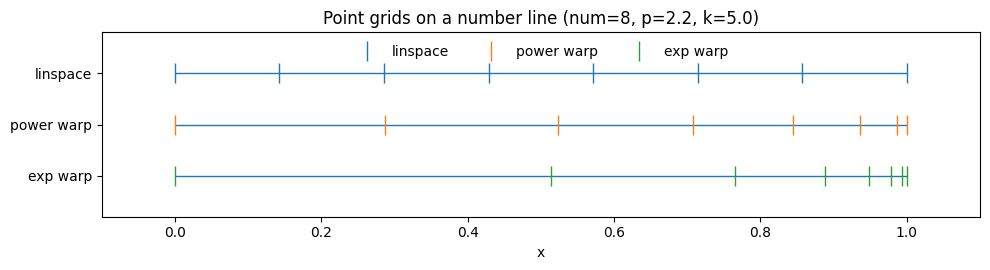

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters you can tweak
start, stop, num = 0.0, 1.0, 8
p = 2.2   # power-law clustering strength (>1 => more near stop)
k = 5.0   # exponential clustering strength (>0 => more near stop)

t = np.linspace(0.0, 1.0, num)

# 1) Power-law warp (clusters near stop)
x_power = stop - (stop - start) * (1 - t)**p

# 2) Exponential warp (clusters near stop)
x_exp = stop - (stop - start) * (np.exp(k*(1 - t)) - 1) / (np.exp(k) - 1)

# Baseline for comparison
x_lin = np.linspace(start, stop, num)

# Plot points on a "number line" (a few stacked lines)
fig, ax = plt.subplots(figsize=(10, 2.8))

levels = {
    "linspace": (x_lin, 2),
    "power warp": (x_power, 1),
    "exp warp": (x_exp, 0),
}

for label, (x, y) in levels.items():
    ax.hlines(y, start, stop, linewidth=1)
    ax.plot(x, np.full_like(x, y), linestyle="None", marker="|",
            markersize=14, label=label)

ax.set_xlim(start-0.1, stop+0.1)
ax.set_ylim(-0.8, 2.8)
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(["exp warp", "power warp", "linspace"])
ax.set_xlabel("x")
ax.set_title(f"Point grids on a number line (num={num}, p={p}, k={k})")
ax.legend(loc="upper center", ncol=3, frameon=False)

plt.tight_layout()
plt.show()


In [ ]:
N = 800

t = 0.
c = 0.

'''
First, an initial guess of where α_c could be, to find for wich α to stop in the production run

Second, min and max values for beta ladder, to capture all behaviours without wasting time.

Both depend on N,t,c, theory here helps.
'''
α_c_min, α_c_max = 0.06, 0.1

T_min,T_max = 0.1, 1.6

#_______________________________________________________________________________________________________#

α_grid_ansatz = np.linspace(α_c_min,α_c_max,8) 
β_min = 1/T_max
β_max = 1/T_min

beta0 = np.geomspace(β_min, β_max, 12) 

fail_streak = 0
my_α = None

In [41]:
α_grid_ansatz[3]

np.float64(0.05928571428571429)

In [39]:
print(np.round(α_grid_ansatz*N))

[30. 34. 39. 43. 47. 51. 56. 60.]


In [ ]:
α_idx = 1
for α in α_grid_ansatz:
    print("Trial number",α_idx)
    α_idx +=1
    run_root = f"runs/find_alpha/N{N}_t{t:.3f}_c{c:.3f}_alpha{α:.5f}"

    P = int(α * N)

    #________ find a good beta ladder but without much care _________# 

    sys0  = SysConfig(N=N, P=P, K=beta0.size, t=t, c=c, β=beta0,
                    mu_to_store=np.array([0]), #useless parameter
                    master_seed=12345, spin_init_mode="random")

    trial = TrialConfig(equilibration_time=5000, sweeps_per_sample=10, n_samples=1000)

    betas, acc = ladder_search_parallel(
        sys_template=sys0, beta_init=beta0,
        trial=trial, R_workers=10, R_total=10,
        A_low=0.2, A_high=0.5+α_idx*0.03, A_star=0.30,
        redistribute_every=2, biased_shrink=0.92, K_max=58, verbose=True,
    )

    beta0 = betas #putting this here means that each α starts from the previous ladder

    #________________ simulate the system cheaply ___________________#

    syscfg = SysConfig(
        N=N, P=P, K=len(betas), t=t, c=c,
        β=betas,
        mu_to_store=np.arange(0,P,1,dtype=np.int64),
        master_seed=121839,
        spin_init_mode="random",
    )

    run = RunConfig(
        run_root=run_root,
        equilibration_time=5000,
        sampling_interval=100,
        chunk_size=1000,
        N_data_target=1000,
    )

    summary = run_pool(
        run,
        sys_for_fresh=syscfg, 
        R_workers=10,
        R_total=10,
        start_method="fork",
    )

    
    #______________________ verify retrieval _________________________#
    
    res = analyze_retrieval_weight(
        run_root,
        m0=0.80,
        rho0=0.40,
        p_cross=0.50,
        make_plots=False,
    )

    w_cold = res["w_per_disorder"][:, 0]          #this is w at the lowest temperature
    n_retr = int(np.count_nonzero(w_cold >= 0.5)) 
    success = (n_retr >= 2)

    if success:
        fail_streak = 0
    else:
        fail_streak += 1
        if fail_streak == 2:
            my_α = α
        if fail_streak == 3:
            break

if my_α is None:
    # retrieval everywhere in this window
    my_α = α_grid_ansatz[-1]

print(my_α)

Trial number 1
pass  1 | K=12 | acc_med=[0.143 0.004 0.003 0.004 0.001 0.026 0.135 0.345 0.628 0.797 0.947]
＋ insert after iface 0
＋ insert after iface 1
＋ insert after iface 2
＋ insert after iface 3
＋ insert after iface 4
＋ insert after iface 5
＋ insert after iface 6
pass  2 | K=19 | acc_med=[0.522 0.409 0.167 0.142 0.103 0.171 0.127 0.165 0.065 0.169 0.199 0.347
 0.385 0.537 0.375 0.680 0.863 0.957]
↺ reshape (fixed K)
pass  3 | K=19 | acc_med=[0.667 0.696 0.729 0.717 0.644 0.551 0.460 0.459 0.469 0.382 0.294 0.203
 0.133 0.016 0.016 0.010 0.098 0.701]
＋ insert after iface 12
＋ insert after iface 13
＋ insert after iface 14
＋ insert after iface 15
＋ insert after iface 16
pass  4 | K=24 | acc_med=[0.665 0.695 0.729 0.715 0.644 0.544 0.458 0.458 0.467 0.385 0.299 0.205
 0.436 0.468 0.259 0.287 0.185 0.301 0.114 0.312 0.246 0.608 0.704]
↺ reshape (fixed K)
pass  5 | K=24 | acc_med=[0.221 0.116 0.136 0.239 0.339 0.433 0.479 0.499 0.502 0.474 0.360 0.371
 0.405 0.446 0.532 0.580 0.565 0.54

In [ ]:
'''
Now we simulate the system for real, stopping at the α we found.
'''
α_start = 0.01
α_stop  = my_α
num_α   = 8
# Power-law warp (clusters near stop)
α_grid = α_stop - (α_stop - α_start) * (1 - np.linspace(0.0, 1.0, num))**2.2 


for α in α_grid:

    P = int(α * N)

    #________ find a good beta ladder with more care _________# 

    beta0 = np.geomspace(β_min, β_max, 12)
    sys0  = SysConfig(N=N, P=P, K=beta0.size, t=t, c=c, β=beta0,
                    mu_to_store=np.array([0]), #useless parameter
                    master_seed=12345, spin_init_mode="random")

    trial = TrialConfig(equilibration_time=5000, sweeps_per_sample=20, n_samples=1000)

    betas, acc = ladder_search_parallel(
        sys_template=sys0, beta_init=beta0,
        trial=trial, R_workers=10, R_total=10,
        A_low=0.22, A_high=0.48, A_star=0.30,
        redistribute_every=2, biased_shrink=0.92, K_max=48, verbose=False,
    )

    #_________________ simulate the system ___________________#

    syscfg = SysConfig(
        N=N, P=P, K=len(betas), t=t, c=c,
        β=betas,
        mu_to_store=np.arange(0,P,1,dtype=np.int64),
        master_seed=121839,
        spin_init_mode="random",
    )

    run = RunConfig(
        run_root="runs/%f{αtc}_pool",
        equilibration_time=5000,
        sampling_interval=100,
        chunk_size=2000,
        N_data_target=8000,
    )

    summary = run_pool(
        run,
        sys_for_fresh=syscfg, 
        R_workers=10,
        R_total=10,
        start_method="fork",
    )

In [41]:
N = 700
α = 0.04

P = int(α*N)
P

28

In [42]:
betas0 = np.geomspace(0.55, 9, 18)
sys0  = SysConfig(N=N, P=P, K=betas0.size, t=0.,c=0, β=betas0,
                  mu_to_store=np.array([0]), #useless parameter
                  master_seed=12345, spin_init_mode="random")

trial = TrialConfig(equilibration_time=6000, sweeps_per_sample=10, n_samples=500)

betas1, acc_stack1, I_ts_stack1 = ladder_search_parallel(
    sys_template=sys0, beta_init=betas0,
    trial=trial, R_workers=10, R_total=10,

    A_low=0.14, A_high=0.48, A_star=0.36,
    q_lo=0.10,                 # fix 
    redistribute_every=2,      # number of inserts after which a reshape triggers in the next pass, this triggers very rarely
    low_max_for_reshape = 4,   # max number of lows to still trigger a reshape before the inserts can trigger
    n_hot = 0,                 # number of high T interfaces that ignore the high mask
    max_insert = 3,            # max number of inserts allowed between reshapes

    gamma_reshape=0.5,clip_reshape=(0.75, 1.35), # reshape strength and constraints on the stretching of Δβ_k

    K_max=45, max_passes=10, verbose=True, start_method = "fork"
)

 
 
pass  1 | K=18 | 
 
acc_trig=[52 31  8  3  3  5  5  0  6 13 22 35 48 68 75 87 91]
 
acc_low= [52 29  7  2  3  4  2  0  5 13 19 20 26 33 66 69 72]
 
＋ insert after iface 2
＋ insert after iface 3
＋ insert after iface 4
 
 
pass  2 | K=21 | 
 
acc_trig=[52 30 41 34 25 28 26 31  4  5  0  6 14 24 36 41 57 75 88 88]
 
acc_low= [51 29 40 33 24 28 25 31  4  2  0  5 14 19 23 25 29 65 79 77]
 
↺ reshape (fixed K)
 
 
pass  3 | K=21 | 
 
acc_trig=[46 35 43 38 33 33 32 34 12 12  6  2  8 14 23 36 52 56 75 74]
 
acc_low= [46 33 40 37 33 33 30 33 12 11  3  1  7 13 19 22 29 34 10 43]
 
＋ insert after iface 8
＋ insert after iface 9
＋ insert after iface 10
 
 
pass  4 | K=24 | 
 
acc_trig=[46 35 42 38 33 33 32 34 41 45 41 45 38 30  2  8 14 22 36 55 57 80 91]
 
acc_low= [45 33 40 37 33 32 31 34 41 45 41 44 35 22  1  7 14 19 22 26 34 43 77]
 
↺ reshape (fixed K)
 
 
pass  5 | K=24 | 
 
acc_trig=[41 35 39 37 35 36 34 35 39 41 40 42 37 30  8 13 16 20 29 45 41 74 62]
 
acc_low= [40 33 37 36 35 35 34 34 3

In [44]:
def pt_diagnostics_report(
    I_ts_stack,
    betas=None,
    acc_stack=None,
    *,
    q_lo=0.20,                  # disorder-guard quantile for acceptance summaries
    burn_in=0,                  # int steps, or float fraction in (0,1)
    chains=(0, 1),              # which independent chains to analyze (if present)
    plot_disorders=10,           # how many representative disorders to plot as lines
    trace_walkers=6,            # how many walkers to show in k_w(t) traces
    trace_disorder="worst",     # "worst" | "median" | int disorder index
    trace_chain=0,
    save_prefix=None,           # e.g. "diag_" -> saves diag_*.png
    show=True,
):
    """
    Drop-in PT diagnostics from I_ts (slot->walker time series) and optional acc_stack.

    Expected shapes:
      - I_ts_stack: (R, B, T, K) or (B, T, K) or (T, K)
      - acc_stack : (R, K-1) or (K-1,) (optional)

    Returns a dict of computed metrics (arrays are numpy).
    Produces plots (matplotlib) unless show=False.
    """


    # ---------- normalize input shapes ----------
    I = np.asarray(I_ts_stack)
    if I.ndim == 4:
        R, B, T, K = I.shape
    elif I.ndim == 3:
        R = 1
        B, T, K = I.shape
        I = I[None, ...]
    elif I.ndim == 2:
        R = 1
        B = 1
        T, K = I.shape
        I = I[None, None, ...]
    else:
        raise ValueError("I_ts_stack must have shape (R,B,T,K), (B,T,K), or (T,K).")

    if betas is None:
        beta = None
    else:
        beta = np.asarray(betas, float)
        if beta.shape[0] != K:
            raise ValueError(f"betas length {beta.shape[0]} does not match K={K}.")

    # burn-in
    if isinstance(burn_in, float):
        if not (0.0 <= burn_in < 1.0):
            raise ValueError("burn_in as float must be in [0,1).")
        t0 = int(np.floor(burn_in * T))
    else:
        t0 = int(burn_in)
    t0 = max(0, min(t0, T - 1))
    Teff = T - t0

    temperatures = np.sort(1/np.asarray(betas))


    # chains to analyze
    chains = tuple(int(c) for c in chains)
    for c in chains:
        if not (0 <= c < B):
            raise ValueError(f"chain index {c} out of range for B={B}.")

    hot_k, cold_k = 0, K - 1

    # ---------- helpers ----------
    def _roundtrips_from_ends(w_hot, w_cold, K):
        """
        Hot-based round trips: hot->cold->hot for each walker.
        Returns (rt_times list, n_rt, rt_rate).
        """
        t_hot_start = np.full(K, -1, dtype=np.int64)
        seen_cold   = np.zeros(K, dtype=np.bool_)
        rts = []

        for t in range(w_hot.shape[0]):
            wh = int(w_hot[t])
            wc = int(w_cold[t])

            # cold visit marks success-in-between if a hot-start exists
            if t_hot_start[wc] != -1:
                seen_cold[wc] = True

            # hot visit closes a round trip if cold was seen
            if t_hot_start[wh] != -1 and seen_cold[wh]:
                rts.append(t - t_hot_start[wh])

            # (re)start from hot
            t_hot_start[wh] = t
            seen_cold[wh] = False

        n_rt = len(rts)
        rt_rate = n_rt / max(1, w_hot.shape[0])
        return rts, n_rt, rt_rate

    def _passages_from_ends(w_hot, w_cold, K):
        """
        One-way end-to-end passage times:
          - hot->cold and cold->hot, using "last end visited" timestamps per walker.
        Returns two lists: tau_hc, tau_ch.
        """
        last_end = np.zeros(K, dtype=np.int8)     # 0 none, +1 hot, -1 cold
        last_t   = np.full(K, -1, dtype=np.int64)

        tau_hc = []
        tau_ch = []

        for t in range(w_hot.shape[0]):
            wh = int(w_hot[t])
            wc = int(w_cold[t])

            # cold hit
            if last_end[wc] == +1:
                tau_hc.append(t - last_t[wc])
            last_end[wc] = -1
            last_t[wc] = t

            # hot hit
            if last_end[wh] == -1:
                tau_ch.append(t - last_t[wh])
            last_end[wh] = +1
            last_t[wh] = t

        return tau_hc, tau_ch

    def _flow_profile_f(I_bt):
        """
        Directional flow profile f(k) from one chain:
        I_bt: (Teff, K) slot->walker.
        Implements:
          label walker by last end visited: +1 (hot), -1 (cold), 0 unknown.
          f(k) = P(label=+1 | at slot k), estimated over time, excluding unknown labels.
        Returns:
          f: (K,) with NaNs possible if denom=0 at a slot (unlikely)
          denom: (K,) number of labeled samples accumulated at each slot
        """
        labels = np.zeros(K, dtype=np.int8)  # per walker: 0 unknown, +1 hot, -1 cold
        num = np.zeros(K, dtype=np.float64)
        den = np.zeros(K, dtype=np.float64)

        for t in range(I_bt.shape[0]):
            wh = int(I_bt[t, hot_k])
            wc = int(I_bt[t, cold_k])
            labels[wh] = +1
            labels[wc] = -1

            lab_slots = labels[I_bt[t]]  # (K,)
            known = (lab_slots != 0)
            den[known] += 1.0
            num[known] += (lab_slots[known] == +1)

        f = np.full(K, np.nan, dtype=np.float64)
        mask = den > 0
        f[mask] = num[mask] / den[mask]
        return f, den

    def _invert_perm(I_t):
        """Given I_t (K,) slot->walker, return k_of_w (K,) walker->slot."""
        k_of_w = np.empty(K, dtype=np.int16)
        k_of_w[I_t.astype(np.int64)] = np.arange(K, dtype=np.int16)
        return k_of_w

    def _backtracking_rho1(I_bt, walkers=None):
        """
        Backtracking correlation rho1 = Corr(delta k(t), delta k(t+1)) for selected walkers,
        where k_w(t) is walker position (slot index).
        Returns:
          rho_w: (len(walkers),) rho1 per walker (NaN if too few moves)
          rho_med: median rho1 ignoring NaNs
        """
        Te = I_bt.shape[0]
        if walkers is None:
            walkers = np.arange(K, dtype=np.int64)
        else:
            walkers = np.asarray(walkers, dtype=np.int64)

        # build k_w(t) for selected walkers only, streaming
        k_prev = _invert_perm(I_bt[0])[walkers].astype(np.int16)
        dk_prev = None
        xs = [[] for _ in range(walkers.size)]
        ys = [[] for _ in range(walkers.size)]

        for t in range(1, Te):
            k_now = _invert_perm(I_bt[t])[walkers].astype(np.int16)
            dk = (k_now - k_prev).astype(np.int16)
            if dk_prev is not None:
                for i in range(walkers.size):
                    xs[i].append(int(dk_prev[i]))
                    ys[i].append(int(dk[i]))
            dk_prev = dk
            k_prev = k_now

        rho = np.full(walkers.size, np.nan, dtype=np.float64)
        for i in range(walkers.size):
            x = np.array(xs[i], dtype=np.float64)
            y = np.array(ys[i], dtype=np.float64)
            if x.size >= 10 and np.std(x) > 0 and np.std(y) > 0:
                rho[i] = np.corrcoef(x, y)[0, 1]
        rho_med = np.nanmedian(rho)
        return rho, rho_med

    # ---------- compute per-disorder, per-chain metrics ----------
    rt_count = np.zeros((R, B), dtype=np.int64)
    rt_rate  = np.zeros((R, B), dtype=np.float64)
    rt_med   = np.full((R, B), np.nan, dtype=np.float64)

    tau_hc_med = np.full((R, B), np.nan, dtype=np.float64)
    tau_ch_med = np.full((R, B), np.nan, dtype=np.float64)

    f_prof = np.full((R, B, K), np.nan, dtype=np.float64)
    f_slope_max = np.full((R, B), np.nan, dtype=np.float64)

    rho1_med = np.full((R, B), np.nan, dtype=np.float64)

    for r in range(R):
        for b in chains:
            I_bt = I[r, b, t0:, :].astype(np.int64)  # (Teff,K)
            w_hot  = I_bt[:, hot_k]
            w_cold = I_bt[:, cold_k]

            rts, nrt, rate = _roundtrips_from_ends(w_hot, w_cold, K)
            rt_count[r, b] = nrt
            rt_rate[r, b]  = rate
            if rts:
                rt_med[r, b] = float(np.median(np.array(rts, dtype=np.int64)))

            tau_hc, tau_ch = _passages_from_ends(w_hot, w_cold, K)
            if tau_hc:
                tau_hc_med[r, b] = float(np.median(np.array(tau_hc, dtype=np.int64)))
            if tau_ch:
                tau_ch_med[r, b] = float(np.median(np.array(tau_ch, dtype=np.int64)))

            f, _den = _flow_profile_f(I_bt)
            f_prof[r, b, :] = f
            if np.all(np.isnan(f)):
                f_slope_max[r, b] = np.nan
            else:
                df = np.diff(f)
                f_slope_max[r, b] = np.nanmax(np.abs(df))

            # backtracking correlation on a small subset of walkers (cheap + informative)
            walkers = np.linspace(0, K - 1, min(trace_walkers, K), dtype=np.int64)
            _rho, rho_med_val = _backtracking_rho1(I_bt, walkers=walkers)
            rho1_med[r, b] = rho_med_val

    # ---------- acceptance aggregation (optional) ----------
    acc_summary = None
    if acc_stack is not None:
        A = np.asarray(acc_stack, float)
        if A.ndim == 1:
            if A.shape[0] != K - 1:
                raise ValueError("acc_stack length must be K-1.")
            acc_med = A.copy()
            acc_lo  = A.copy()
            acc_hi  = A.copy()
        elif A.ndim == 2:
            if A.shape[1] != K - 1:
                raise ValueError("acc_stack must have shape (R,K-1).")
            acc_med = np.quantile(A, 0.50, axis=0)
            acc_lo  = np.quantile(A, q_lo, axis=0)
            acc_hi  = np.quantile(A, 1.0 - q_lo, axis=0)
        else:
            raise ValueError("acc_stack must be shape (K-1,) or (R,K-1).")

        acc_summary = dict(acc_med=acc_med, acc_lo=acc_lo, acc_hi=acc_hi)

    # ---------- choose representative disorders ----------
    # Use median over analyzed chains of rt_rate to rank disorders
    rt_rate_used = np.nanmedian(rt_rate[:, list(chains)], axis=1)
    worst_r = int(np.nanargmin(rt_rate_used))
    best_r  = int(np.nanargmax(rt_rate_used))
    med_r   = int(np.argsort(rt_rate_used)[len(rt_rate_used)//2]) if R > 1 else 0

    if trace_disorder == "worst":
        trace_r = worst_r
    elif trace_disorder == "median":
        trace_r = med_r
    elif isinstance(trace_disorder, int):
        trace_r = int(trace_disorder)
    else:
        raise ValueError("trace_disorder must be 'worst', 'median', or an int index.")

    reps = [worst_r, med_r, best_r]
    reps = reps[:min(plot_disorders, len(reps))]

    # ---------- plots ----------
    figs = []

    # 1) Acceptance per interface (median/low/high quantiles across disorders)
    if acc_summary is not None:
        fig = plt.figure(figsize=(7, 3.8))
        x = np.arange(K - 1)
        plt.axhline(0.2, linestyle="--")
        plt.plot(x,A.min(axis=0), marker="o", linestyle=":", label="acc min")
        plt.plot(x, acc_summary["acc_med"], marker="o", linestyle="-", label="acc median")
        plt.plot(x, acc_summary["acc_lo"],  marker="o", linestyle="--", label=f"acc q={q_lo:.2f}")
        plt.plot(x, acc_summary["acc_hi"],  marker="o", linestyle="--", label=f"acc q={1-q_lo:.2f}")
        plt.xlabel("interface k (between β_k and β_{k+1})")
        plt.ylabel("acceptance")
        plt.title("Swap acceptance summaries across disorder")
        plt.legend()
        plt.tight_layout()
        figs.append(("acceptance", fig))

    # 2) Round-trip rate per disorder (scatter)
    fig = plt.figure(figsize=(7, 3.8))

    rate1 = 100 / max(1, Teff)
    rate2 = 2/ max(1, Teff)
    plt.axhline(rate1, linestyle="--",label=f"{100} round trips")
    plt.axhline(rate2, linestyle="--",label=f"{2} round trips")
    x = np.arange(R)
    for b in chains:
        plt.plot(x, rt_rate[:, b], marker="o", linestyle="none", label=f"chain {b}")
    plt.xlabel("disorder index r")
    plt.ylabel("round trips per step")
    plt.title(f"Round-trip rate (burn-in t0={t0}, Teff={Teff})")
    #plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    figs.append(("rt_rate", fig))

    # 3) Round-trip time median per disorder
    fig = plt.figure(figsize=(7, 3.8))
    for b in chains:
        plt.plot(x, rt_med[:, b], marker="o", linestyle="none", label=f"chain {b}")
    plt.xlabel("disorder index r")
    plt.ylabel("median RT time (steps)")
    plt.title("Median hot→cold→hot round-trip time")
    #plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    figs.append(("rt_median_time", fig))

    order = np.argsort(rt_rate_used)          # worst -> best
    mid = len(order) // 2

    groups = {
        "worst 3": order[:3],
        "median ±1": order[max(0, mid-1):min(len(order), mid+2)],
        "best 3": order[-3:],
    }

    x = np.arange(K)  # slot index; or use beta / (1/beta) if you want later

    fig, axes = plt.subplots(1, 3, figsize=(12, 3.8), sharey=True)
    for ax, (title, idxs) in zip(axes, groups.items()):
        for r in idxs:
            for b in chains:
                ax.plot(x, f_prof[r, b], marker="o", linestyle="-", label=f"r={r}, b={b}")
        ax.set_title(title)
        ax.set_xlabel("slot k (0 hot → K-1 cold)")
    axes[0].set_ylabel("f(k)")
    axes[0].legend(ncol=1, fontsize=8)
    plt.tight_layout()
    figs.append(("flow_groups", fig))


    # 5) Heatmap of f(k) across disorders (one chain)
    if R > 1:
        fig = plt.figure(figsize=(7, 4.2))
        M = f_prof[:, trace_chain, :]
        plt.imshow(M, aspect="auto", interpolation="nearest")
        plt.colorbar(label="f(k)")
        plt.xlabel("temperature slot k")
        plt.ylabel("disorder index r")
        plt.title(f"f(k) heatmap across disorders (chain {trace_chain})")
        plt.tight_layout()
        figs.append(("flow_heatmap", fig))

    # 6) Walker traces k_w(t) for a few walkers in a chosen disorder
    # This is where k_ts matters: for visualization/debug of "bouncing"/plateaus.
    fig = plt.figure(figsize=(7, 4.2))
    I_bt = I[trace_r, trace_chain, t0:, :].astype(np.int64)
    Te = I_bt.shape[0]
    walkers = np.linspace(0, K - 1, min(trace_walkers, K), dtype=np.int64)

    # build k_w(t) for selected walkers
    k_tr = np.empty((Te, walkers.size), dtype=np.int16)
    for t in range(Te):
        k_of_w = _invert_perm(I_bt[t])
        k_tr[t, :] = k_of_w[walkers]

    t_axis = np.arange(Te)
    for i, w in enumerate(walkers):
        plt.plot(t_axis, k_tr[:, i], linestyle="-", label=f"w={int(w)}")
    plt.xlabel("time step (post burn-in)")
    plt.ylabel("temperature slot k_w(t)")
    plt.title(f"Walker temperature trajectories (r={trace_r}, chain={trace_chain})")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    figs.append(("walker_traces", fig))

    # 7) Backtracking (rho1) per disorder
    fig = plt.figure(figsize=(7, 3.8))
    for b in chains:
        plt.plot(np.arange(R), rho1_med[:, b], marker="o", linestyle="none", label=f"chain {b}")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("disorder index r")
    plt.ylabel("median ρ₁ over sampled walkers")
    plt.title("Backtracking indicator: Corr(Δk(t), Δk(t+1))")
    plt.legend()
    plt.tight_layout()
    figs.append(("backtracking", fig))

    # ---------- save / show ----------
    if save_prefix is not None:
        for name, fig in figs:
            fig.savefig(f"{save_prefix}{name}.png", dpi=150)

    if show:
        plt.show()
    else:
        # avoid GUI side effects; caller can manage figures
        pass

    # ---------- return metrics ----------
    out = dict(
        shape=dict(R=R, B=B, T=T, K=K, burn_in=t0, Teff=Teff),
        betas=beta,
        acc_summary=acc_summary,
        rt_count=rt_count,
        rt_rate=rt_rate,
        rt_med=rt_med,
        tau_hc_med=tau_hc_med,
        tau_ch_med=tau_ch_med,
        f_profile=f_prof,
        f_slope_max=f_slope_max,
        rho1_med=rho1_med,
        representative=dict(worst=worst_r, median=med_r, best=best_r, trace=trace_r),
    )
    return out


In [46]:
sys1  = SysConfig(N=N, P=P, K=betas1.size, t=0.,c=0, β=betas1,
                  mu_to_store=np.array([0]), #useless parameter
                  master_seed=12345, spin_init_mode="random")

trial1 = TrialConfig(equilibration_time=6000, sweeps_per_sample=50, n_samples=1200)


results = pool_orchestrator_stats(sys1, trial1, R_workers=10, R_total=10, start_method="fork")

acc_stack1   = np.stack([r.acc_edge for r in results], axis=0)  # (R, K-1)
I_ts_stack1  = np.stack([r.I_ts for r in results], axis=0)      # (R, B, T, K)

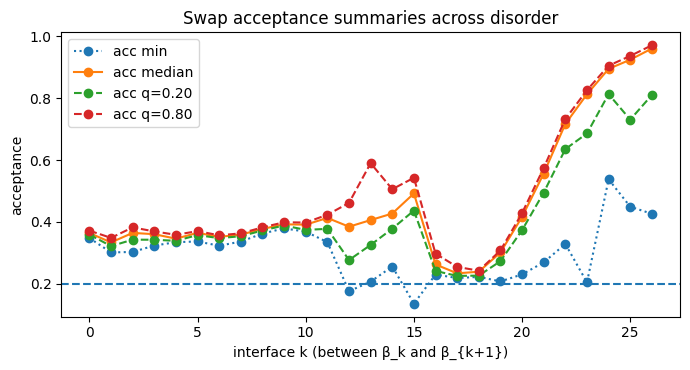

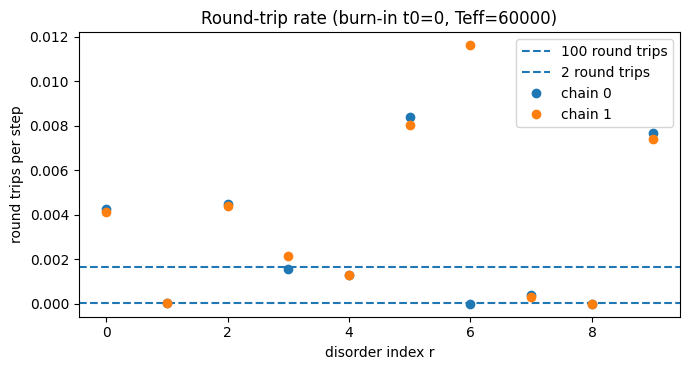

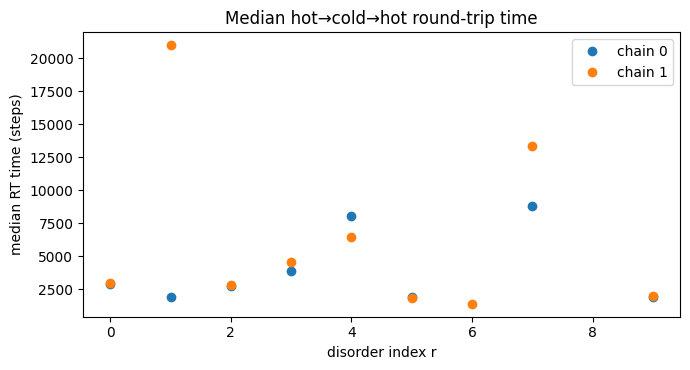

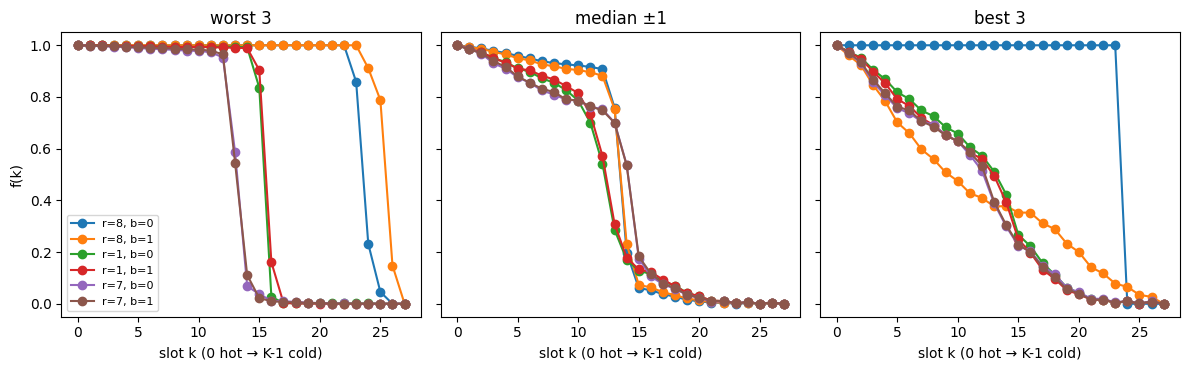

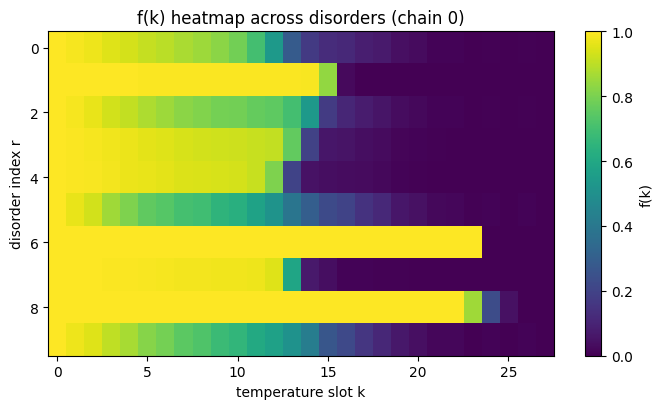

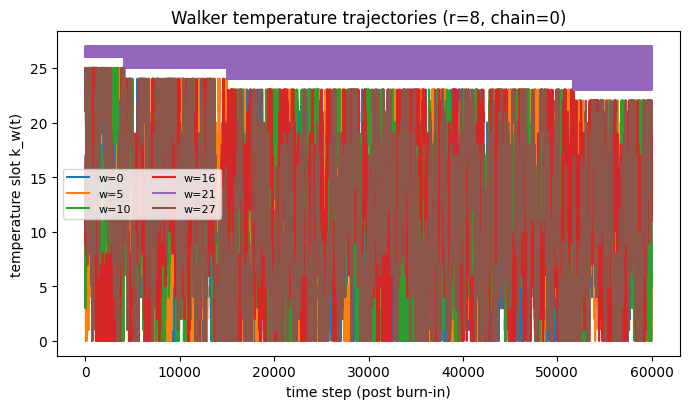

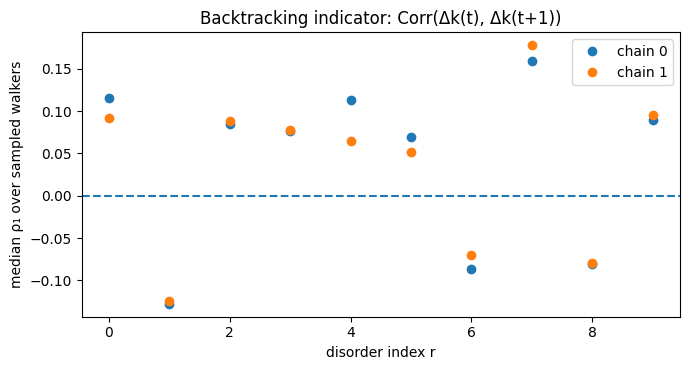

In [47]:
out=pt_diagnostics_report(
    I_ts_stack1,
    betas1,
    acc_stack1)

In [48]:
import numpy as np
from dataclasses import replace

def refine_ladder(
    sys_template,                  # SysConfig without β fixed
    beta_proposed: np.ndarray,      # 1D array (K,)
    trial,                          # TrialConfig
    R_workers: int, R_total: int,   # pool knobs (disorders)
    A_low=0.20,
    eps=0.01,                      # hysteresis margin
    max_insert=4,
    K_max=64, max_passes=2, verbose=True, start_method="fork"
):
    """
    Refine a proposed ladder by inserting at the WORST interface across disorders:
        acc_min[k] = min_r acc_stack[r,k]
    until acc_min[k] >= A_low - 2*eps for all k, or until limits are reached.

    Returns: (betas, acc_stack, I_ts_stack) from the last evaluation.
    """

    betas = np.asarray(beta_proposed, float).copy()
    inserts = 0

    last_acc_stack = None
    last_I_ts_stack = None

    thr = A_low - 2.0 * eps

    for p in range(1, max_passes + 1):
        sys = replace(sys_template, K=betas.size, β=betas)

        results = pool_orchestrator_stats(
            sys, trial,
            R_workers=R_workers, R_total=R_total,
            start_method=start_method
        )

        acc_stack  = np.stack([r.acc_edge for r in results], axis=0)  # (R_total, K-1)
        I_ts_stack = np.stack([r.I_ts     for r in results], axis=0)  # (R_total, B, T, K)

        last_acc_stack = acc_stack
        last_I_ts_stack = I_ts_stack

        acc_min = acc_stack.min(axis=0)            # (K-1,)
        k_worst = int(np.argmin(acc_min))
        a_worst = float(acc_min[k_worst])

        if verbose:
            print(f"\nrefine pass {p:2d} | K={betas.size:2d} | "
                  f"worst acc_min={a_worst:.4f} at iface {k_worst} | thr={thr:.4f}")

        # success: no single “doomed” interface remains
        if a_worst >= thr:
            if verbose: print("→ refine done (all acc_min above threshold)")
            return betas, acc_stack, I_ts_stack

        # cannot insert further
        if betas.size >= K_max:
            if verbose: print("→ refine stopped (reached K_max)")
            return betas, acc_stack, I_ts_stack

        if inserts >= max_insert:
            if verbose: print("→ refine stopped (reached max_insert)")
            return betas, acc_stack, I_ts_stack

        # insert midpoint at the *current* worst interface
        betas = np.insert(betas, k_worst + 1, 0.5 * (betas[k_worst] + betas[k_worst + 1]))
        inserts += 1
        if verbose: print(f"＋ insert after iface {k_worst}  -> K={betas.size}")

    if verbose: print("→ refine stopped (reached max_passes)")
    return betas, last_acc_stack, last_I_ts_stack


In [49]:
trial1 = TrialConfig(equilibration_time=6000, sweeps_per_sample=50, n_samples=1200)
betas2, last_acc_stack, last_I_ts_stack = refine_ladder(
    sys0,                  # SysConfig without β fixed
    betas1,      # 1D array (K,)
    trial1,                          # TrialConfig
    R_workers=10, R_total=10,   # pool knobs (disorders)
    A_low=0.11,
    eps=0.01,                      # hysteresis margin
    max_insert=4,
    K_max=64, max_passes=7, verbose=True, start_method="fork"
)


refine pass  1 | K=28 | worst acc_min=0.1353 at iface 15 | thr=0.0900
→ refine done (all acc_min above threshold)


In [51]:
betas3, acc_stack3, I_ts_stack3 = refine_ladder(
    sys0,                  # SysConfig without β fixed
    betas2,      # 1D array (K,)
    trial1,                          # TrialConfig
    R_workers=10, R_total=10,   # pool knobs (disorders)
    A_low=0.17,
    eps=0.01,                      # hysteresis margin
    max_insert=4,
    K_max=64, max_passes=7, verbose=True, start_method="fork"
)


refine pass  1 | K=28 | worst acc_min=0.1353 at iface 15 | thr=0.1500
＋ insert after iface 15  -> K=29

refine pass  2 | K=29 | worst acc_min=0.1057 at iface 26 | thr=0.1500
＋ insert after iface 26  -> K=30

refine pass  3 | K=30 | worst acc_min=0.1732 at iface 20 | thr=0.1500
→ refine done (all acc_min above threshold)


In [53]:
sys3  = SysConfig(N=N, P=P, K=betas3.size, t=0.,c=0, β=betas3,
                  mu_to_store=np.array([0]), #useless parameter
                  master_seed=12345, spin_init_mode="random")

trial3 = TrialConfig(equilibration_time=6000, sweeps_per_sample=50, n_samples=2000)

In [54]:
results = pool_orchestrator_stats(sys3, trial3, R_workers=10, R_total=10, start_method="fork")

acc_stack3   = np.stack([r.acc_edge for r in results], axis=0)  # (R, K-1)
I_ts_stack3  = np.stack([r.I_ts for r in results], axis=0)      # (R, B, T, K)

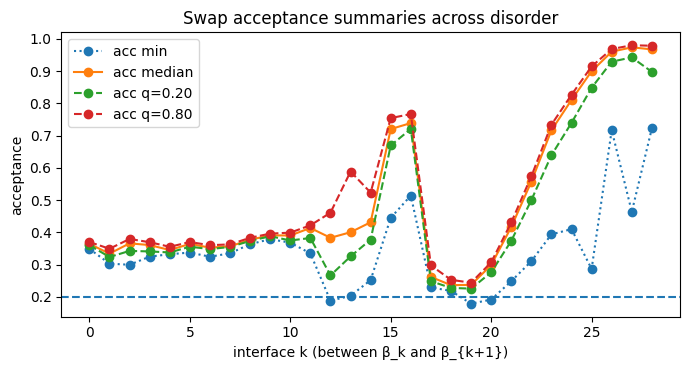

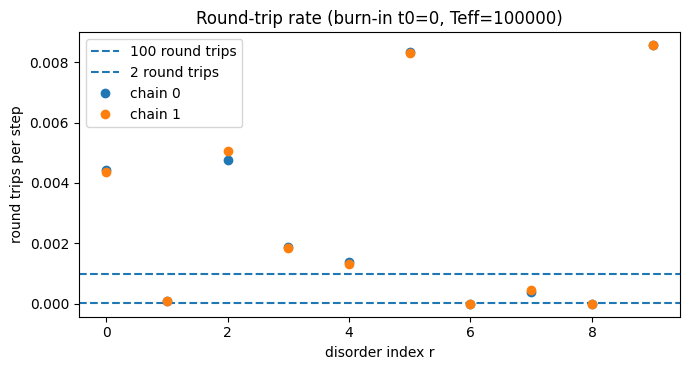

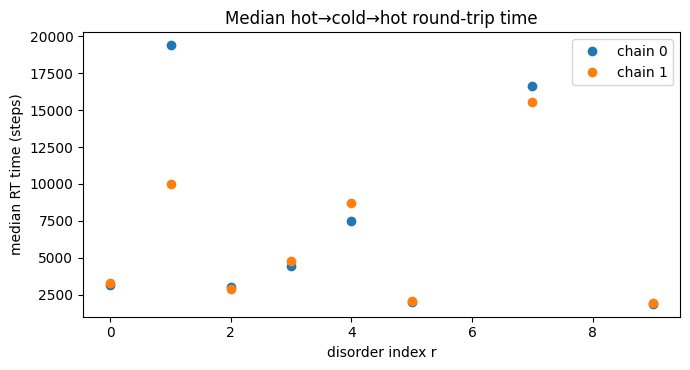

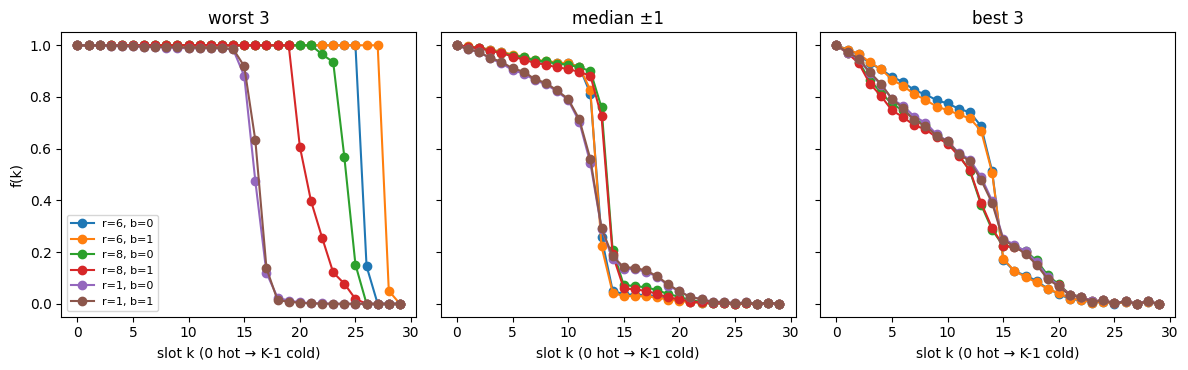

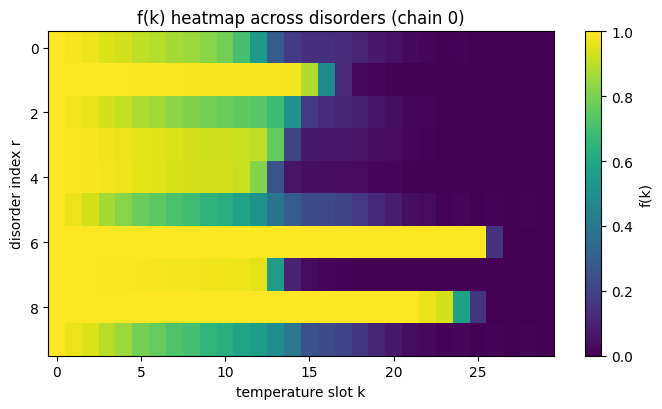

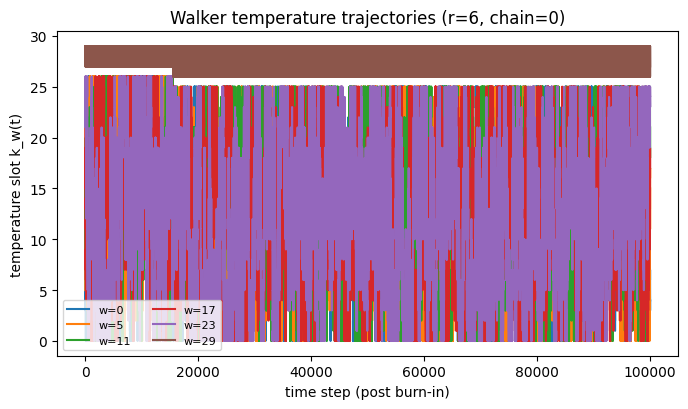

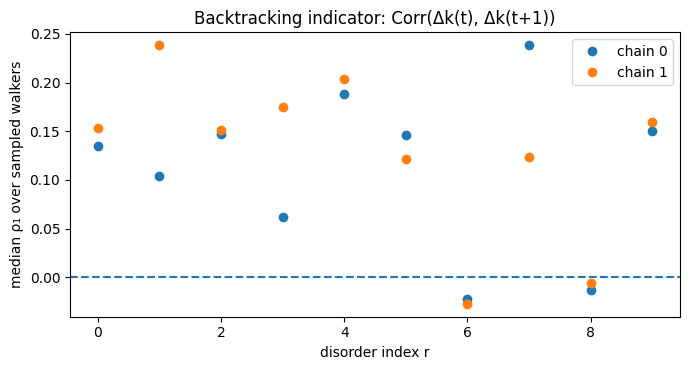

In [56]:
out=pt_diagnostics_report(
    I_ts_stack3,
    betas3,
    acc_stack3)

In [71]:
k_worst

np.int64(25)

In [76]:
acc_min2 = acc_stack2.min(axis=0)
acc_min

array([0.42005 , 0.4206  , 0.410425, 0.38795 , 0.410625, 0.41075 ,
       0.405775, 0.396275, 0.4069  , 0.3994  , 0.403975, 0.412575,
       0.425425, 0.4299  , 0.3985  , 0.35035 , 0.286175, 0.2861  ,
       0.2031  , 0.300975, 0.295375, 0.274175, 0.20125 , 0.165475,
       0.173375, 0.0785  , 0.213175, 0.404675])

In [ ]:
def reshape_run_n(
    sys_template,
    trial,
    betas: np.ndarray,
    acc_stack: np.ndarray,
    I_ts_stack: np.ndarray,
    *,
    n_rounds: int,
    R_workers: int,
    R_total: int,
    A_star: float,
    q_lo: float = 0.20,
    gamma: float = 0.5,
    clip=(0.75, 1.35),
    start_method: str = "fork",
    verbose: bool = True,
):
    """
    Fixed-K loop:
      (1) reshape betas using current acc_stack
      (2) run pilot on the reshaped ladder to get new acc_stack and I_ts_stack
    repeated n_rounds times.

    Requires these to exist in your namespace:
      - reshape_betas_from_acceptance(betas, acc_stack, A_star, q_lo=..., gamma=..., clip=...)
      - pool_orchestrator_stats(sys_now, trial, R_workers, R_total, start_method=...)
      - SysConfig has fields K and β (beta array) compatible with replace()

    Returns: (betas, acc_stack, I_ts_stack) from the *last* pilot run.
    """
    betas = np.asarray(betas, float)

    # Basic shape sanity for acc_stack
    acc_stack = np.asarray(acc_stack, float)
    if acc_stack.ndim != 2:
        raise ValueError("acc_stack must have shape (R, K-1).")
    R, K_minus_1 = acc_stack.shape
    if betas.size != K_minus_1 + 1:
        raise ValueError(f"betas length {betas.size} must equal acc_stack.shape[1]+1 = {K_minus_1+1}.")
    if R != R_total:
        # not fatal, but usually you want them consistent
        if verbose:
            print(f"⚠ acc_stack has R={R} but R_total={R_total}; will use R_total for new pilots.")

    for it in range(int(n_rounds)):
        # --- reshape using current acc_stack ---
        betas = reshape_betas_from_acceptance(
            betas, acc_stack, A_star,
            q_lo=q_lo,
            gamma=gamma,
            clip=clip
        )

        # --- rerun pilot ---
        sys_now = replace(sys_template, K=betas.size, β=betas)
        results = pool_orchestrator_stats(sys_now, trial, R_workers, R_total, start_method=start_method)

        acc_stack  = np.stack([r.acc_edge for r in results], axis=0)  # (R_total, K-1)
        I_ts_stack = np.stack([r.I_ts     for r in results], axis=0)  # (R_total, 2, T, K) in your code

        if verbose:
            acc_lo = np.quantile(acc_stack, q_lo, axis=0)
            acc_md = np.quantile(acc_stack, 0.50, axis=0)
            print(f"[reshape_run_n] iter {it+1}/{n_rounds} | K={betas.size} | "
                  f"acc_lo min={acc_lo.min():.3f} | acc_med min={acc_md.min():.3f} | acc_med max={acc_md.max():.3f}")

    return betas, acc_stack, I_ts_stack


In [ ]:
betas, acc_stack, I_ts_stack = reshape_run_n(
    sys_template=sys0,
    trial=trial,
    betas=betas,
    acc_stack=acc_stack,
    I_ts_stack=I_ts_stack,   # not used by the loop, but kept for symmetry
    n_rounds=5,              
    R_workers=10,
    R_total=10,
    A_star=0.34,
    q_lo=0.10,
    gamma=0.5,
    clip=(0.75, 1.35),
    start_method="fork",
    verbose=True,
)

[reshape_run_n] iter 1/5 | K=20 | acc_lo min=0.352 | acc_med min=0.373 | acc_med max=0.487
[reshape_run_n] iter 2/5 | K=20 | acc_lo min=0.357 | acc_med min=0.376 | acc_med max=0.485
[reshape_run_n] iter 3/5 | K=20 | acc_lo min=0.355 | acc_med min=0.380 | acc_med max=0.476
[reshape_run_n] iter 4/5 | K=20 | acc_lo min=0.362 | acc_med min=0.380 | acc_med max=0.465
[reshape_run_n] iter 5/5 | K=20 | acc_lo min=0.357 | acc_med min=0.385 | acc_med max=0.449


ValueError: x and y must have same first dimension, but have shapes (20,) and (10,)

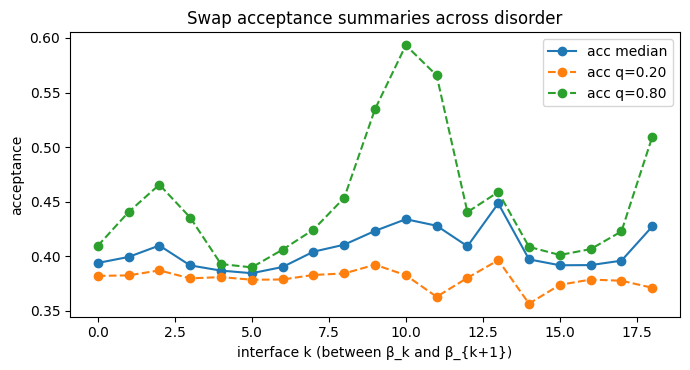

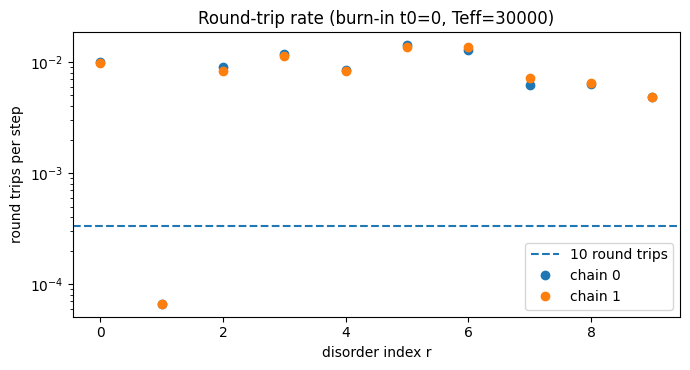

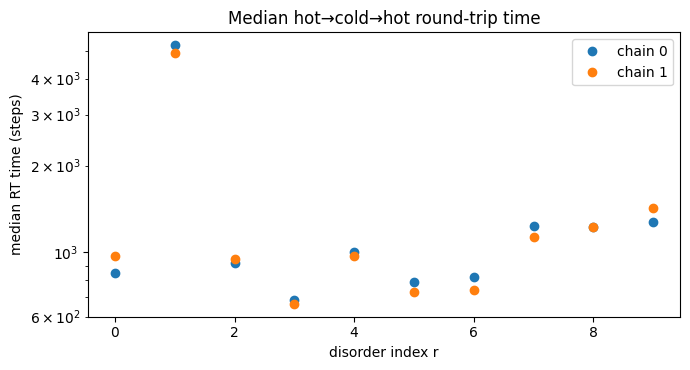

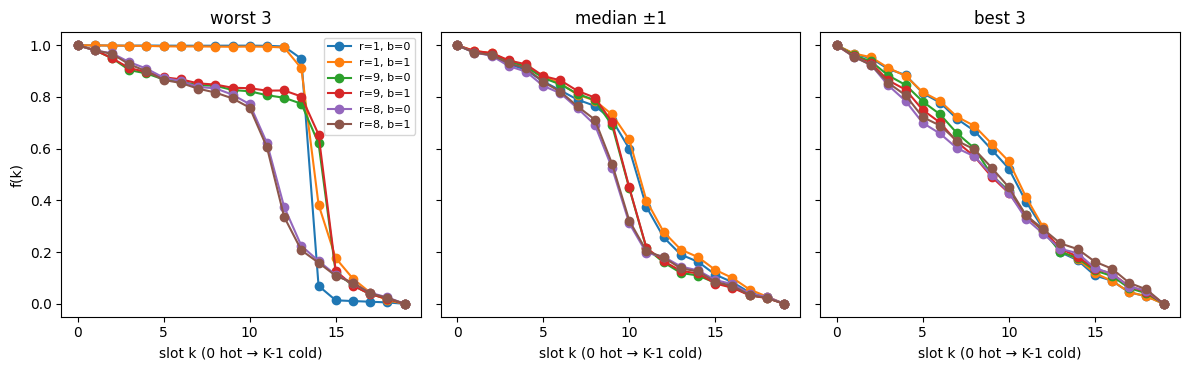

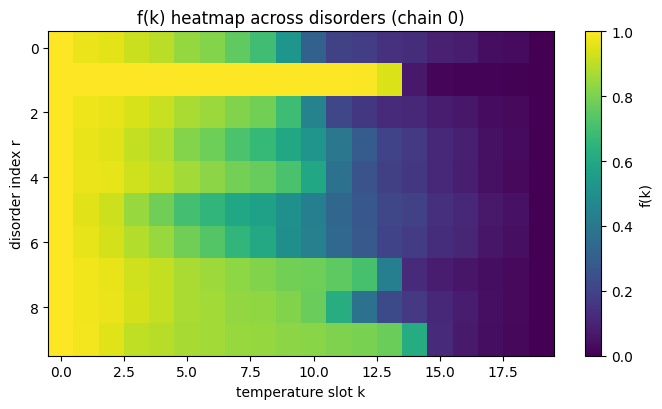

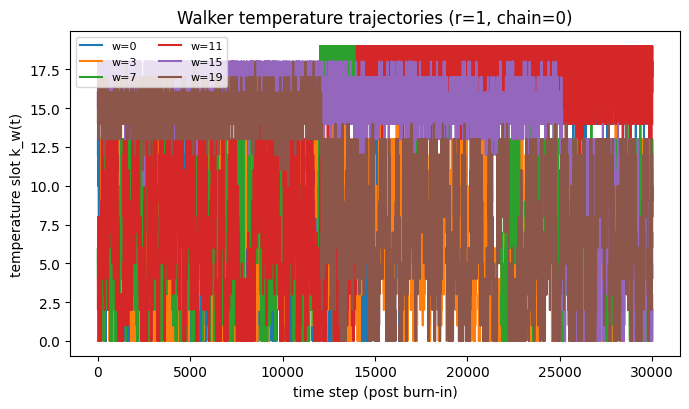

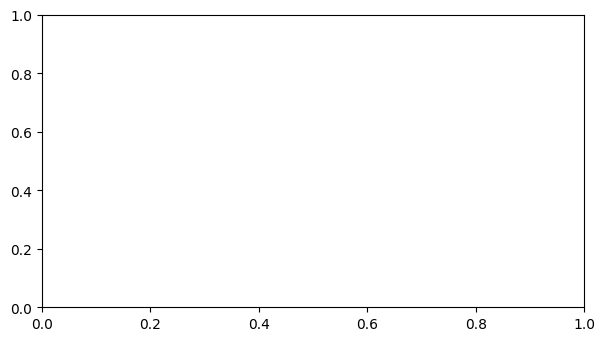

In [ ]:
out=pt_diagnostics_report(
    I_ts_stack,
    betas,
    acc_stack)

In [ ]:

 
acc_trig=[40 43 30 17 24 20 26 12 17 20 35 39 54 36 65 87 96]
 
acc_low= [39 42 28 17 23 18 23  7 14 15 31 36 52 33 61 84 95]
 
 
acc_trig=[57 62 60 47 39 32 35 39 40 30 18 13 19 10 18 56 92]
 
acc_low= [56 62 59 44 37 32 35 37 38 27 12 10  8  9 16 49 90]
 

 
acc_trig=[47 50 45 32 32 28 32 34 32 15 18 20 29 19 37 80 95]
 
acc_low= [46 49 42 30 31 27 31 31 29 12 16  9 27 18 32 76 94]

pass  1 | K=12 | 
 
acc_trig=[40  7  1  2  0  3 14 36 65 87 96]
 
acc_low= [39  5  1  1  0  2 13 33 61 84 94]
 
＋ insert after iface 1
＋ insert after iface 2
＋ insert after iface 3
＋ insert after iface 4
＋ insert after iface 5
＋ insert after iface 6
 
 
pass  2 | K=18 | 
 
acc_trig=[40 43 30 17 24 20 26 12 17 20 35 39 54 36 65 87 96]
 
acc_low= [39 42 28 17 23 18 23  7 14 15 31 36 52 33 61 84 95]
 
↺ reshape (fixed K)
 
 
pass  3 | K=18 | 
 
acc_trig=[47 50 45 32 32 28 32 34 32 15 18 20 29 19 37 80 95]
 
acc_low= [46 49 42 30 31 27 31 31 29 12 16  9 27 18 32 76 94]
 
＋ insert after iface 9
＋ insert after iface 10
＋ insert after iface 11
＋ insert after iface 13
 
 
pass  4 | K=22 | 
 
acc_trig=[47 50 45 32 32 28 32 34 32 49 49 48 53 48 56 29 44 59 39 81 95]
 
acc_low= [46 49 42 30 31 27 31 32 29 41 43 44 51 41 53 27 43 58 34 75 93]
 
↺ reshape (fixed K)
 
 
pass  5 | K=22 | 
 
acc_trig=[50 52 51 44 39 37 37 39 42 57 54 44 42 41 44 29 35 45 31 68 94]
 
acc_low= [49 51 48 42 39 36 37 38 40 54 52 37 36 39 39 24 34 42 27 60 92]
 
↺ reshape (fixed K)
 
 
pass  6 | K=22 | 
 
acc_trig=[51 52 52 49 45 43 42 43 45 54 55 52 48 40 42 33 31 35 23 44 91]
 
acc_low= [50 51 50 46 44 42 42 42 43 52 53 48 42 33 39 25 28 34 22 37 89]
 
↺ reshape (fixed K)
 
 
pass  7 | K=22 | 
 
acc_trig=[48 49 49 48 47 45 45 45 47 51 52 51 49 46 45 42 36 35 25 28 85]
 
acc_low= [48 47 46 45 46 45 44 44 45 49 49 46 45 40 42 36 31 34 24 23 82]
 
↺ reshape (fixed K)

In [38]:
np.set_printoptions(precision=17, suppress=False, linewidth=np.inf)
print("\nBetas (Copy-Paste List):")
print(betas.tolist())


Betas (Copy-Paste List):
[0.45, 0.5085676850102023, 0.563488290077967, 0.6164344055376475, 0.6677771036082569, 0.7178889426957559, 0.7667090274618114, 0.8142555255786177, 0.8609188219884307, 0.9077417045907056, 0.956372714940058, 1.0078708634204647, 1.0627916985581587, 1.1217449653046927, 1.1852472253640887, 1.2538512530163077, 1.328587351597732, 1.4097918828764853, 1.4984820956752858, 1.5950270297814186, 1.7002643466873757, 1.8176249608103994, 1.9479628948857173, 2.0920765297556323, 2.2522910562823726, 2.4332106569579173, 2.638364639372214, 2.8686073054054027, 3.130683769688382, 3.429512684228282, 3.770582038783571, 4.169473101946546, 4.645994575091737, 5.2205733003429, 5.905120469200906, 6.7234588845236205, 7.731823689900172, 8.999999999999998]


In [ ]:
"""
betas = np.array([0.45, 0.5353611406381298, 0.6207222812762596, 0.6919646166758352, 0.7632069520754108, 0.8281140699651589, 0.893021187854907, 0.9520729699039684, 1.0111247519530298, 1.0700982182996446, 1.1290716846462594, 1.196446356374675, 1.2638210281030904, 1.3432699384057638, 1.4227188487084372, 1.5169884026532765, 1.611257956598116, 1.714803506533396, 1.8183490564686762, 1.9200992593832766, 2.021849462297877, 2.1274913795195474, 2.233133296741218, 2.4342728989936764, 2.6324313012301683, 2.8609457104445006, 3.1406833150576525, 3.5048484247526166, 4.0533637054911855, 4.913713641948731, 5.774063578406277, 9.000000000000002]



, dtype=np.float64)
"""

'\nbetas=np.array([0.7, 0.7677621868979884, 0.833950643519139, 0.9037613404745755, 0.9815760126525377, 1.0710814337296426, 1.1747037781872025, 1.294666376818117, 1.435518615021744, 1.5985454512294468, 1.7867699271903255, 2.0053702040030537, 2.26298133481403, 2.566288637146248, 2.905725386960997, 3.2851902364037358, 3.7422668783963724, 4.285251775664782, 4.921248121524655, 5.700287488247158, 6.678467464189316, 8.0]\n\n\n\n, dtype=np.float64)\n'

In [ ]:
# physics
syscfg = SysConfig(
    N=N, P=P, K=len(betas_opt), t=0., c=0.,
    β=betas_opt,
    mu_to_store=np.arange(0,P,1,dtype=np.int64),
    master_seed=12345,
    spin_init_mode="random",
)

# run knobs
run = RunConfig(
    run_root="runs/prova_pc_Fabri_pool",
    equilibration_time=6000,
    sampling_interval=100,
    chunk_size=1000,
    N_data_target=6000,
)

# call the pool — no warmup
summary = run_pool(
    run,
    sys_for_fresh=syscfg,  # required for fresh starts
    R_workers=14,
    R_total=28,
    start_method="fork",
)
print(summary)

[rid=002 pid=158121] [eq] t_eq=133.18s | n_done=0
[rid=009 pid=158128] [eq] t_eq=133.30s | n_done=0
[rid=006 pid=158125] [eq] t_eq=133.52s | n_done=0
[rid=000 pid=158119] [eq] t_eq=133.77s | n_done=0
[rid=003 pid=158122] [eq] t_eq=134.28s | n_done=0
[rid=004 pid=158123] [eq] t_eq=134.43s | n_done=0
[rid=005 pid=158124] [eq] t_eq=134.43s | n_done=0
[rid=001 pid=158120] [eq] t_eq=134.79s | n_done=0
[rid=007 pid=158126] [eq] t_eq=135.32s | n_done=0
[rid=008 pid=158127] [eq] t_eq=135.30s | n_done=0
[rid=009 pid=158128] [chunk] n_done=1200/12000 acc≈0.437 t_total=53.0m
[rid=002 pid=158121] [chunk] n_done=1200/12000 acc≈0.433 t_total=53.4m
[rid=000 pid=158119] [chunk] n_done=1200/12000 acc≈0.431 t_total=53.5m
[rid=005 pid=158124] [chunk] n_done=1200/12000 acc≈0.436 t_total=53.5m
[rid=006 pid=158125] [chunk] n_done=1200/12000 acc≈0.435 t_total=53.9m
[rid=003 pid=158122] [chunk] n_done=1200/12000 acc≈0.431 t_total=54.0m
[rid=001 pid=158120] [chunk] n_done=1200/12000 acc≈0.431 t_total=54.0m
[ri

# Data Analysis

### highly averaged quantities

In [2]:
def analyze_run_full(run_root):
    """
    Streaming version: same interface, but avoids loading all snapshots at once.

    Returns
    -------
    result : dict with keys
        "T"          : (K,) sorted temperatures
        "m_max"      : <max_μ |m_μ|>
        "m_2nd"      : <2nd-largest |m_μ|>
        "ratio_m"    : <m_2nd/m_max>
        "k_eff"      : <effective # of condensed patterns>
        "S_m"        : <Σ_μ m_μ^2>
        "binder_m"   : Binder cumulant of m_max
        "qEA"        : <|q|>
        "chi_SG"     : N <q^2>
        "binder_q"   : Binder cumulant of q
    """
    rdirs = sorted(glob.glob(os.path.join(run_root, "r*")))
    if not rdirs:
        print(f"No r* dirs found in {run_root}")
        return None

    # --- load basic system info from first realization ---
    syscfg = np.load(os.path.join(rdirs[0], "sysconfig.npz"))
    if "β" in syscfg.files:
        betas = syscfg["β"]
    else:
        betas = syscfg["beta"]
    T_axis = 1.0 / betas
    K = betas.size

    if "N" in syscfg.files:
        N = int(syscfg["N"])
    else:
        raise KeyError("sysconfig.npz has no 'N' entry; needed for chi_SG")

    # =========================================================
    #  accumulators
    # =========================================================
    eps = 1e-16

    # m-based accumulators per temperature index k
    sum_m_max   = np.zeros(K, dtype=np.float64)
    sum_m_2nd   = np.zeros(K, dtype=np.float64)
    sum_ratio   = np.zeros(K, dtype=np.float64)
    sum_k_eff   = np.zeros(K, dtype=np.float64)
    sum_Sm      = np.zeros(K, dtype=np.float64)
    sum_m2_max  = np.zeros(K, dtype=np.float64)
    sum_m4_max  = np.zeros(K, dtype=np.float64)
    count_m     = np.zeros(K, dtype=np.int64)

    # q-based accumulators
    sum_q_abs   = np.zeros(K, dtype=np.float64)
    sum_q2      = np.zeros(K, dtype=np.float64)
    sum_q4      = np.zeros(K, dtype=np.float64)
    count_q     = np.zeros(K, dtype=np.int64)

    found_m = False
    found_q = False
    P_ref = None

    # =========================================================
    #  streaming over realizations and chunks
    # =========================================================
    for rdir in rdirs:
        ts_dir = os.path.join(rdir, "timeseries")

        # ----- m_sel chunks -----
        m_files = sorted(glob.glob(os.path.join(ts_dir, "*.m_sel.npy")))
        for fpath in m_files:
            found_m = True
            m_arr = np.load(fpath)  # (R, T_chunk, K, P)

            if m_arr.ndim != 4:
                raise ValueError(f"{fpath} has shape {m_arr.shape}, expected 4D (R, T_chunk, K, P)")

            R, T_chunk, K_m, P = m_arr.shape
            if K_m != K:
                raise ValueError(
                    f"Inconsistent K in {rdir}: m_sel has K={K_m}, expected {K}"
                )

            if P_ref is None:
                P_ref = P
            elif P != P_ref:
                raise ValueError(f"Inconsistent P across runs: saw {P_ref} and {P}")

            # compute per-snapshot quantities for this chunk
            m_abs = np.abs(m_arr)                          # (R, T_chunk, K, P)
            sorted_m = np.sort(m_abs, axis=-1)[..., ::-1]  # descending in μ

            m_max = sorted_m[..., 0]                       # (R, T_chunk, K)
            if P > 1:
                m_2nd = sorted_m[..., 1]
            else:
                m_2nd = np.zeros_like(m_max)

            # effective number of condensed patterns
            m2_vec = np.sum(m_abs**2, axis=-1)             # (R, T_chunk, K)
            m4_vec = np.sum(m_abs**4, axis=-1)
            k_eff  = (m2_vec**2) / np.maximum(m4_vec, eps)

            # total pattern strength (using signed m)
            S_m_vec = np.sum(m_arr**2, axis=-1)            # (R, T_chunk, K)

            # ratio of 2nd to max overlap
            ratio   = m_2nd / np.maximum(m_max, eps)

            # flatten snapshot axis: (R, T_chunk) -> snapshots
            m_max_flat   = m_max.reshape(-1, K)
            m_2nd_flat   = m_2nd.reshape(-1, K)
            ratio_flat   = ratio.reshape(-1, K)
            k_eff_flat   = k_eff.reshape(-1, K)
            S_m_flat     = S_m_vec.reshape(-1, K)

            # update accumulators
            sum_m_max   += m_max_flat.sum(axis=0)
            sum_m_2nd   += m_2nd_flat.sum(axis=0)
            sum_ratio   += ratio_flat.sum(axis=0)
            sum_k_eff   += k_eff_flat.sum(axis=0)
            sum_Sm      += S_m_flat.sum(axis=0)
            sum_m2_max  += (m_max_flat**2).sum(axis=0)
            sum_m4_max  += (m_max_flat**4).sum(axis=0)
            count_m     += m_max_flat.shape[0]

            # free large arrays
            del m_arr, m_abs, sorted_m, m_max, m_2nd, ratio, m2_vec, m4_vec, k_eff, S_m_vec
            del m_max_flat, m_2nd_flat, ratio_flat, k_eff_flat, S_m_flat

        # ----- q01 chunks -----
        q_files = sorted(glob.glob(os.path.join(ts_dir, "*.q01.npy")))
        for fpath in q_files:
            found_q = True
            q_arr = np.load(fpath)   # (T_chunk, K) or (R, T_chunk, K)? assume (T_chunk, K) as in original

            if q_arr.ndim == 2:
                # (T_chunk, K)
                T_chunk, K_q = q_arr.shape
                if K_q != K:
                    raise ValueError(
                        f"Inconsistent K in {rdir}: q01 has K={K_q}, expected {K}"
                    )
                q_flat = q_arr.reshape(-1, K)
            elif q_arr.ndim == 3:
                # be robust in case it's (R, T_chunk, K)
                R_q, T_chunk, K_q = q_arr.shape
                if K_q != K:
                    raise ValueError(
                        f"Inconsistent K in {rdir}: q01 has K={K_q}, expected {K}"
                    )
                q_flat = q_arr.reshape(-1, K)
            else:
                raise ValueError(f"{fpath} has unexpected shape {q_arr.shape}")

            q_abs  = np.abs(q_flat)
            q2     = q_flat**2

            sum_q_abs += q_abs.sum(axis=0)
            sum_q2    += q2.sum(axis=0)
            sum_q4    += (q2**2).sum(axis=0)
            count_q   += q_flat.shape[0]

            del q_arr, q_flat, q_abs, q2

    # ---------------------------------------------------------
    #  sanity checks: did we actually find any data?
    # ---------------------------------------------------------
    if not found_m:
        print(f"No m_sel data found under {run_root}")
        return None
    if not found_q:
        print(f"No q01 data found under {run_root}")
        return None

    if np.any(count_m == 0):
        raise RuntimeError("Some temperatures have zero m-snapshots; check your data layout.")
    if np.any(count_q == 0):
        raise RuntimeError("Some temperatures have zero q-snapshots; check your data layout.")

    # =========================================================
    #  convert accumulators to observables
    # =========================================================
    # m-based
    m_max_T =   sum_m_max  / count_m
    m_2nd_T =   sum_m_2nd  / count_m
    ratio_T =   sum_ratio  / count_m
    k_eff_T =   sum_k_eff  / count_m
    S_m_T   =   sum_Sm     / count_m

    m2_max  =   sum_m2_max / count_m
    m4_max  =   sum_m4_max / count_m
    binder_m = 1.0 - m4_max / (3.0 * np.maximum(m2_max**2, eps))

    # q-based
    qEA_T  = sum_q_abs / count_q          # <|q|>
    q2_T   = sum_q2    / count_q          # <q^2>
    q4_T   = sum_q4    / count_q          # <q^4>

    chi_SG_T = N * q2_T                    # spin-glass susceptibility
    binder_q = 1.0 - q4_T / (3.0 * np.maximum(q2_T**2, eps))

    # =========================================================
    #  sort everything by T (betas were low->high, so T high->low)
    # =========================================================
    order = np.argsort(T_axis)
    T_sorted   = T_axis[order]

    m_max_T    = m_max_T[order]
    m_2nd_T    = m_2nd_T[order]
    ratio_T    = ratio_T[order]
    k_eff_T    = k_eff_T[order]
    S_m_T      = S_m_T[order]
    binder_m   = binder_m[order]

    qEA_T      = qEA_T[order]
    chi_SG_T   = chi_SG_T[order]
    binder_q   = binder_q[order]

    # =========================================================
    #  plotting: 8 vertical panels, shared x
    # =========================================================
    nrows = 8
    fig, axes = plt.subplots(nrows, 1, figsize=(8, 2.0 * nrows), sharex=True)
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes

    # 1) largest & 2nd-largest |m|
    ax1.plot(T_sorted, m_max_T, label=r"$\langle m_{\max}\rangle$")
    ax1.plot(T_sorted, m_2nd_T, label=r"$\langle m_{\text{2nd}}\rangle$")
    ax1.set_ylabel(r"$\langle |m|\rangle$")
    ax1.set_title("Largest & 2nd-largest |m|")
    ax1.legend()

    # 2) ratio
    ax2.plot(T_sorted, ratio_T)
    ax2.set_ylabel(r"$\langle m_{\text{2nd}}/m_{\max}\rangle$")
    ax2.set_title("Relative size of 2nd overlap")

    # 3) k_eff
    ax3.plot(T_sorted, k_eff_T)
    ax3.set_ylabel(r"$\langle k_{\rm eff}\rangle$")
    ax3.set_title("Effective # of condensed patterns")

    # 4) S_m
    ax4.plot(T_sorted, S_m_T)
    ax4.set_ylabel(r"$\langle \sum_\mu m_\mu^2\rangle$")
    ax4.set_title(r"Total pattern strength $S_m$")

    # 5) Binder of m_max
    ax5.plot(T_sorted, binder_m)
    ax5.set_ylabel(r"$U_4^{(m_{\max})}$")
    ax5.set_title("Binder cumulant of retrieval strength")

    # 6) q_EA
    ax6.plot(T_sorted, qEA_T)
    ax6.set_ylabel(r"$\langle |q|\rangle$")
    ax6.set_title(r"EA overlap $q_{\rm EA}(T)$")

    # 7) χ_SG
    ax7.plot(T_sorted, chi_SG_T)
    ax7.set_ylabel(r"$\chi_{\rm SG}$")
    ax7.set_title(r"Spin-glass susceptibility $N\langle q^2\rangle$")

    # 8) Binder of q
    ax8.plot(T_sorted, binder_q)
    ax8.set_ylabel(r"$U_4^{(q)}$")
    ax8.set_xlabel("Temperature T")
    ax8.set_title("Binder cumulant of q")

    plt.tight_layout()
    plt.show()

    return {
        "T":        T_sorted,
        "m_max":    m_max_T,
        "m_2nd":    m_2nd_T,
        "ratio_m":  ratio_T,
        "k_eff":    k_eff_T,
        "S_m":      S_m_T,
        "binder_m": binder_m,
        "qEA":      qEA_T,
        "chi_SG":   chi_SG_T,
        "binder_q": binder_q,
    }


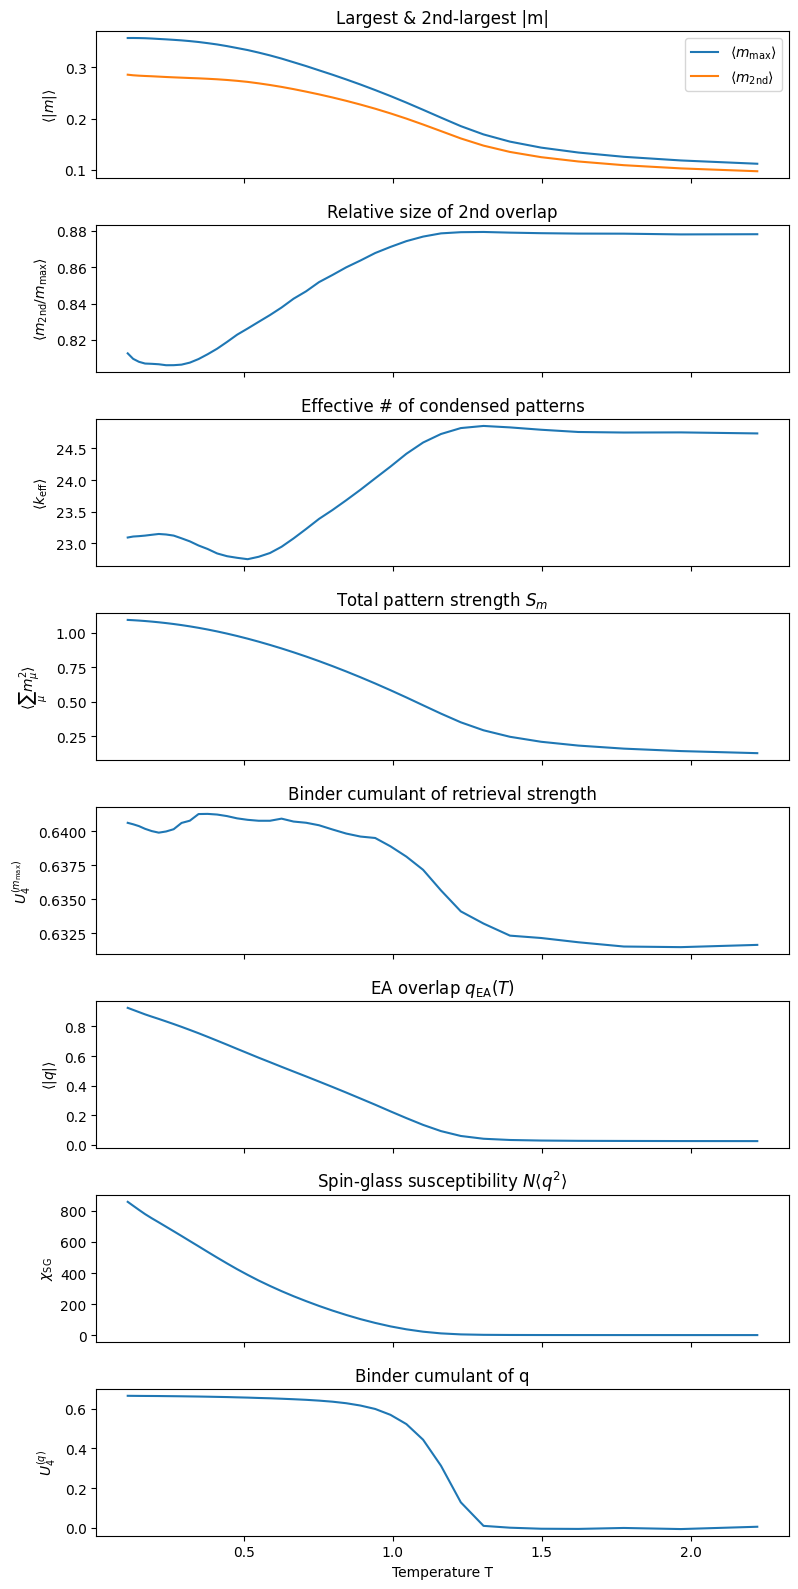

In [3]:
res = analyze_run_full("runs/hope2_pool")

In [ ]:
def _analyze_run_core(run_root):
    """
    Streaming analysis for a single Hopfield PT run.
    Returns a dict with the same observables as the old analyze_run_full,
    but does NOT plot.
    """
    rdirs = sorted(glob.glob(os.path.join(run_root, "r*")))
    if not rdirs:
        print(f"No r* dirs found in {run_root}")
        return None

    # --- load basic system info from first realization ---
    syscfg = np.load(os.path.join(rdirs[0], "sysconfig.npz"))
    if "β" in syscfg.files:
        betas = syscfg["β"]
    else:
        betas = syscfg["beta"]
    T_axis = 1.0 / betas
    K = betas.size

    if "N" in syscfg.files:
        N = int(syscfg["N"])
    else:
        raise KeyError("sysconfig.npz has no 'N' entry; needed for chi_SG")

    # =========================================================
    #  accumulators
    # =========================================================
    eps = 1e-16

    # m-based accumulators per temperature index k
    sum_m_max   = np.zeros(K, dtype=np.float64)
    sum_m_2nd   = np.zeros(K, dtype=np.float64)
    sum_ratio   = np.zeros(K, dtype=np.float64)
    sum_k_eff   = np.zeros(K, dtype=np.float64)
    sum_Sm      = np.zeros(K, dtype=np.float64)
    sum_m2_max  = np.zeros(K, dtype=np.float64)
    sum_m4_max  = np.zeros(K, dtype=np.float64)
    count_m     = np.zeros(K, dtype=np.int64)

    # q-based accumulators
    sum_q_abs   = np.zeros(K, dtype=np.float64)
    sum_q2      = np.zeros(K, dtype=np.float64)
    sum_q4      = np.zeros(K, dtype=np.float64)
    count_q     = np.zeros(K, dtype=np.int64)

    found_m = False
    found_q = False
    P_ref = None

    # =========================================================
    #  streaming over realizations and chunks
    # =========================================================
    for rdir in rdirs:
        ts_dir = os.path.join(rdir, "timeseries")

        # ----- m_sel chunks -----
        m_files = sorted(glob.glob(os.path.join(ts_dir, "*.m_sel.npy")))
        for fpath in m_files:
            found_m = True
            m_arr = np.load(fpath)  # (R, T_chunk, K, P)

            if m_arr.ndim != 4:
                raise ValueError(f"{fpath} has shape {m_arr.shape}, expected 4D (R, T_chunk, K, P)")

            R, T_chunk, K_m, P = m_arr.shape
            if K_m != K:
                raise ValueError(
                    f"Inconsistent K in {rdir}: m_sel has K={K_m}, expected {K}"
                )

            if P_ref is None:
                P_ref = P
            elif P != P_ref:
                raise ValueError(f"Inconsistent P across runs: saw {P_ref} and {P}")

            # compute per-snapshot quantities for this chunk
            m_abs = np.abs(m_arr)                          # (R, T_chunk, K, P)
            sorted_m = np.sort(m_abs, axis=-1)[..., ::-1]  # descending in μ

            m_max = sorted_m[..., 0]                       # (R, T_chunk, K)
            if P > 1:
                m_2nd = sorted_m[..., 1]
            else:
                m_2nd = np.zeros_like(m_max)

            # effective number of condensed patterns
            m2_vec = np.sum(m_abs**2, axis=-1)             # (R, T_chunk, K)
            m4_vec = np.sum(m_abs**4, axis=-1)
            k_eff  = (m2_vec**2) / np.maximum(m4_vec, eps)

            # total pattern strength (using signed m)
            S_m_vec = np.sum(m_arr**2, axis=-1)            # (R, T_chunk, K)

            # ratio of 2nd to max overlap
            ratio   = m_2nd / np.maximum(m_max, eps)

            # flatten snapshot axis: (R, T_chunk) -> snapshots
            m_max_flat   = m_max.reshape(-1, K)
            m_2nd_flat   = m_2nd.reshape(-1, K)
            ratio_flat   = ratio.reshape(-1, K)
            k_eff_flat   = k_eff.reshape(-1, K)
            S_m_flat     = S_m_vec.reshape(-1, K)

            # update accumulators
            sum_m_max   += m_max_flat.sum(axis=0)
            sum_m_2nd   += m_2nd_flat.sum(axis=0)
            sum_ratio   += ratio_flat.sum(axis=0)
            sum_k_eff   += k_eff_flat.sum(axis=0)
            sum_Sm      += S_m_flat.sum(axis=0)
            sum_m2_max  += (m_max_flat**2).sum(axis=0)
            sum_m4_max  += (m_max_flat**4).sum(axis=0)
            count_m     += m_max_flat.shape[0]

            # free large arrays
            del m_arr, m_abs, sorted_m, m_max, m_2nd, ratio, m2_vec, m4_vec, k_eff, S_m_vec
            del m_max_flat, m_2nd_flat, ratio_flat, k_eff_flat, S_m_flat

        # ----- q01 chunks -----
        q_files = sorted(glob.glob(os.path.join(ts_dir, "*.q01.npy")))
        for fpath in q_files:
            found_q = True
            q_arr = np.load(fpath)   # (T_chunk, K) or (R, T_chunk, K)? assume (T_chunk, K) as in original

            if q_arr.ndim == 2:
                # (T_chunk, K)
                T_chunk, K_q = q_arr.shape
                if K_q != K:
                    raise ValueError(
                        f"Inconsistent K in {rdir}: q01 has K={K_q}, expected {K}"
                    )
                q_flat = q_arr.reshape(-1, K)
            elif q_arr.ndim == 3:
                # be robust in case it's (R, T_chunk, K)
                R_q, T_chunk, K_q = q_arr.shape
                if K_q != K:
                    raise ValueError(
                        f"Inconsistent K in {rdir}: q01 has K={K_q}, expected {K}"
                    )
                q_flat = q_arr.reshape(-1, K)
            else:
                raise ValueError(f"{fpath} has unexpected shape {q_arr.shape}")

            q_abs  = np.abs(q_flat)
            q2     = q_flat**2

            sum_q_abs += q_abs.sum(axis=0)
            sum_q2    += q2.sum(axis=0)
            sum_q4    += (q2**2).sum(axis=0)
            count_q   += q_flat.shape[0]

            del q_arr, q_flat, q_abs, q2

    # ---------------------------------------------------------
    #  sanity checks: did we actually find any data?
    # ---------------------------------------------------------
    if not found_m:
        print(f"No m_sel data found under {run_root}")
        return None
    if not found_q:
        print(f"No q01 data found under {run_root}")
        return None

    if np.any(count_m == 0):
        raise RuntimeError("Some temperatures have zero m-snapshots; check your data layout.")
    if np.any(count_q == 0):
        raise RuntimeError("Some temperatures have zero q-snapshots; check your data layout.")

    # =========================================================
    #  convert accumulators to observables
    # =========================================================
    # m-based
    m_max_T =   sum_m_max  / count_m
    m_2nd_T =   sum_m_2nd  / count_m
    ratio_T =   sum_ratio  / count_m
    k_eff_T =   sum_k_eff  / count_m
    S_m_T   =   sum_Sm     / count_m

    m2_max  =   sum_m2_max / count_m
    m4_max  =   sum_m4_max / count_m
    binder_m = 1.0 - m4_max / (3.0 * np.maximum(m2_max**2, eps))

    # q-based
    qEA_T  = sum_q_abs / count_q          # <|q|>
    q2_T   = sum_q2    / count_q          # <q^2>
    q4_T   = sum_q4    / count_q          # <q^4>

    chi_SG_T = N * q2_T                    # spin-glass susceptibility
    binder_q = 1.0 - q4_T / (3.0 * np.maximum(q2_T**2, eps))

    # =========================================================
    #  sort everything by T (betas were low->high, so T high->low)
    # =========================================================
    order = np.argsort(T_axis)
    T_sorted   = T_axis[order]

    m_max_T    = m_max_T[order]
    m_2nd_T    = m_2nd_T[order]
    ratio_T    = ratio_T[order]
    k_eff_T    = k_eff_T[order]
    S_m_T      = S_m_T[order]
    binder_m   = binder_m[order]

    qEA_T      = qEA_T[order]
    chi_SG_T   = chi_SG_T[order]
    binder_q   = binder_q[order]

    return {
        "T":        T_sorted,
        "m_max":    m_max_T,
        "m_2nd":    m_2nd_T,
        "ratio_m":  ratio_T,
        "k_eff":    k_eff_T,
        "S_m":      S_m_T,
        "binder_m": binder_m,
        "qEA":      qEA_T,
        "chi_SG":   chi_SG_T,
        "binder_q": binder_q,
    }

def analyze_run_compare(run_root1, run_root2):
    """
    Analyze two PT runs and plot their observables on the same set of subplots,
    even if their temperature grids differ (as long as each run is internally consistent).

    Parameters
    ----------
    run_root1, run_root2 : str
        Directories containing r*/sysconfig.npz and r*/timeseries/*.m_sel.npy / *.q01.npy

    Returns
    -------
    out : dict
        {"run1": result1, "run2": result2}
        where each result is the dict returned by _analyze_run_core.
    """
    name1 = "α = 0.070"
    name2 = "α = 0.035"

    res1 = _analyze_run_core(run_root1)
    res2 = _analyze_run_core(run_root2)

    if res1 is None or res2 is None:
        print("One or both runs returned no data; skipping plots.")
        return {"run1": res1, "run2": res2}

    T1 = res1["T"]
    T2 = res2["T"]

    # Optional sanity: warn if T ranges don't match
    if not (np.isclose(T1.min(), T2.min()) and np.isclose(T1.max(), T2.max())):
        print(
            "Warning: Temperature ranges differ between runs:\n"
            f"  {name1}: [{T1.min():.4g}, {T1.max():.4g}]\n"
            f"  {name2}: [{T2.min():.4g}, {T2.max():.4g}]"
        )

    # =========================================================
    #  plotting: 8 vertical panels, shared x
    # =========================================================
    nrows = 8
    fig, axes = plt.subplots(nrows, 1, figsize=(8, 2.0 * nrows), sharex=True)
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes

    # 1) largest & 2nd-largest |m|
    ax1.plot(T1, res1["m_max"], label=fr"{name1} $\langle m_{{\max}}\rangle$")
    ax1.plot(T1, res1["m_2nd"], label=fr"{name1} $\langle m_{{\text{{2nd}}}}\rangle$")
    ax1.plot(T2, res2["m_max"], "--", label=fr"{name2} $\langle m_{{\max}}\rangle$")
    ax1.plot(T2, res2["m_2nd"], "--", label=fr"{name2} $\langle m_{{\text{{2nd}}}}\rangle$")
    ax1.set_ylabel(r"$\langle |m|\rangle$")
    ax1.set_title(f"Largest & 2nd-largest |m| ({name1} vs {name2})")
    ax1.legend(fontsize=8)

    # 2) ratio
    ax2.plot(T1, res1["ratio_m"], label=name1)
    ax2.plot(T2, res2["ratio_m"], "--", label=name2)
    ax2.set_ylabel(r"$\langle m_{\text{2nd}}/m_{\max}\rangle$")
    ax2.set_title(f"Relative size of 2nd overlap ({name1} vs {name2})")

    # 3) k_eff
    ax3.plot(T1, res1["k_eff"], label=name1)
    ax3.plot(T2, res2["k_eff"], "--", label=name2)
    ax3.set_ylabel(r"$\langle k_{\rm eff}\rangle$")
    ax3.set_title(f"Effective # of condensed patterns ({name1} vs {name2})")

    # 4) S_m
    ax4.plot(T1, res1["S_m"], label=name1)
    ax4.plot(T2, res2["S_m"], "--", label=name2)
    ax4.set_ylabel(r"$\langle \sum_\mu m_\mu^2\rangle$")
    ax4.set_title(rf"Total pattern strength $S_m$ ({name1} vs {name2})")

    # 5) Binder of m_max
    ax5.plot(T1, res1["binder_m"], label=name1)
    ax5.plot(T2, res2["binder_m"], "--", label=name2)
    ax5.set_ylabel(r"$U_4^{(m_{\max})}$")
    ax5.set_title(f"Binder cumulant of retrieval strength ({name1} vs {name2})")

    # 6) q_EA
    ax6.plot(T1, res1["qEA"], label=name1)
    ax6.plot(T2, res2["qEA"], "--", label=name2)
    ax6.set_ylabel(r"$\langle |q|\rangle$")
    ax6.set_title(rf"EA overlap $q_{{\rm EA}}(T)$ ({name1} vs {name2})")

    # 7) χ_SG
    ax7.plot(T1, res1["chi_SG"], label=name1)
    ax7.plot(T2, res2["chi_SG"], "--", label=name2)
    ax7.set_ylabel(r"$\chi_{\rm SG}$")
    ax7.set_title(rf"Spin-glass susceptibility $N\langle q^2\rangle$ ({name1} vs {name2})")

    # 8) Binder of q
    ax8.plot(T1, res1["binder_q"], label=name1)
    ax8.plot(T2, res2["binder_q"], "--", label=name2)
    ax8.set_ylabel(r"$U_4^{(q)}$")
    ax8.set_xlabel("Temperature T")
    ax8.set_title(f"Binder cumulant of q ({name1} vs {name2})")

    # one legend for run labels on the last panel
    ax8.legend(fontsize=8)
    #plt.xlim(0.5,0.7)
    plt.tight_layout()
    plt.show()

    return {"run1": res1, "run2": res2}



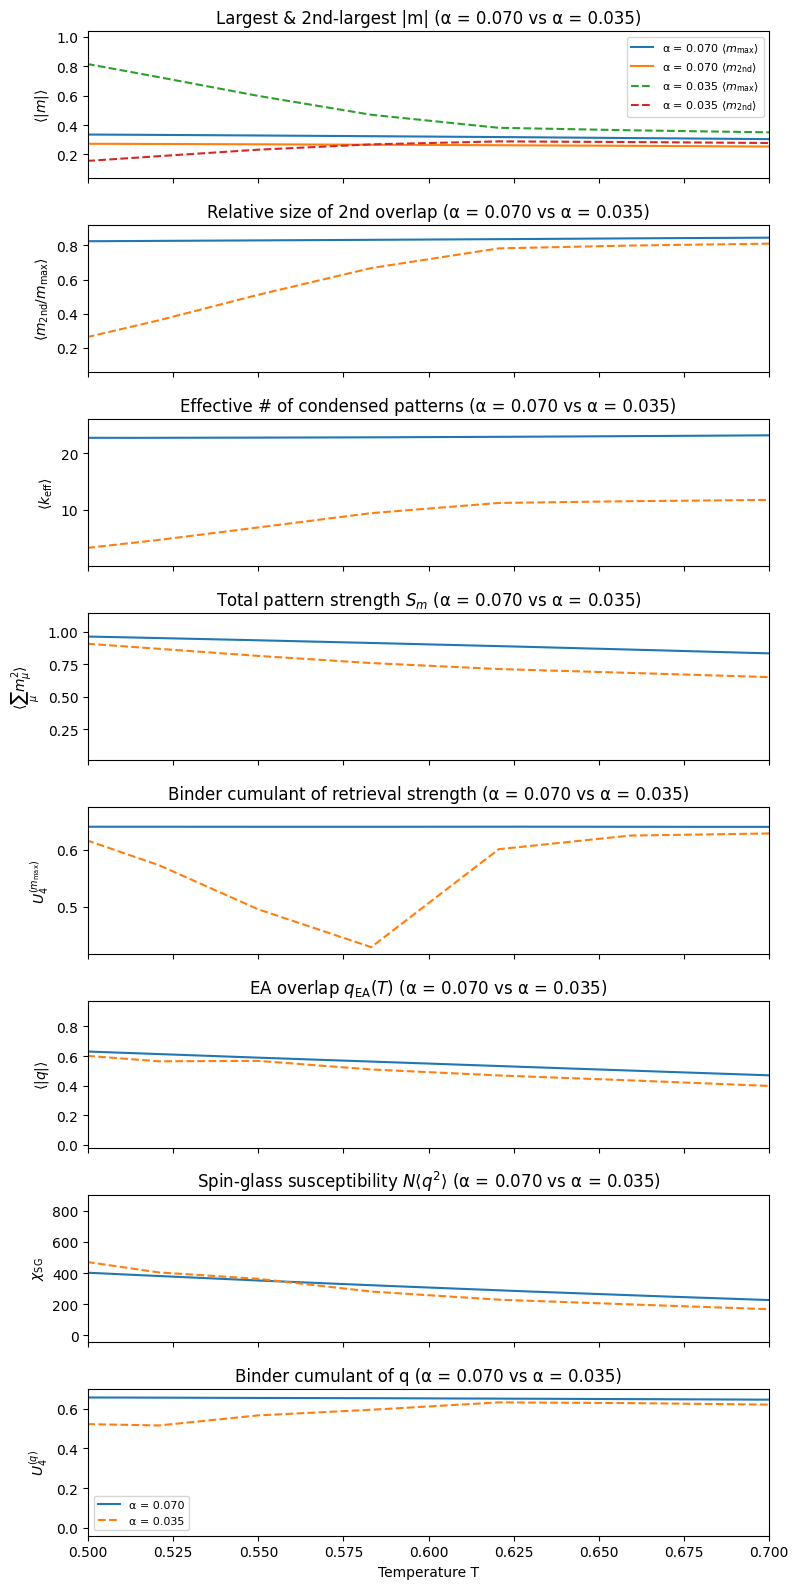

In [89]:
out = analyze_run_compare("runs/hope2_pool", "runs/hope_pool")

In [97]:
def analyze_binder_per_disorder(run_root, eps=1e-16):
    """
    Compute Binder cumulants U4(m_max) and U4(q) PER disorder realization r*.

    For each rdir:
      - reads timeseries/*.m_sel.npy (R,Tchunk,K,P), computes m_max = max_mu |m_mu|
      - reads timeseries/*.q01.npy   ((Tchunk,K) or (R,Tchunk,K))
      - accumulates <x^2>, <x^4> per temperature
      - returns Binder curves for that rdir

    Then aggregates across rdirs:
      mean and SEM across disorders.

    Returns dict:
      {
        "T": T_sorted,
        "binder_mmax_per_r": (nR, K),
        "binder_q_per_r":    (nR, K),
        "binder_mmax_mean":  (K,),
        "binder_mmax_sem":   (K,),
        "binder_q_mean":     (K,),
        "binder_q_sem":      (K,),
        "rdirs": list_of_rdirs_used
      }
    """
    rdirs_all = sorted(glob.glob(os.path.join(run_root, "r*")))
    if not rdirs_all:
        print(f"No r* dirs found in {run_root}")
        return None

    # --- load T axis from first realization ---
    syscfg = np.load(os.path.join(rdirs_all[0], "sysconfig.npz"))
    beta_key = "β" if "β" in syscfg.files else ("beta" if "beta" in syscfg.files else None)
    if beta_key is None:
        raise KeyError("sysconfig.npz has no 'beta' or 'β'")
    betas = np.asarray(syscfg[beta_key], dtype=np.float64)
    T_axis = 1.0 / betas
    K = betas.size
    order = np.argsort(T_axis)
    T_sorted = T_axis[order]

    binder_mmax_list = []
    binder_q_list = []
    used_rdirs = []

    for rdir in rdirs_all:
        ts_dir = os.path.join(rdir, "timeseries")
        m_files = sorted(glob.glob(os.path.join(ts_dir, "*.m_sel.npy")))
        q_files = sorted(glob.glob(os.path.join(ts_dir, "*.q01.npy")))
        if (not m_files) or (not q_files):
            # skip incomplete realizations
            continue

        # per-rdir accumulators
        sum_m2 = np.zeros(K, dtype=np.float64)
        sum_m4 = np.zeros(K, dtype=np.float64)
        cnt_m  = np.zeros(K, dtype=np.int64)

        sum_q2 = np.zeros(K, dtype=np.float64)
        sum_q4 = np.zeros(K, dtype=np.float64)
        cnt_q  = np.zeros(K, dtype=np.int64)

        # ---- m_max moments ----
        for fpath in m_files:
            m = np.load(fpath)  # (R,Tchunk,K,P)
            if m.ndim != 4:
                raise ValueError(f"{fpath} has shape {m.shape}, expected (R,Tchunk,K,P)")
            R, Tchunk, K0, P = m.shape
            if K0 != K:
                raise ValueError(f"{fpath}: K={K0} but sysconfig K={K}")

            np.abs(m, out=m)          # in-place |m|
            mmax = m.max(axis=-1)     # (R,Tchunk,K)

            m2 = mmax * mmax
            sum_m2 += m2.sum(axis=(0, 1))
            sum_m4 += (m2 * m2).sum(axis=(0, 1))
            cnt_m  += R * Tchunk

            del m, mmax, m2

        # ---- q moments ----
        for fpath in q_files:
            q = np.load(fpath)
            if q.ndim == 2:
                # (Tchunk,K)
                Tchunk, K0 = q.shape
                if K0 != K:
                    raise ValueError(f"{fpath}: K={K0} but sysconfig K={K}")
                q2 = q * q
                sum_q2 += q2.sum(axis=0)
                sum_q4 += (q2 * q2).sum(axis=0)
                cnt_q  += Tchunk
                del q, q2

            elif q.ndim == 3:
                # (R,Tchunk,K)
                Rq, Tchunk, K0 = q.shape
                if K0 != K:
                    raise ValueError(f"{fpath}: K={K0} but sysconfig K={K}")
                q2 = q * q
                sum_q2 += q2.sum(axis=(0, 1))
                sum_q4 += (q2 * q2).sum(axis=(0, 1))
                cnt_q  += Rq * Tchunk
                del q, q2

            else:
                raise ValueError(f"{fpath} has unexpected shape {q.shape}")

        # require data at all temps (otherwise comparison gets messy)
        if np.any(cnt_m == 0) or np.any(cnt_q == 0):
            continue

        m2 = sum_m2 / cnt_m
        m4 = sum_m4 / cnt_m
        binder_mmax = 1.0 - m4 / (3.0 * np.maximum(m2 * m2, eps))

        q2 = sum_q2 / cnt_q
        q4 = sum_q4 / cnt_q
        binder_q = 1.0 - q4 / (3.0 * np.maximum(q2 * q2, eps))

        binder_mmax_list.append(binder_mmax[order])
        binder_q_list.append(binder_q[order])
        used_rdirs.append(rdir)

    if not binder_mmax_list:
        print("No complete realizations found (need both m_sel and q01 in each rdir).")
        return None

    binder_mmax_per_r = np.asarray(binder_mmax_list, dtype=np.float64)  # (nR,K)
    binder_q_per_r    = np.asarray(binder_q_list, dtype=np.float64)     # (nR,K)
    nR = binder_mmax_per_r.shape[0]

    # mean + SEM across disorders
    m_mean = binder_mmax_per_r.mean(axis=0)
    q_mean = binder_q_per_r.mean(axis=0)

    if nR > 1:
        m_sem = binder_mmax_per_r.std(axis=0, ddof=1) / np.sqrt(nR)
        q_sem = binder_q_per_r.std(axis=0, ddof=1) / np.sqrt(nR)
    else:
        m_sem = np.zeros_like(m_mean)
        q_sem = np.zeros_like(q_mean)

    return {
        "T": T_sorted,
        "binder_mmax_per_r": binder_mmax_per_r,
        "binder_q_per_r": binder_q_per_r,
        "binder_mmax_mean": m_mean,
        "binder_mmax_sem": m_sem,
        "binder_q_mean": q_mean,
        "binder_q_sem": q_sem,
        "rdirs": used_rdirs,
    }


In [ ]:
def plot_binder_per_disorder(res, title_prefix="Binder per disorder", alpha=0.60):
    """
    Plot per-disorder Binder curves (faint) plus mean±SEM (bold) for both:
      - U4(m_max)
      - U4(q)

    Parameters
    ----------
    res : dict
        Output of analyze_binder_per_disorder(...)
    title_prefix : str
        Prefix for subplot titles
    alpha : float
        Transparency for individual disorder curves
    """
    if res is None:
        print("res is None")
        return

    T = res["T"]
    bm = res["binder_mmax_per_r"]   # (nR,K)
    bq = res["binder_q_per_r"]      # (nR,K)

    bm_mean = res["binder_mmax_mean"]
    bm_sem  = res["binder_mmax_sem"]
    bq_mean = res["binder_q_mean"]
    bq_sem  = res["binder_q_sem"]

    nR = bm.shape[0]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # --- U4(m_max) ---
    for r in range(nR):
        ax1.plot(T, bm[r], lw=1.0, alpha=alpha)
    ax1.plot(T, bm_mean, lw=2.5, label="mean")
    ax1.fill_between(T, bm_mean - bm_sem, bm_mean + bm_sem, alpha=0.25, label="±SEM")
    ax1.set_ylabel(r"$U_4(m_{\max})$")
    ax1.set_title(f"{title_prefix}: $U_4(m_{{\\max}})$  (n_disorders={nR})")
    ax1.grid(alpha=0.3)
    ax1.legend()

    # --- U4(q) ---
    for r in range(nR):
        ax2.plot(T, bq[r], lw=1.0, alpha=alpha)
    ax2.plot(T, bq_mean, lw=2.5, label="mean")
    ax2.fill_between(T, bq_mean - bq_sem, bq_mean + bq_sem, alpha=0.25, label="±SEM")
    ax2.set_ylabel(r"$U_4(q)$")
    ax2.set_xlabel("Temperature T")
    ax2.set_title(f"{title_prefix}: $U_4(q)$")
    ax2.grid(alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [101]:
res =analyze_binder_per_disorder("runs/hope_pool", eps=1e-16)

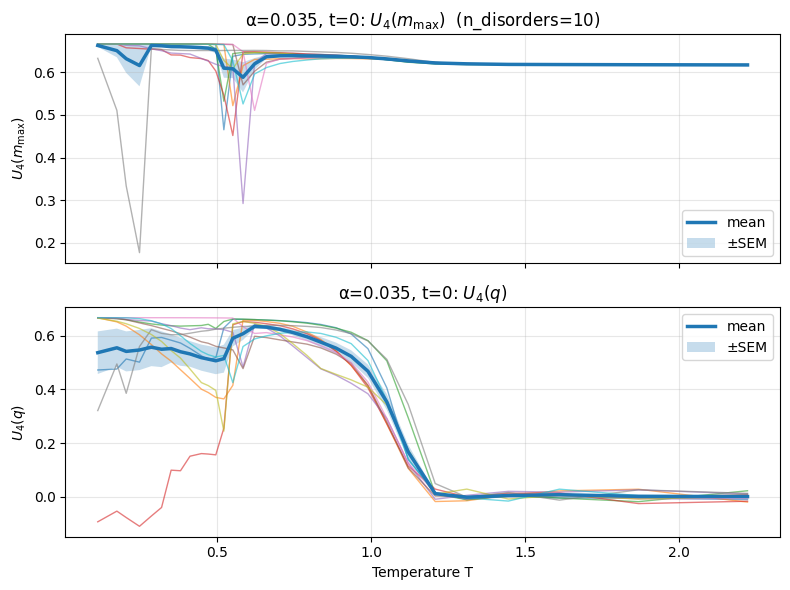

In [104]:
plot_binder_per_disorder(res, title_prefix="α=0.035, t=0")

In [105]:
def _crossing_temperature(T, w, p_cross=0.5):
    """
    Return T* where w(T) crosses p_cross using linear interpolation.
    Assumes T is sorted increasing. Works whether w decreases or increases.
    Returns np.nan if no crossing.
    """
    w = np.asarray(w, dtype=np.float64)
    T = np.asarray(T, dtype=np.float64)

    s = w - p_cross
    # find indices where sign changes or exactly hits zero
    idx = np.where(s == 0.0)[0]
    if idx.size:
        return float(T[idx[0]])

    sign = np.sign(s)
    changes = np.where(sign[:-1] * sign[1:] < 0)[0]
    if changes.size == 0:
        return np.nan

    i = changes[0]
    # linear interpolation between (T[i],w[i]) and (T[i+1],w[i+1])
    T0, T1 = T[i], T[i+1]
    w0, w1 = w[i], w[i+1]
    if w1 == w0:
        return float(0.5 * (T0 + T1))
    return float(T0 + (p_cross - w0) * (T1 - T0) / (w1 - w0))


def analyze_retrieval_weight(
    run_root,
    m0=0.80,
    rho0=0.40,
    p_cross=0.50,
    eps=1e-12,
    make_plots=True,
):
    """
    Computes retrieval weight w_r(T) per disorder:
      I = 1[ m_max > m0 AND (m_2nd/m_max) < rho0 ]
      w_r(T) = <I>_{replica,time}
    Then averages over disorder and extracts per-disorder crossing temperatures.

    Requires:
      r*/sysconfig.npz with beta or β
      r*/timeseries/*.m_sel.npy of shape (R, Tchunk, K, P)

    Returns dict with:
      T, w_per_disorder (nR,K), w_mean, w_sem,
      Tstar_per_disorder, Tstar_median, Tstar_IQR
    """
    rdirs_all = sorted(glob.glob(os.path.join(run_root, "r*")))
    if not rdirs_all:
        print(f"No r* dirs found in {run_root}")
        return None

    # ---- load temperature grid ----
    syscfg = np.load(os.path.join(rdirs_all[0], "sysconfig.npz"))
    beta_key = "β" if "β" in syscfg.files else ("beta" if "beta" in syscfg.files else None)
    if beta_key is None:
        raise KeyError("sysconfig.npz has no 'beta' or 'β'")
    betas = np.asarray(syscfg[beta_key], dtype=np.float64)
    T_axis = 1.0 / betas
    K = betas.size

    # sort by T for reporting/plotting
    order = np.argsort(T_axis)
    T_sorted = T_axis[order]

    w_list = []
    used_rdirs = []

    for rdir in rdirs_all:
        ts_dir = os.path.join(rdir, "timeseries")
        m_files = sorted(glob.glob(os.path.join(ts_dir, "*.m_sel.npy")))
        if not m_files:
            continue

        sum_I = np.zeros(K, dtype=np.float64)
        cnt   = np.zeros(K, dtype=np.int64)

        ok = True
        for fpath in m_files:
            m = np.load(fpath)  # (R,Tchunk,K,P)
            if m.ndim != 4:
                ok = False
                break
            R, Tchunk, K0, P = m.shape
            if K0 != K:
                raise ValueError(f"{fpath}: K={K0} but sysconfig K={K}")

            # |m|
            np.abs(m, out=m)

            if P >= 2:
                # top-2 along pattern axis without full sort:
                # last two entries are the two largest (unsorted)
                top2 = np.partition(m, P - 2, axis=-1)[..., -2:]   # (R,Tchunk,K,2)
                m_max = np.max(top2, axis=-1)                      # (R,Tchunk,K)
                m_2nd = np.min(top2, axis=-1)                      # (R,Tchunk,K)
            else:
                m_max = m[..., 0]
                m_2nd = np.zeros_like(m_max)

            rho = m_2nd / np.maximum(m_max, eps)
            I = (m_max > m0) & (rho < rho0)

            sum_I += I.sum(axis=(0, 1))
            cnt   += R * Tchunk

            del m, m_max, m_2nd, rho, I

        if (not ok) or np.any(cnt == 0):
            continue

        w_r = (sum_I / cnt)[order]  # sort by T
        w_list.append(w_r)
        used_rdirs.append(rdir)

    if not w_list:
        print("No complete realizations found.")
        return None

    w_per_disorder = np.asarray(w_list, dtype=np.float64)  # (nR,K)
    nR = w_per_disorder.shape[0]

    w_mean = w_per_disorder.mean(axis=0)
    w_sem  = (w_per_disorder.std(axis=0, ddof=1) / np.sqrt(nR)) if nR > 1 else np.zeros_like(w_mean)

    # per-disorder crossing temperatures
    Tstar = np.array([_crossing_temperature(T_sorted, w_per_disorder[r], p_cross) for r in range(nR)], dtype=float)
    Tstar_finite = Tstar[np.isfinite(Tstar)]
    if Tstar_finite.size:
        Tstar_median = float(np.median(Tstar_finite))
        q25, q75 = np.percentile(Tstar_finite, [25, 75])
        Tstar_IQR = (float(q25), float(q75))
    else:
        Tstar_median = np.nan
        Tstar_IQR = (np.nan, np.nan)

    out = {
        "T": T_sorted,
        "w_per_disorder": w_per_disorder,
        "w_mean": w_mean,
        "w_sem": w_sem,
        "Tstar_per_disorder": Tstar,
        "Tstar_median": Tstar_median,
        "Tstar_IQR": Tstar_IQR,
        "rdirs": used_rdirs,
        "params": {"m0": m0, "rho0": rho0, "p_cross": p_cross},
    }

    if make_plots:
        # ---- Plot 1: all disorder curves + mean ± SEM ----
        fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

        ax = axes[0]
        for r in range(nR):
            ax.plot(T_sorted, w_per_disorder[r], alpha=0.25, lw=1.0)
        ax.plot(T_sorted, w_mean, lw=2.5, label="mean")
        ax.fill_between(T_sorted, w_mean - w_sem, w_mean + w_sem, alpha=0.25, label="±SEM")
        ax.axhline(p_cross, ls="--", alpha=0.5)
        ax.set_ylabel(r"$w(T)=\langle I\rangle_{t,\mathrm{rep}}$")
        ax.set_title(rf"Retrieval weight: $I=\mathbf{{1}}[m_{{\max}}>{m0} \wedge (m_{{2nd}}/m_{{\max}})<{rho0}]$  (n_disorders={nR})")
        ax.grid(alpha=0.3)
        ax.legend()

        # ---- Plot 2: heatmap w_r(T) ----
        ax = axes[1]
        im = ax.imshow(
            w_per_disorder,
            aspect="auto",
            origin="lower",
            extent=[T_sorted[0], T_sorted[-1], 0, nR],
        )
        ax.set_ylabel("disorder index")
        ax.set_title("Heatmap of $w_r(T)$")
        fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)

        # ---- Plot 3: histogram of T* ----
        ax = axes[2]
        if Tstar_finite.size:
            ax.hist(Tstar_finite, bins=min(12, max(4, Tstar_finite.size)), density=False)
            ax.axvline(Tstar_median, ls="--", alpha=0.7, label=f"median={Tstar_median:.3g}")
            ax.legend()
            ax.set_title(rf"Crossing temperatures $T_r^*$ where $w_r(T)={p_cross}$ (IQR={Tstar_IQR[0]:.3g}–{Tstar_IQR[1]:.3g})")
        else:
            ax.text(0.5, 0.5, "No crossings found", ha="center", va="center", transform=ax.transAxes)
        ax.set_xlabel("Temperature T")
        ax.set_ylabel("count")
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

    return out


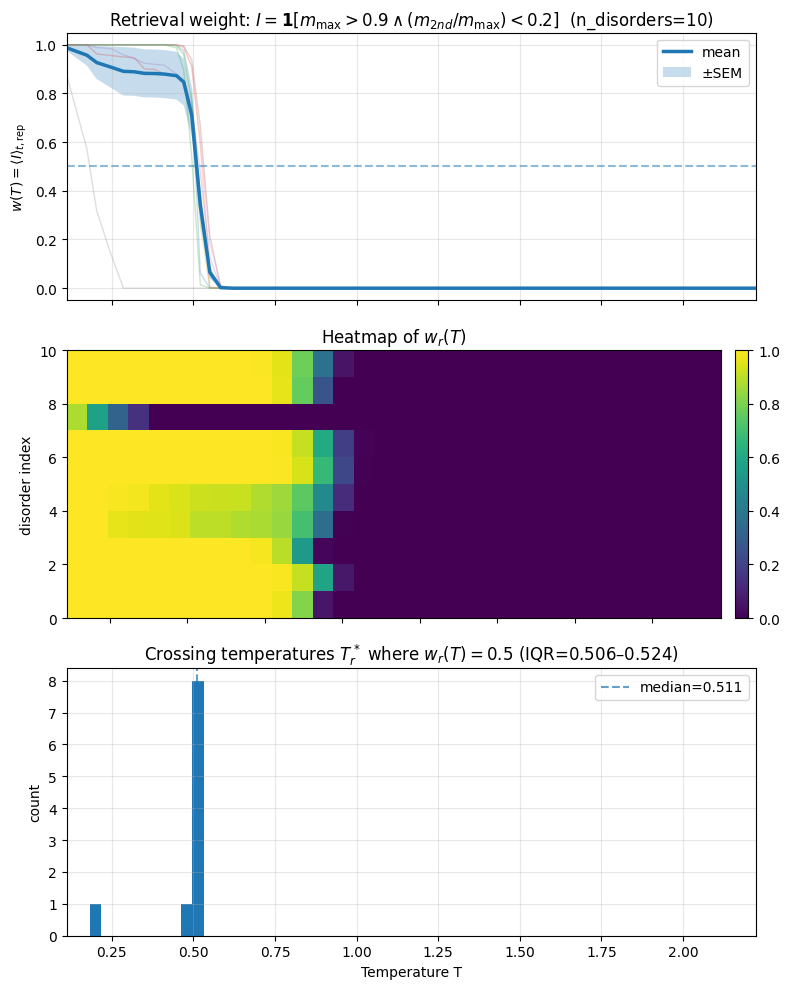

In [111]:
res = analyze_retrieval_weight(
    "runs/hope_pool",   # your run root
    m0=0.90,
    rho0=0.20,
    p_cross=0.50,
    make_plots=True,
)

### Parisi order parameter

In [112]:


def plot_overlap_histograms(run_root, rid=None, bins=100, range_q=(-1, 1)):
    """
    Plots vertical histograms of the overlap q (P(q)) for each temperature step.

    Streaming version: does NOT build a giant q_snap array; instead it
    accumulates histogram counts per temperature.
    
    Parameters
    ----------
    run_root : str
        Path to the simulation root directory.
    rid : int or str or None, optional
        If None, aggregates all realizations (disorder average).
        If int (e.g., 0), selects the realization at that index in the sorted list.
        If str (e.g., "r002"), selects that specific folder name.
    bins : int
        Number of histogram bins.
    range_q : tuple
        Plotting range for q.
    """
    # --- 1. Find realizations ---
    rdirs = sorted(glob.glob(os.path.join(run_root, "r*")))
    if not rdirs:
        print(f"No r* dirs found in {run_root}")
        return

    # --- Filtering Logic for Single Realization ---
    if rid is not None:
        if isinstance(rid, int):
            # Select by index
            if 0 <= rid < len(rdirs):
                print(f"Selecting realization index {rid}: {os.path.basename(rdirs[rid])}")
                rdirs = [rdirs[rid]]
                title_suffix = f" (Run {os.path.basename(rdirs[0])})"
            else:
                print(f"Error: rid index {rid} out of range (found {len(rdirs)} runs).")
                return
        else:
            # Select by name
            target = str(rid)
            found = [d for d in rdirs if os.path.basename(d) == target]
            if found:
                print(f"Selecting realization: {target}")
                rdirs = found
                title_suffix = f" (Run {target})"
            else:
                print(f"Error: Realization folder '{target}' not found.")
                return
    else:
        title_suffix = " (Disorder Average)"

    # --- 2. Load system info and temperature axis ---
    sys = np.load(os.path.join(rdirs[0], "sysconfig.npz"))
    if "β" in sys.files:
        betas = sys["β"]
    elif "beta" in sys.files:
        betas = sys["beta"]
    else:
        raise KeyError("Could not find 'beta' or 'β' in sysconfig.npz")

    K = betas.size

    # Calculate Temperatures (handle possible beta=0 gracefully)
    T_axis = np.divide(1.0, betas, out=np.full_like(betas, np.inf), where=betas != 0)

    # --- 3. Prepare histogram accumulators ---
    bin_edges = np.linspace(range_q[0], range_q[1], bins + 1)
    bin_width = bin_edges[1] - bin_edges[0]
    # hist_counts[k, :] = counts for temperature index k
    hist_counts = np.zeros((K, bins), dtype=np.float64)

    any_q = False

    # --- 4. Stream over q01 data and accumulate histograms ---
    for rdir in rdirs:
        ts_dir = os.path.join(rdir, "timeseries")
        q_files = sorted(glob.glob(os.path.join(ts_dir, "*.q01.npy")))
        if not q_files:
            continue

        for fpath in q_files:
            q_arr = np.load(fpath)

            # Support both (T_chunk, K) and (R, T_chunk, K) just in case
            if q_arr.ndim == 2:
                T_chunk, K_q = q_arr.shape
                if K_q != K:
                    print(f"Warning: Sketchy K dim in {rdir}, file {os.path.basename(fpath)}, skipping.")
                    continue
                q_flat = q_arr  # (T_chunk, K)
            elif q_arr.ndim == 3:
                R_q, T_chunk, K_q = q_arr.shape
                if K_q != K:
                    print(f"Warning: Sketchy K dim in {rdir}, file {os.path.basename(fpath)}, skipping.")
                    continue
                q_flat = q_arr.reshape(-1, K)  # (R_q*T_chunk, K)
            else:
                print(f"Warning: Unexpected q01 shape {q_arr.shape} in {fpath}, skipping.")
                continue

            # Accumulate histogram counts per temperature index
            # q_flat[:, k] is all snapshot values for temperature k in this chunk
            for k in range(K):
                data_k = q_flat[:, k]
                # counts only within range_q (np.histogram's `range` does that)
                counts, _ = np.histogram(data_k, bins=bin_edges, range=range_q)
                hist_counts[k] += counts

            any_q = True
            del q_arr, q_flat

    if not any_q:
        print("No q01 data found.")
        return

    # --- 5. Sort temperatures high -> low ---
    sorted_indices = np.argsort(T_axis)[::-1]  # Descending T
    T_sorted = T_axis[sorted_indices]
    hist_sorted = hist_counts[sorted_indices]

    # --- 6. Plotting ---
    fig_height = max(5, 0.8 * K)
    fig, axes = plt.subplots(K, 1, figsize=(6, fig_height), sharex=True, sharey=False)
    if K == 1:
        axes = [axes]

    print(f"Plotting P(q) for {K} temperatures...")

    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    for i, ax in enumerate(axes):
        counts = hist_sorted[i]
        total = counts.sum()

        if total > 0:
            # density such that ∫ P(q) dq = 1 over range_q
            density = counts / (total * bin_width)
        else:
            density = counts  # all zeros

        # mimic "stepfilled" style: outline + filled area
        ax.step(bin_centers, density, where="mid", color="navy")
        ax.fill_between(bin_centers, density, step="mid", alpha=0.7, color="navy")

        # Annotation
        label = f"$T={T_sorted[i]:.3f}$ "
        ax.text(
            0.98, 0.9, label,
            transform=ax.transAxes,
            ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle="round", facecolor='white', alpha=0.8)
        )

        # Y-axis tweaks
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_ylabel(r"$P(q)$", rotation=0, labelpad=15, fontsize=8)

    axes[-1].set_xlabel(r"Overlap $q$")
    axes[-1].set_xlim(range_q)

    plt.suptitle(r"Parisi Order Parameter $P(q)$" + title_suffix, y=1.005)
    plt.tight_layout()
    plt.show()


Plotting P(q) for 32 temperatures...


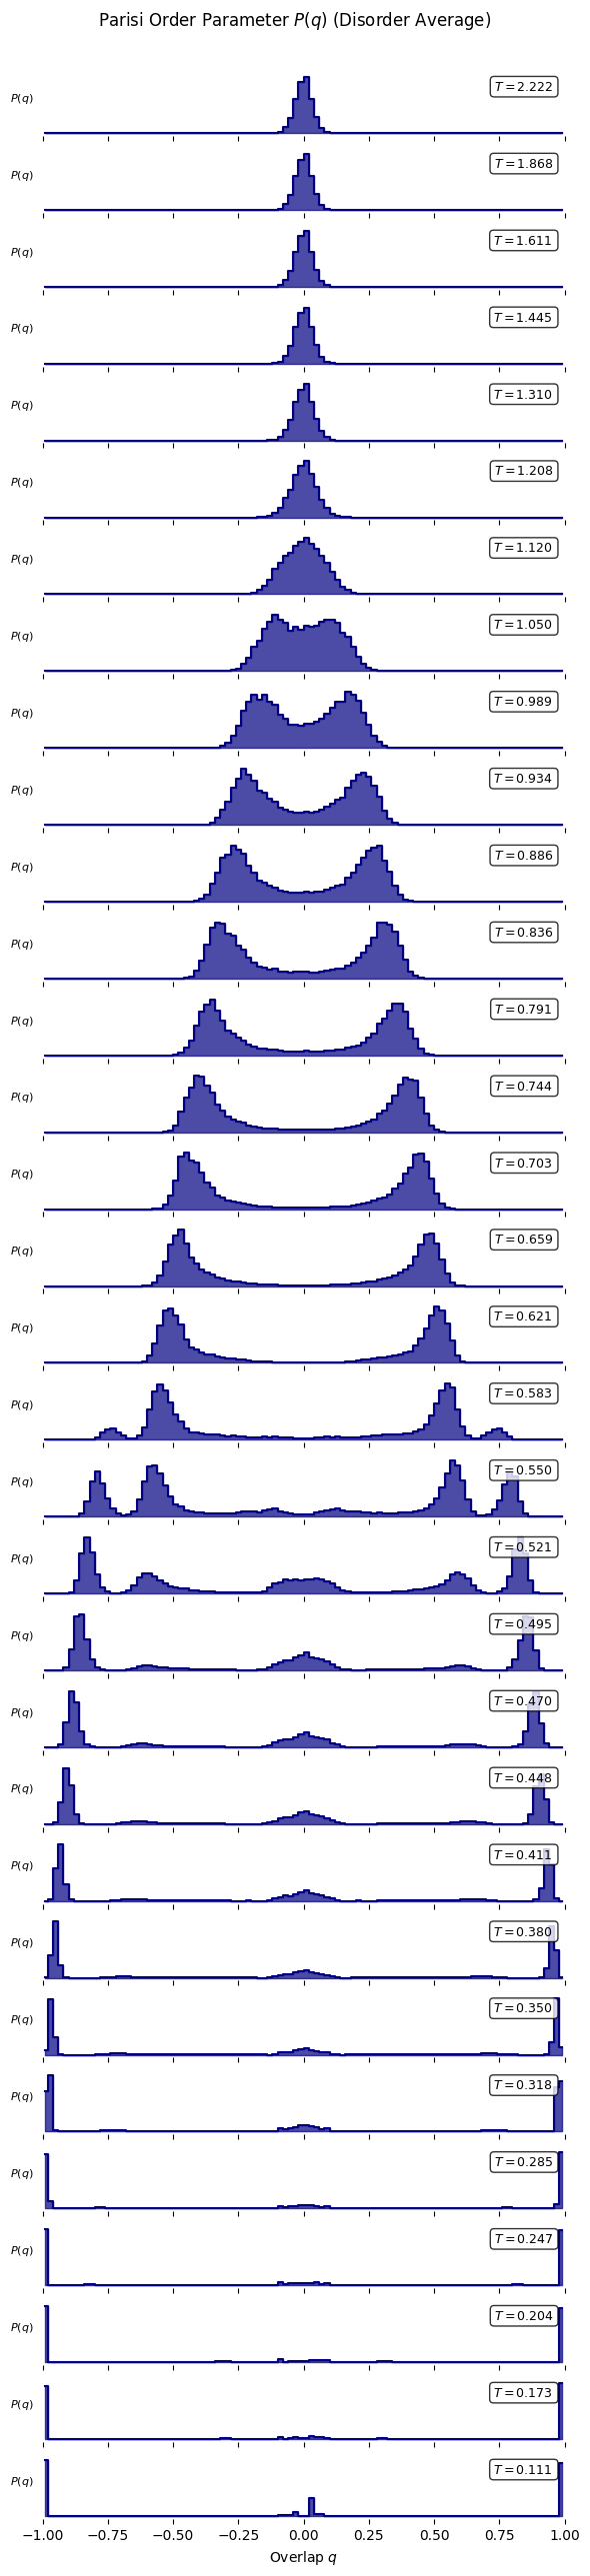

In [124]:
# Example Usage:
plot_overlap_histograms("runs/hope_pool")

In [120]:
def _select_rdirs(run_root, rid=None):
    rdirs = sorted(glob.glob(os.path.join(run_root, "r*")))
    if not rdirs:
        raise FileNotFoundError(f"No r* dirs found in {run_root}")

    if rid is None:
        return rdirs, " (disorder set)"

    if isinstance(rid, int):
        if rid < 0 or rid >= len(rdirs):
            raise IndexError(f"rid={rid} out of range (found {len(rdirs)} rdirs)")
        return [rdirs[rid]], f" ({os.path.basename(rdirs[rid])})"

    target = str(rid)
    found = [d for d in rdirs if os.path.basename(d) == target]
    if not found:
        raise FileNotFoundError(f"Realization '{target}' not found under {run_root}")
    return found, f" ({target})"


def _load_T_axis(rdir):
    syscfg = np.load(os.path.join(rdir, "sysconfig.npz"))
    beta_key = "β" if "β" in syscfg.files else ("beta" if "beta" in syscfg.files else None)
    if beta_key is None:
        raise KeyError("sysconfig.npz has no 'beta' or 'β'")
    betas = np.asarray(syscfg[beta_key], dtype=np.float64)
    T = np.divide(1.0, betas, out=np.full_like(betas, np.inf), where=betas != 0)
    return T, betas


def analyze_conditional_Pq(
    run_root,
    rid=None,
    m0=0.80,
    rho0=0.40,
    bins=120,
    range_q=(-1.0, 1.0),
    q0_mid=0.30,
    eps=1e-12,
    per_disorder_average=True,
):
    """
    Build conditional overlap distributions P(q | sector) where sector is RR/NN/MX.

    Uses m_sel chunks (R=2 replicas): (2, Tchunk, K, P)
    Uses q01 chunks: ideally (Tchunk, K), but supports (Rq, Tchunk, K) by tiling masks.

    If per_disorder_average=True:
      - normalizes histograms per disorder and temperature (within each sector)
      - then averages densities across disorders equally (nanmean)
    else:
      - pools counts across disorders first (sample-weighted)

    Returns dict with mean densities + weights (and per-disorder if averaged).
    """
    rdirs, title_suffix = _select_rdirs(run_root, rid=rid)
    T_axis, _ = _load_T_axis(rdirs[0])
    K = T_axis.size

    edges = np.linspace(range_q[0], range_q[1], bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    bw = edges[1] - edges[0]
    order = np.argsort(T_axis)
    T_sorted = T_axis[order]

    sectors = ["RR", "NN", "MX"]

    # Store per-disorder densities if doing equal-weight disorder average
    dens_per_r = {s: [] for s in sectors}   # each entry -> (K,bins) density or nan where empty
    w_per_r    = {s: [] for s in sectors}   # each entry -> (K,) sector weight among all samples

    # Or pooled accumulators
    pooled_counts = {s: np.zeros((K, bins), dtype=np.float64) for s in sectors}
    pooled_n      = {s: np.zeros(K, dtype=np.float64) for s in sectors}

    any_data = False

    for rdir in rdirs:
        ts_dir = os.path.join(rdir, "timeseries")
        m_files = sorted(glob.glob(os.path.join(ts_dir, "*.m_sel.npy")))
        q_files = sorted(glob.glob(os.path.join(ts_dir, "*.q01.npy")))
        if (not m_files) or (not q_files):
            continue

        # map by common prefix if possible
        def k_m(fp): return os.path.basename(fp).replace(".m_sel.npy", "")
        def k_q(fp): return os.path.basename(fp).replace(".q01.npy", "")

        q_map = {k_q(fp): fp for fp in q_files}
        keys = [k_m(fp) for fp in m_files if k_m(fp) in q_map]

        if len(keys) == 0 and len(m_files) == len(q_files):
            pairs = list(zip(m_files, q_files))
        else:
            pairs = [(os.path.join(ts_dir, k + ".m_sel.npy"), q_map[k]) for k in keys]

        # per-realization accumulators
        counts_r = {s: np.zeros((K, bins), dtype=np.float64) for s in sectors}
        n_r      = {s: np.zeros(K, dtype=np.float64) for s in sectors}

        for mpath, qpath in pairs:
            m = np.load(mpath)  # (2, Tchunk, K, P)
            if m.ndim != 4 or m.shape[0] != 2:
                continue
            R, Tchunk, K0, P = m.shape
            if K0 != K:
                raise ValueError(f"{mpath}: K={K0} but expected K={K}")

            q = np.load(qpath)

            # make q_flat as (nSnap, K) and build mask tiling accordingly
            if q.ndim == 2:
                Tq, Kq = q.shape
                if Kq != K or Tq != Tchunk:
                    continue
                q_flat = q
                tile_factor = 1
            elif q.ndim == 3:
                Rq, Tq, Kq = q.shape
                if Kq != K or Tq != Tchunk:
                    continue
                q_flat = q.reshape(-1, K)
                tile_factor = Rq
            else:
                continue

            # compute retrieval indicator per replica/time/temp from m
            np.abs(m, out=m)
            if P >= 2:
                top2 = np.partition(m, P - 2, axis=-1)[..., -2:]   # (2,Tchunk,K,2)
                mmax = np.max(top2, axis=-1)                       # (2,Tchunk,K)
                m2nd = np.min(top2, axis=-1)
            else:
                mmax = m[..., 0]
                m2nd = np.zeros_like(mmax)

            rho = m2nd / np.maximum(mmax, eps)
            I0 = (mmax[0] > m0) & (rho[0] < rho0)   # (Tchunk,K)
            I1 = (mmax[1] > m0) & (rho[1] < rho0)

            RR = (I0 & I1)
            NN = (~I0 & ~I1)
            MX = (I0 ^ I1)

            # tile masks if q had leading extra dim and got flattened
            if tile_factor != 1:
                RR = np.tile(RR, (tile_factor, 1))
                NN = np.tile(NN, (tile_factor, 1))
                MX = np.tile(MX, (tile_factor, 1))

            # accumulate histograms per temperature
            for k in range(K):
                qk = q_flat[:, k]

                for s, mask in (("RR", RR[:, k]), ("NN", NN[:, k]), ("MX", MX[:, k])):
                    if mask.any():
                        c, _ = np.histogram(qk[mask], bins=edges, range=range_q)
                        counts_r[s][k] += c
                        n_r[s][k] += mask.sum()

            any_data = True
            del m, q, q_flat, top2, mmax, m2nd, rho, I0, I1, RR, NN, MX

        if not any_data:
            continue

        if per_disorder_average:
            # per-disorder normalized densities (per sector, per temperature)
            dens_r = {}
            w_r = {}
            total_per_T = n_r["RR"] + n_r["NN"] + n_r["MX"]

            for s in sectors:
                dens = np.full((K, bins), np.nan, dtype=np.float64)
                for k in range(K):
                    tot = counts_r[s][k].sum()
                    if tot > 0:
                        dens[k] = counts_r[s][k] / (tot * bw)
                dens_r[s] = dens[order]

                w = np.zeros(K, dtype=np.float64)
                good = total_per_T > 0
                w[good] = n_r[s][good] / total_per_T[good]
                w_r[s] = w[order]

                dens_per_r[s].append(dens_r[s])
                w_per_r[s].append(w_r[s])

        else:
            # pool counts directly
            for s in sectors:
                pooled_counts[s] += counts_r[s]
                pooled_n[s] += n_r[s]

    if not any_data:
        print("No usable (m_sel,q01) chunk pairs found.")
        return None

    # build outputs
    out = {
        "T": T_sorted,
        "q_centers": centers,
        "bin_width": bw,
        "sectors": sectors,
        "params": {"m0": m0, "rho0": rho0, "q0_mid": q0_mid},
        "title_suffix": title_suffix,
    }

    if per_disorder_average:
        # convert lists -> arrays (nR, K, bins) and (nR, K)
        dens = {s: np.asarray(dens_per_r[s], dtype=np.float64) for s in sectors}
        wght = {s: np.asarray(w_per_r[s], dtype=np.float64) for s in sectors}

        out["dens_per_disorder"] = dens
        out["w_per_disorder"] = wght

        # mean + SEM across disorders (ignore nan bins where sector empty)
        dens_mean = {}
        dens_sem = {}
        w_mean = {}
        w_sem = {}

        for s in sectors:
            D = dens[s]   # (nR,K,bins)
            W = wght[s]   # (nR,K)
            dens_mean[s] = np.nanmean(D, axis=0)
            # SEM with nan handling: count non-nan per (K,bins)
            nn = np.sum(np.isfinite(D), axis=0)
            sd = np.nanstd(D, axis=0, ddof=1)
            dens_sem[s] = np.where(nn > 1, sd / np.sqrt(nn), 0.0)

            w_mean[s] = np.nanmean(W, axis=0)
            nW = np.sum(np.isfinite(W), axis=0)
            sdW = np.nanstd(W, axis=0, ddof=1)
            w_sem[s] = np.where(nW > 1, sdW / np.sqrt(nW), 0.0)

        out["dens_mean"] = dens_mean
        out["dens_sem"] = dens_sem
        out["w_mean"] = w_mean
        out["w_sem"] = w_sem

    else:
        # pooled densities per sector
        dens_mean = {}
        w_mean = {}
        total_per_T = pooled_n["RR"] + pooled_n["NN"] + pooled_n["MX"]

        for s in sectors:
            dens = np.zeros((K, bins), dtype=np.float64)
            for k in range(K):
                tot = pooled_counts[s][k].sum()
                if tot > 0:
                    dens[k] = pooled_counts[s][k] / (tot * bw)
            dens_mean[s] = dens[order]

            w = np.zeros(K, dtype=np.float64)
            good = total_per_T > 0
            w[good] = pooled_n[s][good] / total_per_T[good]
            w_mean[s] = w[order]

        out["dens_mean"] = dens_mean
        out["w_mean"] = w_mean

    return out


def plot_conditional_Pq(res, k_to_plot=None, max_rows=6):
    """
    Plots:
      (1) sector weights vs T
      (2) mid-weight diagnostics vs T
      (3) conditional histograms at selected temperatures (overlay RR/NN/MX)

    Expects output of analyze_conditional_Pq(..., per_disorder_average=True/False).
    """
    if res is None:
        return

    T = res["T"]
    qc = res["q_centers"]
    bw = res["bin_width"]
    sectors = res["sectors"]
    q0_mid = res["params"]["q0_mid"]
    suffix = res.get("title_suffix", "")

    dens = res["dens_mean"]
    w = res["w_mean"]

    # -------- Plot 1: sector weights vs T --------
    plt.figure(figsize=(7, 4))
    for s in sectors:
        if "w_sem" in res:
            plt.errorbar(T, w[s], yerr=res["w_sem"][s], capsize=2, label=s)
        else:
            plt.plot(T, w[s], label=s)
    plt.xlabel("Temperature T")
    plt.ylabel("sector weight")
    plt.title(rf"Sector weights vs T{suffix}  (RR: both retrieval, NN: both non, MX: mixed)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -------- Plot 2: middle weight diagnostics --------
    mid_mask = (np.abs(qc) < q0_mid)
    plt.figure(figsize=(7, 4))
    for s in sectors:
        # conditional prob of being in middle given sector
        p_mid_cond = dens[s][:, mid_mask].sum(axis=1) * bw
        # unconditional contribution to middle = weight(sector)*p_mid_cond
        p_mid_uncond = w[s] * p_mid_cond
        plt.plot(T, p_mid_uncond, label=f"{s}: w·P(|q|<{q0_mid})")
    plt.xlabel("Temperature T")
    plt.ylabel("unconditional middle weight")
    plt.title(rf"Where does the middle support come from?{suffix}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -------- Plot 3: conditional histograms at selected temperatures --------
    K = len(T)
    if k_to_plot is None:
        # auto-pick: max mixed weight, plus neighbors, plus one high-T and one low-T
        k_mix = int(np.nanargmax(w["MX"]))
        candidates = [0, max(0, k_mix - 1), k_mix, min(K - 1, k_mix + 1), K - 1]
        # unique while preserving order
        seen = set()
        k_to_plot = [k for k in candidates if (k not in seen and not seen.add(k))]
        k_to_plot = k_to_plot[:max_rows]

    nrows = len(k_to_plot)
    fig, axes = plt.subplots(nrows, 1, figsize=(7, 2.2 * nrows), sharex=True)
    if nrows == 1:
        axes = [axes]

    for ax, k in zip(axes, k_to_plot):
        for s in sectors:
            ax.step(qc, dens[s][k], where="mid", label=s)
        ax.set_title(
            rf"T={T[k]:.3f}   "
            + "  ".join([f"{s}:{w[s][k]:.2f}" for s in sectors])
        )
        ax.set_ylabel("density")
        ax.grid(alpha=0.2)

    axes[-1].set_xlabel("overlap q")
    axes[0].legend(ncol=3)
    plt.suptitle(rf"Conditional $P(q \mid \mathrm{{sector}})$  with  I=[m_max>{res['params']['m0']} & rho<{res['params']['rho0']}] {suffix}", y=1.01)
    plt.tight_layout()
    plt.show()


In [128]:
def save_conditionalPq_output(res, out_path="condPq_out.npz", T_window=None):
    """
    Save a compact version of analyze_conditional_Pq output.
    Optionally restrict to a temperature window: T_window=(Tmin,Tmax).
    """
    T = res["T"]
    qc = res["q_centers"]

    ksel = np.arange(T.size)
    if T_window is not None:
        Tmin, Tmax = T_window
        ksel = np.where((T >= Tmin) & (T <= Tmax))[0]

    payload = {
        "T": T[ksel],
        "q_centers": qc,
        "bin_width": res["bin_width"],
        "m0": res["params"]["m0"],
        "rho0": res["params"]["rho0"],
        "q0_mid": res["params"]["q0_mid"],
    }

    for s in ["RR", "NN", "MX"]:
        payload[f"dens_{s}"] = res["dens_mean"][s][ksel]   # (Ksel,bins)
        payload[f"w_{s}"]    = res["w_mean"][s][ksel]      # (Ksel,)

        if "dens_sem" in res:
            payload[f"densSEM_{s}"] = res["dens_sem"][s][ksel]
        if "w_sem" in res:
            payload[f"wSEM_{s}"] = res["w_sem"][s][ksel]

    np.savez_compressed(out_path, **payload)
    print("saved:", out_path, "  (T points:", len(ksel), ", bins:", len(qc), ")")


In [ ]:
res = analyze_conditional_Pq(
    run_root="runs/hope_pool",
    rid=None,          # or None for all disorders
    m0=0.90,
    rho0=0.40,
    bins=140,
    q0_mid=0.5,
    per_disorder_average=True,   # recommended
)


/tmp/ipykernel_4683/4197526599.py:226: RuntimeWarning: Mean of empty slice
  dens_mean[s] = np.nanmean(D, axis=0)


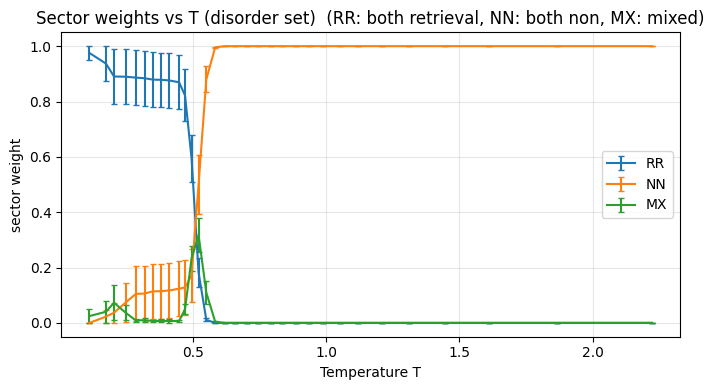

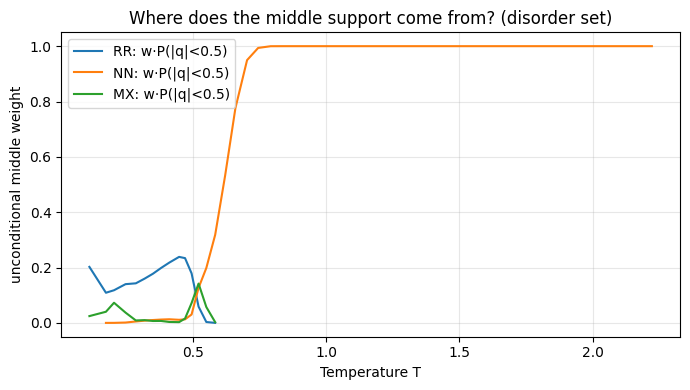

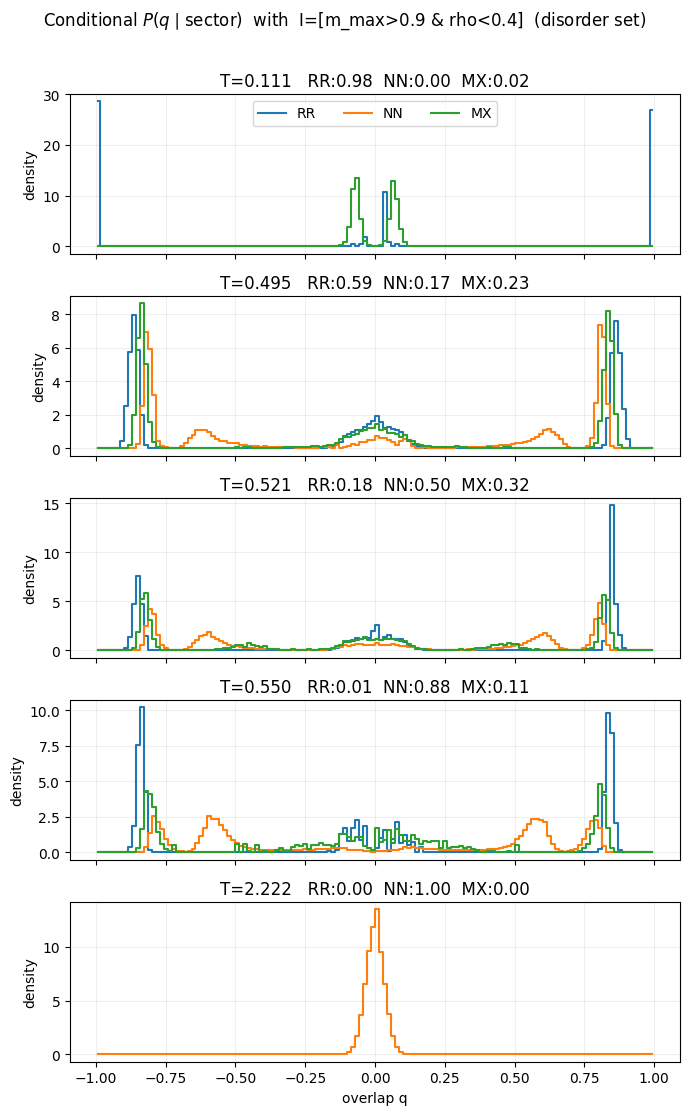

In [130]:

plot_conditional_Pq(res)

In [129]:
save_conditionalPq_output(res, "condPq_alpha003_r009.npz", T_window=(0.45, 0.65))

saved: condPq_alpha003_r009.npz   (T points: 6 , bins: 140 )


### magnetization stuff

In [2]:
def _to_list(x):
    """Helper: turn int/None/list/ndarray into a Python list."""
    if x is None:
        return None
    if isinstance(x, (list, tuple, np.ndarray)):
        return list(x)
    else:
        return [x]



In [3]:
def plot_m_timeseries_grid(
    run_root,
    disorder_idx=0,
    replica=0,
    temperature_idx=0,
    pattern=0,
    abs_val=True,
):
    """
    Plot time series of m for selected replicas, temperatures and patterns,
    streaming over m_sel chunks instead of holding the full (R,T,K,P) array.
    """

    # --- Find realization directory ---
    rdirs = sorted(glob.glob(os.path.join(run_root, "r*")))
    if not rdirs:
        print("No realizations found in", run_root)
        return

    if disorder_idx < 0 or disorder_idx >= len(rdirs):
        raise IndexError(
            f"disorder_idx={disorder_idx} out of range, found {len(rdirs)} realizations."
        )

    rdir = rdirs[disorder_idx]

    # --- Load betas and temps for titles ---
    syscfg = np.load(os.path.join(rdir, "sysconfig.npz"))
    if "beta" in syscfg.files:
        betas = np.array(syscfg["beta"])
    elif "β" in syscfg.files:
        betas = np.array(syscfg["β"])
    else:
        raise KeyError("sysconfig.npz has no 'beta' or 'β'")
    T_vals = 1.0 / betas
    K = betas.size

    # --- List timeseries files ---
    m_files = sorted(glob.glob(os.path.join(rdir, "timeseries", "*.m_sel.npy")))
    if not m_files:
        print(f"No m_sel timeseries found in {rdir}")
        return

    # --- First pass: infer R, K, P and total time length T_total ---
    R = None
    P = None
    T_total = 0
    for fpath in m_files:
        m_chunk = np.load(fpath, mmap_mode="r")
        if m_chunk.ndim != 4:
            raise ValueError(
                f"{fpath} has shape {m_chunk.shape}, expected 4D (R, T_chunk, K, P)"
            )
        R_chunk, T_chunk, K_chunk, P_chunk = m_chunk.shape
        if K_chunk != K:
            raise ValueError(f"Inconsistent K in {fpath}: {K_chunk} vs {K}")
        if R is None:
            R = R_chunk
            P = P_chunk
        else:
            if R_chunk != R or P_chunk != P:
                raise ValueError(
                    f"Inconsistent (R,P) across files: saw (R={R},P={P}) and "
                    f"(R={R_chunk},P={P_chunk})"
                )
        T_total += T_chunk

    # --- Normalize inputs to lists now that we know (R,K,P) ---
    replicas = _to_list(replica)
    betas_idx = _to_list(temperature_idx)
    patterns = _to_list(pattern)

    if replicas is None:
        replicas = list(range(R))
    if betas_idx is None:
        betas_idx = list(range(K))
    if patterns is None:
        patterns = list(range(P))

    for rep in replicas:
        if rep < 0 or rep >= R:
            raise IndexError(f"replica index {rep} out of range [0, {R-1}]")
    for k_idx in betas_idx:
        if k_idx < 0 or k_idx >= K:
            raise IndexError(f"temperature_idx {k_idx} out of range [0, {K-1}]")
    for p_idx in patterns:
        if p_idx < 0 or p_idx >= P:
            raise IndexError(f"pattern index {p_idx} out of range [0, {P-1}]")

    n_rows = len(betas_idx)
    n_cols = len(replicas)

    # --- Allocate storage only for requested time series ---
    # ts[i_row][j_col] has shape (T_total, len(patterns))
    ts = [
        [np.zeros((T_total, len(patterns)), dtype=np.float32) for _ in range(n_cols)]
        for __ in range(n_rows)
    ]

    # --- Second pass: fill time series chunk-by-chunk ---
    t_offset = 0
    for fpath in m_files:
        m_chunk = np.load(fpath)  # (R, T_chunk, K, P)
        if m_chunk.ndim != 4:
            raise ValueError(
                f"{fpath} has shape {m_chunk.shape}, expected 4D (R, T_chunk, K, P)"
            )

        if abs_val:
            m_chunk = np.abs(m_chunk)

        _, T_chunk, _, _ = m_chunk.shape

        for i_row, k_idx in enumerate(betas_idx):
            for j_col, rep in enumerate(replicas):
                # (T_chunk, P)
                sub = m_chunk[rep, :, k_idx, :]
                # select requested patterns into columns
                ts[i_row][j_col][t_offset : t_offset + T_chunk, :] = sub[:, patterns]

        t_offset += T_chunk
        del m_chunk

    # --- Plotting ---
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(5 * n_cols, 3 * n_rows),
        sharex=True,
        sharey=True,
    )

    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = np.array([axes])
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)

    t = np.arange(T_total)

    for i_row, k_idx in enumerate(betas_idx):
        for j_col, rep in enumerate(replicas):
            ax = axes[i_row, j_col]
            m_ts = ts[i_row][j_col]  # (T_total, len(patterns))

            for j_p, p_idx in enumerate(patterns):
                ax.plot(t, m_ts[:, j_p], label=f"p={p_idx}", alpha=0.8)

            T_val = T_vals[k_idx]
            ax.set_title(f"rep={rep}, T_idx={k_idx}, T={T_val:.3g}")

            if i_row == n_rows - 1:
                ax.set_xlabel("time step")
            if j_col == 0:
                ax.set_ylabel("|m|" if abs_val else "m")

    if n_rows * n_cols == 1:
        axes[0, 0].legend()
    else:
        handles, labels = axes[0, 0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.02, 1.02))

    plt.tight_layout()
    plt.show()


In [4]:
def find_ever_retrieved_patterns(run_root, disorder_idx=0, threshold=0.9):
    """
    Streaming version: only keeps the per-pattern max |m| across all
    replicas, times, and temperatures.
    """
    # locate realization directory
    rdirs = sorted(glob.glob(os.path.join(run_root, "r*")))
    if not rdirs:
        raise RuntimeError(f"No realizations found in {run_root}")

    if disorder_idx < 0 or disorder_idx >= len(rdirs):
        raise IndexError(
            f"disorder_idx={disorder_idx} out of range; found {len(rdirs)} realizations."
        )

    rdir = rdirs[disorder_idx]

    m_files = sorted(glob.glob(os.path.join(rdir, "timeseries", "*.m_sel.npy")))
    if not m_files:
        raise RuntimeError(f"No m_sel timeseries found in {rdir}")

    max_over_all = None
    P = None

    for fpath in m_files:
        m_chunk = np.load(fpath)  # (R, T_chunk, K, P)
        if m_chunk.ndim != 4:
            raise ValueError(
                f"Expected m_chunk with 4 dims (R,T,K,P), got shape {m_chunk.shape}"
            )

        abs_m = np.abs(m_chunk)
        max_chunk = abs_m.max(axis=(0, 1, 2))  # -> (P,)

        if max_over_all is None:
            max_over_all = max_chunk
            P = max_chunk.shape[0]
        else:
            if max_chunk.shape[0] != P:
                raise ValueError(
                    f"Inconsistent P across chunks: expected {P}, got {max_chunk.shape[0]}"
                )
            max_over_all = np.maximum(max_over_all, max_chunk)

        del m_chunk, abs_m, max_chunk

    mask_ever = max_over_all >= threshold
    ever_indices = np.where(mask_ever)[0]

    return ever_indices, max_over_all


In [6]:
mu_idx,mu_max = find_ever_retrieved_patterns(    "runs/hope2_pool",
 disorder_idx=3, threshold=0.99)

In [8]:
def plot_all_heatmaps_corrected(run_root):
    rdirs = sorted(glob.glob(os.path.join(run_root, "r*")))
    if not rdirs:
        return

    # 1. Load physics and sort T properly
    syscfg = np.load(os.path.join(rdirs[0], "sysconfig.npz"))
    if "beta" in syscfg.files:
        betas = syscfg["beta"]
    elif "β" in syscfg.files:
        betas = syscfg["β"]
    else:
        raise KeyError("sysconfig.npz has no 'beta' or 'β'")
    T_axis = 1.0 / betas
    K = betas.size

    # Sort T ascending (low T -> high T)
    sort_idx = np.argsort(T_axis)
    T_sorted = T_axis[sort_idx]

    n_rows = 5
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20), sharex=True)
    axes = axes.flatten()

    im = None  # last image for colorbar

    for i, ax in enumerate(axes):
        if i >= len(rdirs):
            ax.axis("off")
            continue

        rdir = rdirs[i]
        m_files = sorted(glob.glob(os.path.join(rdir, "timeseries", "*.m_sel.npy")))
        if not m_files:
            ax.axis("off")
            continue

        try:
            sum_abs = None
            count = 0

            # Streaming average over R,time
            for fpath in m_files:
                m_chunk = np.load(fpath)  # (R, T_chunk, K, P)
                if m_chunk.ndim != 4:
                    raise ValueError(
                        f"{fpath} has unexpected shape {m_chunk.shape}, expected (R,T,K,P)"
                    )
                abs_chunk = np.abs(m_chunk)
                # sum over replicas and time -> (K, P)
                partial_sum = abs_chunk.sum(axis=(0, 1))  # (K, P)
                if sum_abs is None:
                    sum_abs = partial_sum
                else:
                    if partial_sum.shape != sum_abs.shape:
                        raise ValueError(
                            f"Inconsistent (K,P) in {rdir}: got {partial_sum.shape}, "
                            f"expected {sum_abs.shape}"
                        )
                    sum_abs += partial_sum

                count += abs_chunk.shape[0] * abs_chunk.shape[1]
                del m_chunk, abs_chunk, partial_sum

            if sum_abs is None or count == 0:
                ax.axis("off")
                continue

            # <|m|> over replicas and time, shape (K,P)
            m_mean = sum_abs / count

            # Reorder to match sorted T (low->high), then transpose to (P,K)
            if m_mean.shape[0] != K:
                raise ValueError(
                    f"Expected first dim of m_mean to be K={K}, got {m_mean.shape[0]}"
                )
            m_sorted = m_mean[sort_idx, :].T  # (P, K)

            # 3. Plot with pcolormesh
            X, Y = np.meshgrid(T_sorted, np.arange(m_sorted.shape[0]))
            im = ax.pcolormesh(
                X,
                Y,
                m_sorted,
                shading="nearest",
                cmap="viridis",
                vmin=0,
                vmax=1,
            )

            ax.set_title(f"Realization {i} ({os.path.basename(rdir)})")
            ax.set_ylabel("Pattern Index")
            if i >= (n_rows - 1) * n_cols:
                ax.set_xlabel("Temperature ($T$)")

        except Exception as e:
            print(f"Error {rdir}: {e}")
            ax.axis("off")

    if im is not None:
        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), pad=0.02, aspect=40)
        cbar.set_label(r"Overlap $|m|$", fontsize=12)

    plt.suptitle(
        "Corrected Phase Diagram (Non-linear T Axis)", fontsize=16, y=1.02
    )
    plt.show()


In [13]:
def plot_mmax_histograms(
    run_root,
    disorder_idx=0,
    beta_indices=None,
    bins=50,
    value_range=(0.0, 1.0),
    density=True,
):
    """
    For a given realization (disorder_idx), build histograms of m_max(T)
    for each temperature and overlay them in a single plot.

    m_max(T_k, replica, time) = max_mu |m_mu(replica, time, T_k)|

    The histogram at temperature index k is accumulated over all
    replicas and all time steps.

    Parameters
    ----------
    run_root : str
        Root directory containing r*/timeseries/*.m_sel.npy and sysconfig.npz
    disorder_idx : int
        Index of the realization/disorder (which r* dir to use, after sorting).
    beta_indices : None or int or list/array of int
        Temperature indices to show.
        - If None: show all K temperatures.
        - Example: np.arange(1, K) to skip the first one.
    bins : int
        Number of histogram bins.
    value_range : tuple
        (min, max) range for histogram (e.g. (0,1) for |m|).
    density : bool
        If True, normalize histograms to probability density.
    """

    # --- 1. Locate realization directory ---
    rdirs = sorted(glob.glob(os.path.join(run_root, "r*")))
    if not rdirs:
        print(f"No realizations found in {run_root}")
        return

    if disorder_idx < 0 or disorder_idx >= len(rdirs):
        raise IndexError(
            f"disorder_idx={disorder_idx} out of range, found {len(rdirs)} realizations."
        )

    rdir = rdirs[disorder_idx]

    # --- 2. Load betas and temps ---
    syscfg = np.load(os.path.join(rdir, "sysconfig.npz"))
    if "beta" in syscfg.files:
        betas = np.array(syscfg["beta"])
    elif "β" in syscfg.files:
        betas = np.array(syscfg["β"])
    else:
        raise KeyError("sysconfig.npz has no 'beta' or 'β'")
    K = betas.size
    T_vals = 1.0 / betas

    # --- 3. Which beta indices to show? ---
    if beta_indices is None:
        beta_indices = np.arange(K)
    elif isinstance(beta_indices, (int, np.integer)):
        beta_indices = np.array([beta_indices])
    else:
        beta_indices = np.array(list(beta_indices), dtype=int)

    # sanity-check indices
    for k_idx in beta_indices:
        if k_idx < 0 or k_idx >= K:
            raise IndexError(f"beta index {k_idx} out of range [0, {K-1}]")

    # sort them by temperature (optional but usually nicer)
    beta_indices = beta_indices[np.argsort(T_vals[beta_indices])]

    # --- 4. Prepare histogram accumulators ---
    bin_edges = np.linspace(value_range[0], value_range[1], bins + 1)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # hist_counts[k, :] = counts for temperature index k
    hist_counts = np.zeros((K, bins), dtype=np.float64)

    # --- 5. Stream over m_sel and accumulate m_max histograms ---
    m_files = sorted(glob.glob(os.path.join(rdir, "timeseries", "*.m_sel.npy")))
    if not m_files:
        print(f"No m_sel timeseries found in {rdir}")
        return

    first = np.load(m_files[0], mmap_mode="r")
    if first.ndim != 4:
        raise ValueError(
            f"Expected m_sel with 4 dims (R,T,K,P), got shape {first.shape}"
        )
    R, _, K0, P = first.shape
    if K0 != K:
        raise ValueError(f"Inconsistent K in m_sel: {K0} vs {K}")
    del first

    for fpath in m_files:
        m_chunk = np.load(fpath)  # (R, T_chunk, K, P)
        if m_chunk.ndim != 4:
            raise ValueError(
                f"{fpath} has shape {m_chunk.shape}, expected (R,T,K,P)"
            )

        # m_max_chunk: (R, T_chunk, K) = max_mu |m|
        abs_chunk = np.abs(m_chunk)
        m_max_chunk = abs_chunk.max(axis=-1)

        # flatten (R, T_chunk) into one axis: (N_snap_chunk, K)
        m_max_flat = m_max_chunk.reshape(-1, K)

        # accumulate histogram for each temperature
        for k_idx in range(K):
            data_k = m_max_flat[:, k_idx]
            counts, _ = np.histogram(
                data_k,
                bins=bin_edges,
                range=value_range,
            )
            hist_counts[k_idx] += counts

        del m_chunk, abs_chunk, m_max_chunk, m_max_flat

    # --- 6. Plot all selected temperatures in one big plot ---
    fig, ax = plt.subplots(figsize=(10, 7))

    # color map over the selected temperatures
    cmap = cm.get_cmap("magma")
    colors = cmap(np.linspace(0, 1, len(beta_indices)))

    for c, k_idx in zip(colors, beta_indices):
        counts = hist_counts[k_idx]
        total = counts.sum()
        if total == 0:
            # no data for this temperature; skip
            continue

        if density:
            y = counts / (total * bin_width)
        else:
            y = counts

        T_val = T_vals[k_idx]
        beta_val = betas[k_idx]

        y_step = np.r_[y, y[-1]]  # pad one extra value for the last edge

        ax.step(
            bin_edges,
            y_step,
            where="post",
            color=c,
            alpha=0.9,
            label=fr"$T={T_val:.3g}$",
        )

        ax.fill_between(
            bin_edges,
            y_step,
            step="post",
            color=c,
            alpha=0.3,
        )

    ax.set_xlabel(r"$m_{\max}$")
    ax.set_ylabel("density" if density else "count")
    ax.set_xlim(bin_edges[0], bin_edges[-1])

    ax.set_title(
        f"Histogram of $m_{{\\max}}$ over replicas & time\n"
        f"Realization {disorder_idx} ({os.path.basename(rdir)})"
    )
    ax.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_4683/3684331209.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("magma")


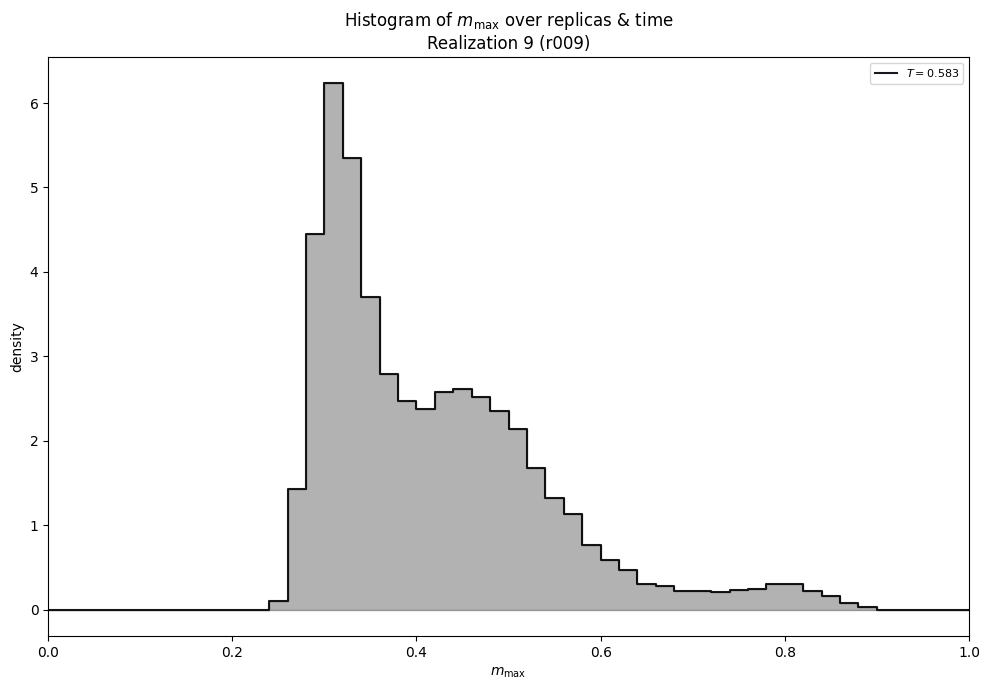

In [96]:
plot_mmax_histograms(
    "runs/hope_pool",
    disorder_idx=9,
    beta_indices=[17],
    bins=50,
    value_range=(0.0, 1.0),
    density=True,
)

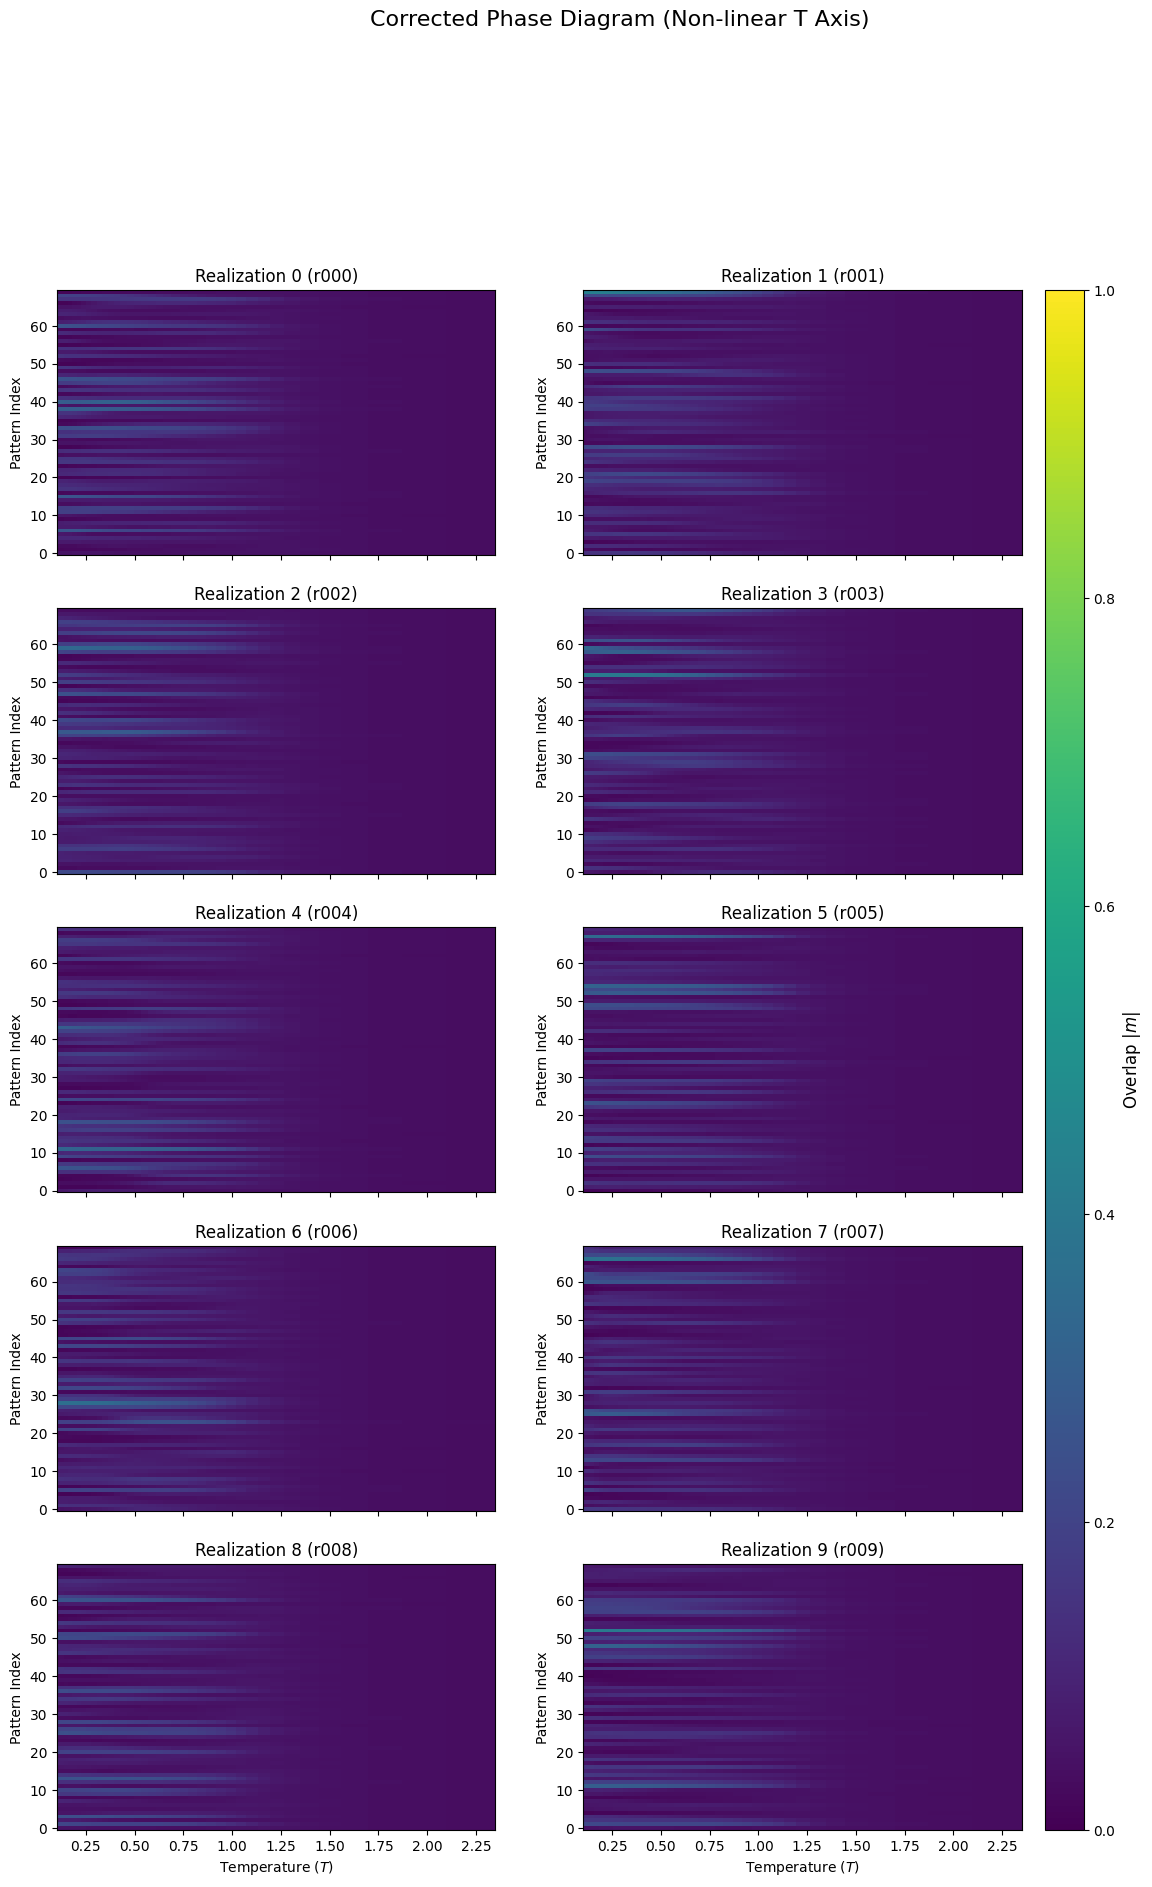

In [32]:

# Run the corrected plotter
plot_all_heatmaps_corrected("runs/hope2_pool")

In [137]:
mu_idx

array([ 2,  5,  7, 11, 16])

In [138]:
winners = [2,11,23,31,13,29,22,14,17,29]

Aligning all retrieval peaks to Pattern Index: 17


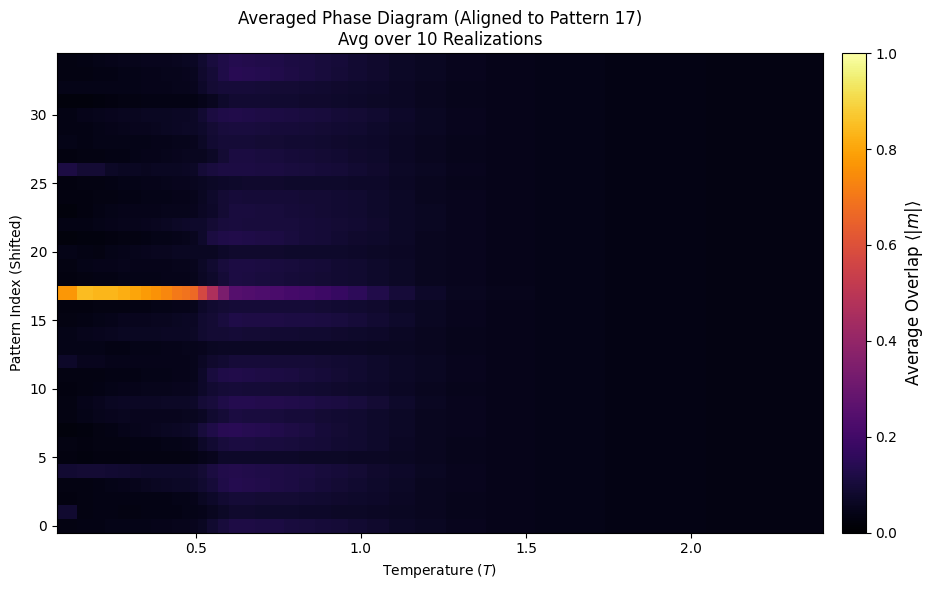

In [140]:


def plot_centered_average_heatmap(run_root, winner_indices, target_center=None):
    """
    Plots a single averaged heatmap from multiple realizations by aligning their
    retrieved patterns to a common target index.

    Args:
        run_root (str): Path to the experiment folder (e.g., "runs/explore_fina_pool")
        winner_indices (list): A list of integers [r0, r1, ... r9] representing the
                               index of the pattern retrieved at Low T for each realization.
        target_center (int): The index to shift the winner to. 
                             If None, defaults to P // 2 (visual center).
                             User requested 10, so you can pass 10 here.
    """
    rdirs = sorted(glob.glob(os.path.join(run_root, "r*")))
    
    if not rdirs:
        print("No realizations found.")
        return
    if len(rdirs) != len(winner_indices):
        print(f"Error: Found {len(rdirs)} dirs but got {len(winner_indices)} indices.")
        return

    # 1. Load Physics (for T axis and P count)
    try:
        sys = np.load(os.path.join(rdirs[0], "sysconfig.npz"))
        betas = sys["beta"]
        P = int(sys["P"])
        T_axis = 1.0 / betas
        
        # Sort T for plotting
        sort_idx = np.argsort(T_axis)
        T_sorted = T_axis[sort_idx]
    except Exception as e:
        print(f"Error loading config: {e}")
        return

    # Determine center
    if target_center is None:
        target_center = P // 2
    print(f"Aligning all retrieval peaks to Pattern Index: {target_center}")

    # Accumulator for the average
    m_accum = None
    count = 0

    # 2. Iterate and Align
    for i, rdir in enumerate(rdirs):
        m_files = sorted(glob.glob(os.path.join(rdir, "timeseries", "*.m_sel.npy")))
        if not m_files: continue

        try:
            # Load raw data: (2, Time, K, P)
            m_arr = np.concatenate([np.load(f) for f in m_files], axis=1)
            
            # Time & Replica Average -> (K, P)
            # We take the absolute value before averaging to avoid sign flipping issues
            m_mean = np.mean(np.abs(m_arr), axis=(0, 1))
            
            # Sort by Temperature -> (K_sorted, P)
            m_sorted_T = m_mean[sort_idx, :]
            
            # --- ALIGNMENT STEP ---
            # Get the winner for this realization
            winner_idx = winner_indices[i]
            
            # Calculate shift needed to move winner_idx to target_center
            # We use np.roll (cyclic shift)
            shift = target_center - winner_idx
            
            # Apply shift to the Pattern axis (axis 1)
            m_aligned = np.roll(m_sorted_T, shift, axis=1)
            
            # Accumulate
            if m_accum is None:
                m_accum = np.zeros_like(m_aligned)
            m_accum += m_aligned
            count += 1
            
        except Exception as e:
            print(f"Error processing {rdir}: {e}")

    if count == 0: return

    # 3. Compute Final Average
    m_final = m_accum / count
    
    # Transpose for plotting: X=Temperature (K), Y=Pattern (P)
    # Shape becomes (P, K)
    heatmap_data = m_final.T

    # 4. Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Meshgrid for pcolormesh
    X, Y = np.meshgrid(T_sorted, np.arange(P))
    
    # Use pcolormesh for correct non-linear T axis handling
    im = ax.pcolormesh(X, Y, heatmap_data, shading='nearest', cmap='inferno', vmin=0, vmax=1)
    
    # Visual guide for the centered pattern
    #ax.axhline(target_center, color='cyan', linestyle='--', alpha=0.5, label='Aligned Center')
    
    ax.set_title(f"Averaged Phase Diagram (Aligned to Pattern {target_center})\nAvg over {count} Realizations")
    ax.set_ylabel("Pattern Index (Shifted)")
    ax.set_xlabel("Temperature ($T$)")
    
    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label(r'Average Overlap $\langle |m| \rangle$', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Example Usage:
# You must provide the list of "winners" you observed in your previous plots.
# For example, if r000 had peak at 2, r001 at 5, etc.:

plot_centered_average_heatmap("runs/hope_pool", winners, target_center=17)

In [ ]:
def plot_disorder_magnetization(run_root, disorder_idx, pattern_indices):
    """
    Plots magnetization vs T for specific patterns in a specific disorder realization.
    
    Args:
        run_root (str): Path to the experiment root.
        disorder_idx (int): Integer 0-9 corresponding to folders r000-r009.
        pattern_indices (int or list): Index or list of pattern indices to plot.
    """
    # 1. format directory path (e.g., r005)
    r_dir = os.path.join(run_root, f"r{disorder_idx:03d}")
    
    if not os.path.exists(r_dir):
        print(f"Error: Directory {r_dir} does not exist.")
        return

    # 2. Normalize inputs
    if isinstance(pattern_indices, int):
        pattern_indices = [pattern_indices]

    # 3. Load Temperature (T) from sysconfig
    # We assume sysconfig is consistent across runs, so we load from the target dir
    try:
        sys = np.load(os.path.join(r_dir, "sysconfig.npz"))
        T = 1.0 / sys["beta"]
    except Exception as e:
        print(f"Error loading sysconfig in {r_dir}: {e}")
        return

    # 4. Load Time-series Data
    m_files = sorted(glob.glob(os.path.join(r_dir, "timeseries", "*.m_sel.npy")))
    if not m_files:
        print(f"No .m_sel.npy files found in {r_dir}/timeseries")
        return

    try:
        # Load and concatenate along Time axis (axis=1)
        # Raw Shape: (Replicas=2, Time_Chunks, Temp_Steps, Patterns)
        m_arr = np.concatenate([np.load(f) for f in m_files], axis=1)
        
        # 5. Compute Order Parameters
        # Take ABS first to handle symmetry breaking (+m vs -m in different replicas)
        # Then average over Replicas (axis 0) and Time (axis 1)
        m_means = np.mean(np.abs(m_arr), axis=(0, 1)) 
        # m_means Shape: (Temp_Steps, Patterns)

    except Exception as e:
        print(f"Error processing arrays: {e}")
        return

    # 6. Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for pid in pattern_indices:
        if pid < m_means.shape[1]:
            ax.plot(T, m_means[:, pid], marker='o', label=f'Pattern $\mu={pid}$')
        else:
            print(f"Warning: Pattern index {pid} exceeds available patterns.")

    ax.set_xlabel('Temperature ($T$)')
    ax.set_ylabel(r'Magnetization $\langle |m| \rangle_{t, repl}$')
    ax.set_title(f'Retrieval Stability: Disorder Run {disorder_idx} (r{disorder_idx:03d})')
    ax.set_ylim(-0.05, 1.05)
    ax.grid(alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

In [48]:
def plot_disorder_magnetization(run_root, disorder_idx, pattern_indices, cmap_name='plasma'):
    # 1. Format directory path (r000, r001...)
    r_dir = os.path.join(run_root, f"r{disorder_idx:03d}")
    
    if not os.path.exists(r_dir):
        print(f"Error: Directory {r_dir} does not exist.")
        return

    # 2. Normalize inputs to list
    if isinstance(pattern_indices, int):
        pattern_indices = [pattern_indices]

    # 3. Load Temperature
    try:
        sys = np.load(os.path.join(r_dir, "sysconfig.npz"))
        T = 1.0 / sys["beta"]
    except Exception as e:
        print(f"Error loading sysconfig: {e}")
        return

    # 4. Load Time-series
    m_files = sorted(glob.glob(os.path.join(r_dir, "timeseries", "*.m_sel.npy")))
    if not m_files:
        print(f"No .m_sel.npy files in {r_dir}")
        return

    try:
        m_arr = np.concatenate([np.load(f) for f in m_files], axis=1)
        # Average |m| over Replicas (0) and Time (1)
        m_means = np.mean(np.abs(m_arr), axis=(0, 1)) 
    except Exception as e:
        print(f"Error processing arrays: {e}")
        return

    # --- PLOTTING CHANGES START HERE ---
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Generate N colors from the requested colormap
    # We sample evenly from 0.0 to 0.9 (avoiding 1.0 often helps visibility on white backgrounds for plasma)
    n_patterns = len(pattern_indices)
    colors = plt.get_cmap(cmap_name)(np.linspace(0, 0.85, n_patterns))

    # Iterate with enumerate to access the corresponding color
    for i, pid in enumerate(pattern_indices):
        if pid < m_means.shape[1]:
            ax.plot(T, m_means[:, pid], 
                    marker='o', 
                    color=colors[i], 
                    label=f'Pattern $\mu={pid}$')
        else:
            print(f"Warning: Pattern index {pid} out of bounds.")

    ax.set_xlabel('Temperature ($T$)')
    ax.set_ylabel(r'Magnetization $\langle |m| \rangle$')
    ax.set_title(f'Retrieval (r{disorder_idx:03d}) - Colormap: {cmap_name}')
    ax.set_ylim(-0.05, 1.05)
    ax.grid(alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
#11 fro rid1
#23 for rid2
#18 for rid3

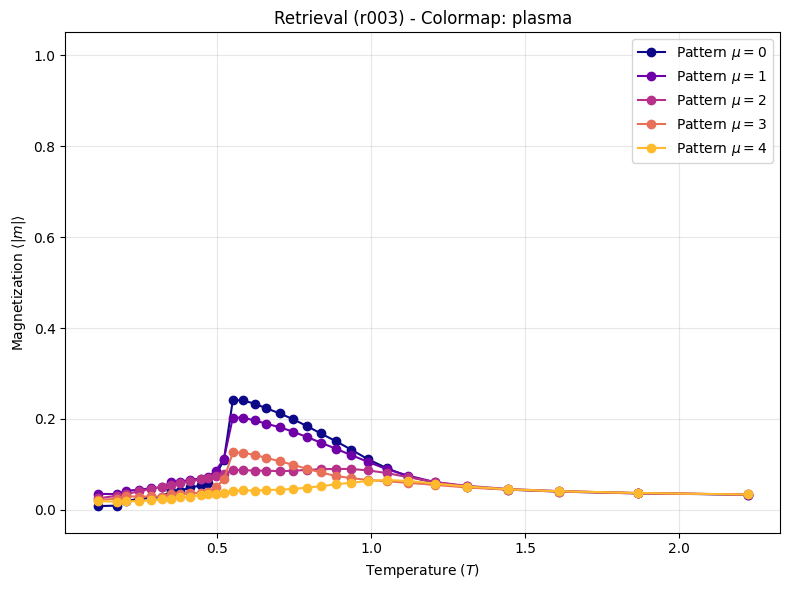

In [50]:

# Example Usage:
plot_disorder_magnetization("runs/hope_pool", disorder_idx=3, pattern_indices=_to_list(np.arange(0,5)))

In [32]:
def analyze_phase_toolkit(run_root):
    rdirs = sorted(glob.glob(os.path.join(run_root, "r*")))
    
    # Store curves for averaging
    pr_curves = []      # Participation Ratio
    m_max_curves = []   # Max Magnetization
    
    for rdir in rdirs:
        m_files = sorted(glob.glob(os.path.join(rdir, "timeseries", "*.m_sel.npy")))
        if not m_files: continue
        
        try:
            # m_arr: (2, T, K, Patterns)
            m_arr = np.concatenate([np.load(f) for f in m_files], axis=1)
            # Average over Replicas (0) and Time (1) -> Shape (K, Patterns)
            m_means = np.mean(np.abs(m_arr), axis=(0, 1))
            
            # --- 1. Max Magnetization ---
            # "How strong is the best match?"
            m_max = np.max(m_means, axis=-1)
            m_max_curves.append(m_max)
            
            # --- 2. Participation Ratio ---
            # "How many patterns contribute?"
            # P = (Sum m^2)^2 / Sum m^4
            numerator = np.sum(m_means**2, axis=-1)**2
            denominator = np.sum(m_means**4, axis=-1)
            # Avoid divide by zero if m=0
            pr = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
            pr_curves.append(pr)
            
        except Exception as e:
            print(f"Skipping {rdir}: {e}")

    # --- Plotting ---
    if not pr_curves: return

    # Load T axis
    sys = np.load(os.path.join(rdirs[0], "sysconfig.npz"))
    T = 1.0 / sys["beta"]
    
    # Averages and Errors
    PR_avg = np.mean(pr_curves, axis=0)
    PR_err = np.std(pr_curves, axis=0) / (2*np.sqrt(len(pr_curves)))
    
    M_avg = np.mean(m_max_curves, axis=0)
    M_err = np.std(m_max_curves, axis=0) / (2*np.sqrt(len(m_max_curves)))
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot Max Magnetization (Left Axis)
    color = 'tab:blue'
    ax1.set_xlabel('Temperature ($T$)')
    ax1.set_ylabel(r'Max Magnetization ($m_{max}$)', color=color)
    l1 = ax1.errorbar(T, M_avg, yerr=M_err, fmt='-o', color=color, label='$m_{max}$')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0, 1.1)
    ax1.grid(alpha=0.3)

    # Plot Participation Ratio (Right Axis)
    ax2 = ax1.twinx() 
    color = 'tab:red'
    ax2.set_ylabel('Participation Ratio ($P$)', color=color)
    # Reference line at P=1 (Pure State)
    ax2.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='Pure State (P=1)')
    l2 = ax2.errorbar(T, PR_avg, yerr=PR_err, fmt='-s', color=color, label='Participation Ratio')
    ax2.tick_params(axis='y', labelcolor=color)
    # P usually goes from 1 (Pure) to ~1.5/3 (Mixture) to >>1 (Glass)
    # Increased limit to 15.0 to see the paramagnetic noise floor (approx P/3 ~ 13)
    ax2.set_ylim(0.5, 15.0) 

    # Combine legends from both axes
    lines = [l1, l2]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')

    plt.title(f"Identifying the Retrieval Phase (N={sys['N']}, P={sys['P']})")
    fig.tight_layout()
    plt.show()

# analyze_phase_toolkit("runs/PT_OFF_3_pool")

In [ ]:
def analyze_phase_toolkit(run_root):
    rdirs = sorted(glob.glob(os.path.join(run_root, "r*")))
    if not rdirs:
        print(f"No realizations found in {run_root}")
        return

    pr_curves = []     # per-realization PR(T) curve
    mmax_curves = []   # per-realization <m_max>(T) curve

    # Load temperature axis from first realization
    sys0 = np.load(os.path.join(rdirs[0], "sysconfig.npz"))
    beta_key = "beta" if "beta" in sys0.files else ("β" if "β" in sys0.files else None)
    if beta_key is None:
        raise KeyError("sysconfig.npz has no 'beta' or 'β'")
    betas = np.array(sys0[beta_key], dtype=np.float64)
    T_axis = 1.0 / betas
    K = betas.size

    for rdir in rdirs:
        m_files = sorted(glob.glob(os.path.join(rdir, "timeseries", "*.m_sel.npy")))
        if not m_files:
            continue

        # Accumulators over (replicas,time) for each temperature index k
        sum_mmax = np.zeros(K, dtype=np.float64)
        sum_pr   = np.zeros(K, dtype=np.float64)
        n_samples = 0  # total number of (replica,time) samples contributed per temperature

        ok = True
        for f in m_files:
            try:
                m_chunk = np.load(f)  # expected shape (R, Tchunk, K, P)
            except Exception as e:
                print(f"Skipping file {f}: {e}")
                ok = False
                break

            if m_chunk.ndim != 4:
                print(f"Skipping {rdir}: {os.path.basename(f)} has shape {m_chunk.shape}, expected (R,T,K,P)")
                ok = False
                break

            R, Tchunk, K0, P = m_chunk.shape
            if K0 != K:
                print(f"Skipping {rdir}: K mismatch in {os.path.basename(f)} ({K0} vs sysconfig K={K})")
                ok = False
                break

            # Work in-place to reduce temporaries (safe since m_chunk is a fresh array)
            np.abs(m_chunk, out=m_chunk)                  # m_chunk := |m|
            # m_max per sample: shape (R, Tchunk, K)
            mmax_inst = m_chunk.max(axis=-1)
            sum_mmax += mmax_inst.sum(axis=(0, 1))

            # PR per sample:
            # s2 = sum_mu |m|^2, s4 = sum_mu |m|^4, PR = (s2^2)/s4
            m2 = m_chunk * m_chunk                        # |m|^2
            s2 = m2.sum(axis=-1)                          # (R, Tchunk, K)
            s4 = (m2 * m2).sum(axis=-1)                   # (R, Tchunk, K)

            pr_inst = np.zeros_like(s2, dtype=np.float64)
            np.divide(s2 * s2, s4, out=pr_inst, where=(s4 != 0.0))
            sum_pr += pr_inst.sum(axis=(0, 1))

            n_samples += R * Tchunk

        if not ok or n_samples == 0:
            continue

        # Per-realization mean curves vs T
        mmax_curve = sum_mmax / n_samples
        pr_curve   = sum_pr   / n_samples

        mmax_curves.append(mmax_curve)
        pr_curves.append(pr_curve)

    if not pr_curves:
        print("No usable realizations found.")
        return

    mmax_curves = np.array(mmax_curves, dtype=np.float64)  # (nR, K)
    pr_curves   = np.array(pr_curves,   dtype=np.float64)  # (nR, K)
    nR = mmax_curves.shape[0]

    # Sort by temperature for prettier plots
    order = np.argsort(T_axis)
    T = T_axis[order]
    mmax_curves = mmax_curves[:, order]
    pr_curves   = pr_curves[:, order]

    # Averages
    M_avg  = mmax_curves.mean(axis=0)
    PR_avg = pr_curves.mean(axis=0)

    # Standard error of the mean across disorder realizations
    if nR > 1:
        M_err  = mmax_curves.std(axis=0, ddof=1) / np.sqrt(nR)
        PR_err = pr_curves.std(axis=0, ddof=1) / np.sqrt(nR)
    else:
        M_err  = np.zeros_like(M_avg)
        PR_err = np.zeros_like(PR_avg)

    # ---- Plotting ----
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel(r"Temperature $T$")
    ax1.set_ylabel(r"$\langle m_{\max}\rangle$ (over replicas & time)")
    ax1.errorbar(T, M_avg, yerr=M_err, fmt='-o', label=r"$\langle m_{\max}\rangle$")

    ax1.set_ylim(0.0, 1.05)
    ax1.grid(alpha=0.3)

    ax2 = ax1.twinx()
    ax2.set_ylabel(r"Participation ratio $\langle P\rangle$")
    ax2.axhline(1.0, linestyle='--', alpha=0.5, label=r"Pure state ($P=1$)")
    ax2.errorbar(T, PR_avg, yerr=PR_err, fmt='-s', label=r"$\langle P\rangle$")

    # Keep PR axis reasonable but not clipped
    pr_hi = np.nanmax(PR_avg + PR_err)
    ax2.set_ylim(0.5, max(2.0, min(15.0, 1.1 * pr_hi if np.isfinite(pr_hi) else 15.0)))

    # Combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="center right")

    # Optional: show N,P if present
    title_bits = [f"Identifying phases (n_realizations={nR})"]
    if "N" in sys0.files and "P" in sys0.files:
        title_bits.append(f"N={int(sys0['N'])}, P={int(sys0['P'])}")
    plt.title(" — ".join(title_bits))

    fig.tight_layout()
    plt.show()


In [40]:
def analyze_phase_toolkit(run_root):
    rdirs = sorted(glob.glob(os.path.join(run_root, "r*")))
    if not rdirs:
        print(f"No realizations found in {run_root}")
        return

    # Load temperature axis from first realization
    sys0 = np.load(os.path.join(rdirs[0], "sysconfig.npz"))
    beta_key = "beta" if "beta" in sys0.files else ("β" if "β" in sys0.files else None)
    if beta_key is None:
        raise KeyError("sysconfig.npz has no 'beta' or 'β'")
    betas = np.array(sys0[beta_key], dtype=np.float64)
    T_axis = 1.0 / betas
    K = betas.size

    mmax_curves = []   # per-realization <m_max>(T)
    ipr_curves  = []   # per-realization <IPR>(T)

    for rdir in rdirs:
        m_files = sorted(glob.glob(os.path.join(rdir, "timeseries", "*.m_sel.npy")))
        if not m_files:
            continue

        sum_mmax = np.zeros(K, dtype=np.float64)
        sum_ipr  = np.zeros(K, dtype=np.float64)
        n_samples = 0

        ok = True
        for f in m_files:
            try:
                m = np.load(f)  # (R, Tchunk, K, P)
            except Exception as e:
                print(f"Skipping file {f}: {e}")
                ok = False
                break

            if m.ndim != 4:
                print(f"Skipping {rdir}: {os.path.basename(f)} has shape {m.shape}, expected (R,T,K,P)")
                ok = False
                break

            R, Tchunk, K0, P = m.shape
            if K0 != K:
                print(f"Skipping {rdir}: K mismatch in {os.path.basename(f)} ({K0} vs sysconfig K={K})")
                ok = False
                break

            # |m|
            np.abs(m, out=m)

            # instantaneous m_max per sample: (R, Tchunk, K)
            mmax_inst = m.max(axis=-1)
            sum_mmax += mmax_inst.sum(axis=(0, 1))

            # IPR per sample:
            # s2 = sum |m|^2, s4 = sum |m|^4, IPR = s4 / (s2^2)
            m2 = m * m
            s2 = m2.sum(axis=-1)            # (R, Tchunk, K)
            s4 = (m2 * m2).sum(axis=-1)     # (R, Tchunk, K)

            ipr_inst = np.zeros_like(s2, dtype=np.float64)
            np.divide(s4, s2 * s2, out=ipr_inst, where=(s2 != 0.0))
            sum_ipr += ipr_inst.sum(axis=(0, 1))

            n_samples += R * Tchunk

        if (not ok) or n_samples == 0:
            continue

        mmax_curves.append(sum_mmax / n_samples)
        ipr_curves.append(sum_ipr / n_samples)

    if not mmax_curves:
        print("No usable realizations found.")
        return

    mmax_curves = np.array(mmax_curves, dtype=np.float64)  # (nR, K)
    ipr_curves  = np.array(ipr_curves,  dtype=np.float64)  # (nR, K)
    nR = mmax_curves.shape[0]

    # sort by temperature
    order = np.argsort(T_axis)
    T = T_axis[order]
    mmax_curves = mmax_curves[:, order]
    ipr_curves  = ipr_curves[:, order]

    # means + SEM across realizations
    M_avg  = mmax_curves.mean(axis=0)
    I_avg  = ipr_curves.mean(axis=0)

    if nR > 1:
        M_err = mmax_curves.std(axis=0, ddof=1) / np.sqrt(nR)
        I_err = ipr_curves.std(axis=0, ddof=1) / np.sqrt(nR)
    else:
        M_err = np.zeros_like(M_avg)
        I_err = np.zeros_like(I_avg)

    # ---- plotting ----
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel(r"Temperature $T$")
    ax1.set_ylabel(r"$\langle m_{\max}\rangle$")
    ax1.errorbar(T, M_avg, yerr=M_err, fmt='-o', label=r"$\langle m_{\max}\rangle$")
    ax1.set_ylim(0.0, 1.05)
    ax1.grid(alpha=0.3)

    ax2 = ax1.twinx()
    ax2.set_ylabel(r"$\langle \mathrm{IPR}\rangle = \left\langle \frac{\sum_\mu m_\mu^4}{(\sum_\mu m_\mu^2)^2}\right\rangle$")
    ax2.axhline(1.0, linestyle='--', alpha=0.4, label="pure (IPR=1)")
    ax2.errorbar(T, I_avg, yerr=I_err, fmt='-s', label=r"$\langle \mathrm{IPR}\rangle$",color='red')
    ax2.set_ylim(0.0, 1.05)

    # combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="center right")

    title = f"Phase diagnostics (n_realizations={nR})"
    if "N" in sys0.files and "P" in sys0.files:
        title += f" — N={int(sys0['N'])}, P={int(sys0['P'])}"
    plt.title(title)

    fig.tight_layout()
    plt.show()


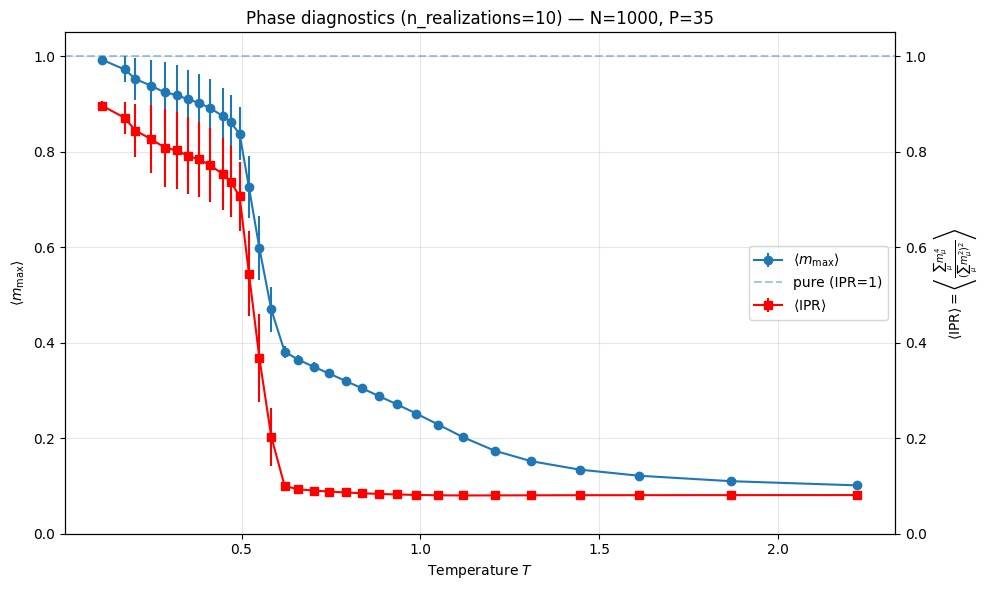

In [ ]:
analyze_phase_toolkit("runs/hope_pool")

# Other

#### Discrete rewiring

In [41]:
@njit(float64[:, ::1](int64, int8[:, ::1]), nogil=True)
def build_C(N, ξ):
    # cast once to float for BLAS-friendly math
    Xi = ξ.astype(np.float64)
    C = np.ascontiguousarray((Xi.T @ Xi) * (1.0 / N))
    return C

@njit(void(float64[:, ::1], float64[:, ::1], float64, int64), nogil=True)
def update_G_with_C(G, C, ε, k):
    γ = ε / (1.0 + ε * k)
    # two matmuls
    T = G @ C           # P×P
    G[:, :] = (1.0 + γ) * G - γ * (T @ G)
    # (optional) enforce symmetry to kill fp drift
    for μ in range(G.shape[0]):
        for ν in range(μ + 1, G.shape[1]):
            s = 0.5 * (G[μ, ν] + G[ν, μ])
            G[μ, ν] = s
            G[ν, μ] = s

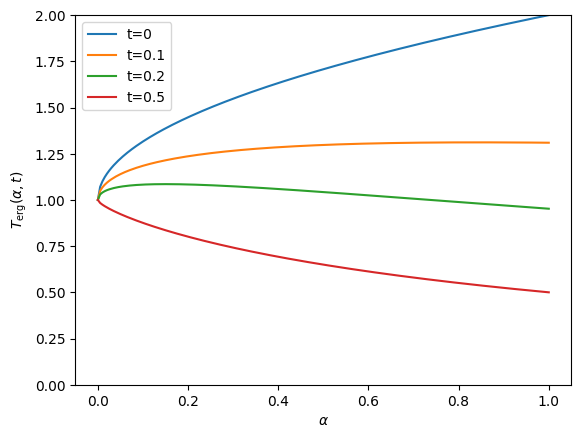

In [133]:
import numpy as np

def T_erg(alpha, t):
    alpha = np.asarray(alpha)
    sa = np.sqrt(alpha)
    Delta = 1.0 + sa*(1.0 + sa)*t
    beta_c = (1.0/(1.0 + t))*(Delta**2/(1.0 + sa) + t*Delta)
    return 1.0 / beta_c

# Example: plot for a few t's
import matplotlib.pyplot as plt

alphas = np.linspace(0, 1.0, 200)

for t, lbl in [(0.0,"t=0"),(0.1,"t=0.1"),(0.2,"t=0.2"),(0.5,"t=0.5")]:
    plt.plot(alphas, T_erg(alphas,t), label=lbl)

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$T_{\rm erg}(\alpha,t)$')
plt.ylim(0,2)
plt.legend()
plt.show()
